This code
1. Loads the cancer dataset, available at: https://hastie.su.domains/ElemStatLearn/datasets/prostate.data
2. Standardizes the training data (not the targets)
3. Transforms the testing data in the same manner by using the means and standard deviations of the training data
4. Performs Ordinary Least Squares on training data
5. Starts applying an L1 penalty
6. Gets the lowest test error over all lambda
7. Plots the coefficient paths

In [1]:
import torch
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
# reading csv files
data =  pd.read_csv('prostate.data', sep="	")


n=97 observations, 67 training, 30 test
p=8 predictors
y = lpsa (response) 96 * 1 
X = 96 * 8
beta = 8 * 1 (coefficients)
y = X * beta

Data needs to be split. Normalize and standardize (columns) using the training data only, extend the stored parameters to normalize and standardize the test data too

In [3]:
# Convert data to doubles
data_cols = ['age', 'gleason', 'lbph', 'lcavol', 'lcp','lweight', 'pgg45', 'svi']
data[data_cols] = data[data_cols].astype('double', copy=True, errors='raise')

grouped = data.groupby(data.train)
pan_train_data = grouped.get_group("T")
pan_test_data = grouped.get_group("F")


# The data needs to be normalized
means = pan_train_data[data_cols].mean()
variances = pan_train_data[data_cols].std(ddof=0)

pan_train_data[data_cols] = (pan_train_data[data_cols]-means)/variances
pan_test_data[data_cols] = (pan_test_data[data_cols]-means)/variances



/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24384/1560018052.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pan_train_data[data_cols] = (pan_train_data[data_cols]-means)/variances
/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24384/1560018052.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pan_test_data[data_cols] = (pan_test_data[data_cols]-means)/variances


In [4]:
X_train = pan_train_data[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_train = pan_train_data[['lpsa']]

X_test = pan_test_data[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_test = pan_test_data[['lpsa']]


In [5]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train.iloc[i].to_numpy(),y_train.iloc[i].to_numpy()])

test_data = []
for i in range(len(X_test)):
    test_data.append([X_test.iloc[i].to_numpy(),y_test.iloc[i].to_numpy()])
    


In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [7]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize,bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

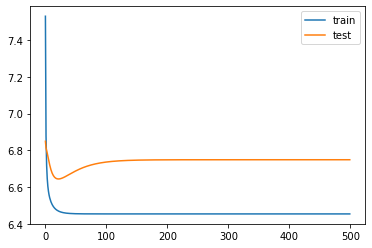

In [8]:
inputDim = len(train_data[0][0])        # takes variable 'x' 
outputDim = len(train_data[0][1])       # takes variable 'y'
learningRate = 0.1 
epochs = 500

model = linearRegression(inputDim, outputDim)
model = model.double()

train_loss = []
test_loss = []

loss_fn = torch.nn.MSELoss(reduction='mean') 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

def train_loop(train_loader, model, loss_fn, optimizer, train_loss):
    size = len(train_loader.dataset)
    for batch, (X,y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = loss.item()
    train_loss.append(loss)

            
def test_loop(train_loader, model, loss_fn, test_loss):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    t_loss = 0
    
    with torch.no_grad():
        for X,y in test_loader:
            pred = model(X)
            t_loss += loss_fn(pred,y).item()
    
    t_loss /= num_batches
    test_loss.append([t_loss])



for t in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer,train_loss)
    test_loop(test_loader, model, loss_fn, test_loss)


plt.plot([x for x in range(len(train_loss))],train_loss,label='train')
plt.plot([x for x in range(len(test_loss))],test_loss,label='test')
plt.legend()


train_loss = []
test_loss = []

In [9]:
def train_loop(train_loader, model, loss_fn, optimizer, train_loss, l1_lambda, l2_lambda):
    size = len(train_loader.dataset)
    for batch, (X,y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred,y)
        
        training_error = loss.item()
        
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        l1_norm = sum(p.abs().sum() for p in model.parameters())

 
        loss = loss + l2_lambda * l2_norm + l1_lambda * l1_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = training_error
    print(f"Training loss: {loss:>7f}")
    train_loss.append(loss)

            
def test_loop(train_loader, model, loss_fn, test_loss):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    t_loss = 0
    
    with torch.no_grad():
        for X,y in test_loader:
            pred = model(X)
            t_loss += loss_fn(pred,y).item()
    
    t_loss /= num_batches
    print(f"Test loss: {t_loss:>8f}\n")
    test_loss.append([t_loss])



In [10]:
epochs = 100
learningRate = 0.0003
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)


interval_start = -2.5
interval_end = 0.5


l1_lambda = 0
l2_lambda = 0


l1_intervals = 500

train_path = []
test_path = []
weight_path = []


for l1_index, l1_lambda in enumerate(np.logspace(interval_start, interval_end, num=l1_intervals)):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer,train_loss, l1_lambda, l2_lambda)
        test_loop(test_loader, model, loss_fn, test_loss)
    print(f"Done with {np.log10(l2_lambda)}\n")
    train_path.append(train_loss[-1])
    test_path.append(test_loss[-1])
    weight_path.append(np.array([param for param in model.parameters()][0][0].detach()))

print('Done!')

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 12
-------------------------------
Training loss: 6.45319

/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24384/598070417.py:26: RuntimeWarning: divide by zero encountered in log10
  print(f"Done with {np.log10(l2_lambda)}\n")


Training loss: 6.453196
Test loss: 6.748645

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748645

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748646

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748646

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748646

Epoch 15
------

Training loss: 6.453197
Test loss: 6.748645

Epoch 10
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 11
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 12
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 13
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 14
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 15
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 16
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 17
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 18
-------------------------------
Training loss: 6.453197
Test loss: 6.748645

Epoch 19
-------------------------------
Training loss: 6.453197
Test loss: 6.748644

Epoch 20
-------------------------------
Training loss: 6.453197
Test loss: 6.748644

Epoch 21


Test loss: 6.748638

Epoch 20
-------------------------------
Training loss: 6.453197
Test loss: 6.748638

Epoch 21
-------------------------------
Training loss: 6.453197
Test loss: 6.748638

Epoch 22
-------------------------------
Training loss: 6.453197
Test loss: 6.748638

Epoch 23
-------------------------------
Training loss: 6.453197
Test loss: 6.748638

Epoch 24
-------------------------------
Training loss: 6.453197
Test loss: 6.748638

Epoch 25
-------------------------------
Training loss: 6.453197
Test loss: 6.748638

Epoch 26
-------------------------------
Training loss: 6.453197
Test loss: 6.748637

Epoch 27
-------------------------------
Training loss: 6.453197
Test loss: 6.748637

Epoch 28
-------------------------------
Training loss: 6.453197
Test loss: 6.748637

Epoch 29
-------------------------------
Training loss: 6.453197
Test loss: 6.748637

Epoch 30
-------------------------------
Training loss: 6.453197
Test loss: 6.748637

Epoch 31
------------------------

Training loss: 6.453197
Test loss: 6.748611

Epoch 13
-------------------------------
Training loss: 6.453197
Test loss: 6.748611

Epoch 14
-------------------------------
Training loss: 6.453197
Test loss: 6.748611

Epoch 15
-------------------------------
Training loss: 6.453197
Test loss: 6.748611

Epoch 16
-------------------------------
Training loss: 6.453197
Test loss: 6.748610

Epoch 17
-------------------------------
Training loss: 6.453197
Test loss: 6.748610

Epoch 18
-------------------------------
Training loss: 6.453197
Test loss: 6.748610

Epoch 19
-------------------------------
Training loss: 6.453197
Test loss: 6.748610

Epoch 20
-------------------------------
Training loss: 6.453197
Test loss: 6.748610

Epoch 21
-------------------------------
Training loss: 6.453197
Test loss: 6.748609

Epoch 22
-------------------------------
Training loss: 6.453197
Test loss: 6.748609

Epoch 23
-------------------------------
Training loss: 6.453197
Test loss: 6.748609

Epoch 24


Training loss: 6.453198
Test loss: 6.748564

Epoch 10
-------------------------------
Training loss: 6.453198
Test loss: 6.748564

Epoch 11
-------------------------------
Training loss: 6.453198
Test loss: 6.748564

Epoch 12
-------------------------------
Training loss: 6.453198
Test loss: 6.748563

Epoch 13
-------------------------------
Training loss: 6.453198
Test loss: 6.748563

Epoch 14
-------------------------------
Training loss: 6.453198
Test loss: 6.748563

Epoch 15
-------------------------------
Training loss: 6.453198
Test loss: 6.748562

Epoch 16
-------------------------------
Training loss: 6.453198
Test loss: 6.748562

Epoch 17
-------------------------------
Training loss: 6.453198
Test loss: 6.748562

Epoch 18
-------------------------------
Training loss: 6.453198
Test loss: 6.748562

Epoch 19
-------------------------------
Training loss: 6.453198
Test loss: 6.748561

Epoch 20
-------------------------------
Training loss: 6.453198
Test loss: 6.748561

Epoch 21


Test loss: 6.748530

Epoch 19
-------------------------------
Training loss: 6.453199
Test loss: 6.748529

Epoch 20
-------------------------------
Training loss: 6.453199
Test loss: 6.748529

Epoch 21
-------------------------------
Training loss: 6.453199
Test loss: 6.748529

Epoch 22
-------------------------------
Training loss: 6.453199
Test loss: 6.748528

Epoch 23
-------------------------------
Training loss: 6.453199
Test loss: 6.748528

Epoch 24
-------------------------------
Training loss: 6.453199
Test loss: 6.748528

Epoch 25
-------------------------------
Training loss: 6.453199
Test loss: 6.748527

Epoch 26
-------------------------------
Training loss: 6.453199
Test loss: 6.748527

Epoch 27
-------------------------------
Training loss: 6.453199
Test loss: 6.748527

Epoch 28
-------------------------------
Training loss: 6.453199
Test loss: 6.748526

Epoch 29
-------------------------------
Training loss: 6.453199
Test loss: 6.748526

Epoch 30
------------------------

Test loss: 6.748493

Epoch 19
-------------------------------
Training loss: 6.453199
Test loss: 6.748493

Epoch 20
-------------------------------
Training loss: 6.453199
Test loss: 6.748492

Epoch 21
-------------------------------
Training loss: 6.453199
Test loss: 6.748492

Epoch 22
-------------------------------
Training loss: 6.453199
Test loss: 6.748492

Epoch 23
-------------------------------
Training loss: 6.453199
Test loss: 6.748491

Epoch 24
-------------------------------
Training loss: 6.453199
Test loss: 6.748491

Epoch 25
-------------------------------
Training loss: 6.453199
Test loss: 6.748491

Epoch 26
-------------------------------
Training loss: 6.453199
Test loss: 6.748490

Epoch 27
-------------------------------
Training loss: 6.453199
Test loss: 6.748490

Epoch 28
-------------------------------
Training loss: 6.453199
Test loss: 6.748489

Epoch 29
-------------------------------
Training loss: 6.453199
Test loss: 6.748489

Epoch 30
------------------------

Test loss: 6.748424

Epoch 82
-------------------------------
Training loss: 6.453200
Test loss: 6.748423

Epoch 83
-------------------------------
Training loss: 6.453200
Test loss: 6.748423

Epoch 84
-------------------------------
Training loss: 6.453200
Test loss: 6.748422

Epoch 85
-------------------------------
Training loss: 6.453200
Test loss: 6.748422

Epoch 86
-------------------------------
Training loss: 6.453200
Test loss: 6.748421

Epoch 87
-------------------------------
Training loss: 6.453200
Test loss: 6.748421

Epoch 88
-------------------------------
Training loss: 6.453200
Test loss: 6.748420

Epoch 89
-------------------------------
Training loss: 6.453200
Test loss: 6.748420

Epoch 90
-------------------------------
Training loss: 6.453200
Test loss: 6.748419

Epoch 91
-------------------------------
Training loss: 6.453200
Test loss: 6.748419

Epoch 92
-------------------------------
Training loss: 6.453200
Test loss: 6.748418

Epoch 93
------------------------

Training loss: 6.453201
Test loss: 6.748348

Epoch 34
-------------------------------
Training loss: 6.453201
Test loss: 6.748347

Epoch 35
-------------------------------
Training loss: 6.453201
Test loss: 6.748347

Epoch 36
-------------------------------
Training loss: 6.453201
Test loss: 6.748346

Epoch 37
-------------------------------
Training loss: 6.453201
Test loss: 6.748346

Epoch 38
-------------------------------
Training loss: 6.453201
Test loss: 6.748345

Epoch 39
-------------------------------
Training loss: 6.453201
Test loss: 6.748345

Epoch 40
-------------------------------
Training loss: 6.453201
Test loss: 6.748344

Epoch 41
-------------------------------
Training loss: 6.453201
Test loss: 6.748343

Epoch 42
-------------------------------
Training loss: 6.453201
Test loss: 6.748343

Epoch 43
-------------------------------
Training loss: 6.453201
Test loss: 6.748342

Epoch 44
-------------------------------
Training loss: 6.453201
Test loss: 6.748342

Epoch 45


Test loss: 6.748282

Epoch 51
-------------------------------
Training loss: 6.453202
Test loss: 6.748282

Epoch 52
-------------------------------
Training loss: 6.453202
Test loss: 6.748281

Epoch 53
-------------------------------
Training loss: 6.453202
Test loss: 6.748281

Epoch 54
-------------------------------
Training loss: 6.453202
Test loss: 6.748280

Epoch 55
-------------------------------
Training loss: 6.453202
Test loss: 6.748279

Epoch 56
-------------------------------
Training loss: 6.453202
Test loss: 6.748279

Epoch 57
-------------------------------
Training loss: 6.453202
Test loss: 6.748278

Epoch 58
-------------------------------
Training loss: 6.453202
Test loss: 6.748278

Epoch 59
-------------------------------
Training loss: 6.453202
Test loss: 6.748277

Epoch 60
-------------------------------
Training loss: 6.453202
Test loss: 6.748277

Epoch 61
-------------------------------
Training loss: 6.453202
Test loss: 6.748276

Epoch 62
------------------------

Training loss: 6.453203
Test loss: 6.748202

Epoch 83
-------------------------------
Training loss: 6.453203
Test loss: 6.748201

Epoch 84
-------------------------------
Training loss: 6.453203
Test loss: 6.748200

Epoch 85
-------------------------------
Training loss: 6.453203
Test loss: 6.748200

Epoch 86
-------------------------------
Training loss: 6.453203
Test loss: 6.748199

Epoch 87
-------------------------------
Training loss: 6.453203
Test loss: 6.748199

Epoch 88
-------------------------------
Training loss: 6.453203
Test loss: 6.748198

Epoch 89
-------------------------------
Training loss: 6.453203
Test loss: 6.748197

Epoch 90
-------------------------------
Training loss: 6.453203
Test loss: 6.748197

Epoch 91
-------------------------------
Training loss: 6.453203
Test loss: 6.748196

Epoch 92
-------------------------------
Training loss: 6.453203
Test loss: 6.748195

Epoch 93
-------------------------------
Training loss: 6.453203
Test loss: 6.748195

Epoch 94


Training loss: 6.453203
Test loss: 6.748115

Epoch 13
-------------------------------
Training loss: 6.453203
Test loss: 6.748115

Epoch 14
-------------------------------
Training loss: 6.453203
Test loss: 6.748114

Epoch 15
-------------------------------
Training loss: 6.453203
Test loss: 6.748113

Epoch 16
-------------------------------
Training loss: 6.453203
Test loss: 6.748113

Epoch 17
-------------------------------
Training loss: 6.453203
Test loss: 6.748112

Epoch 18
-------------------------------
Training loss: 6.453203
Test loss: 6.748111

Epoch 19
-------------------------------
Training loss: 6.453203
Test loss: 6.748110

Epoch 20
-------------------------------
Training loss: 6.453203
Test loss: 6.748110

Epoch 21
-------------------------------
Training loss: 6.453203
Test loss: 6.748109

Epoch 22
-------------------------------
Training loss: 6.453203
Test loss: 6.748108

Epoch 23
-------------------------------
Training loss: 6.453203
Test loss: 6.748108

Epoch 24


Test loss: 6.748041

Epoch 17
-------------------------------
Training loss: 6.453204
Test loss: 6.748041

Epoch 18
-------------------------------
Training loss: 6.453204
Test loss: 6.748040

Epoch 19
-------------------------------
Training loss: 6.453204
Test loss: 6.748039

Epoch 20
-------------------------------
Training loss: 6.453204
Test loss: 6.748038

Epoch 21
-------------------------------
Training loss: 6.453204
Test loss: 6.748038

Epoch 22
-------------------------------
Training loss: 6.453204
Test loss: 6.748037

Epoch 23
-------------------------------
Training loss: 6.453204
Test loss: 6.748036

Epoch 24
-------------------------------
Training loss: 6.453204
Test loss: 6.748035

Epoch 25
-------------------------------
Training loss: 6.453204
Test loss: 6.748035

Epoch 26
-------------------------------
Training loss: 6.453204
Test loss: 6.748034

Epoch 27
-------------------------------
Training loss: 6.453204
Test loss: 6.748033

Epoch 28
------------------------

Training loss: 6.453205
Test loss: 6.747963

Epoch 21
-------------------------------
Training loss: 6.453205
Test loss: 6.747962

Epoch 22
-------------------------------
Training loss: 6.453205
Test loss: 6.747962

Epoch 23
-------------------------------
Training loss: 6.453205
Test loss: 6.747961

Epoch 24
-------------------------------
Training loss: 6.453205
Test loss: 6.747960

Epoch 25
-------------------------------
Training loss: 6.453205
Test loss: 6.747959

Epoch 26
-------------------------------
Training loss: 6.453205
Test loss: 6.747959

Epoch 27
-------------------------------
Training loss: 6.453205
Test loss: 6.747958

Epoch 28
-------------------------------
Training loss: 6.453205
Test loss: 6.747957

Epoch 29
-------------------------------
Training loss: 6.453205
Test loss: 6.747956

Epoch 30
-------------------------------
Training loss: 6.453205
Test loss: 6.747956

Epoch 31
-------------------------------
Training loss: 6.453205
Test loss: 6.747955

Epoch 32


Training loss: 6.453206
Test loss: 6.747885

Epoch 20
-------------------------------
Training loss: 6.453206
Test loss: 6.747884

Epoch 21
-------------------------------
Training loss: 6.453206
Test loss: 6.747884

Epoch 22
-------------------------------
Training loss: 6.453206
Test loss: 6.747883

Epoch 23
-------------------------------
Training loss: 6.453206
Test loss: 6.747882

Epoch 24
-------------------------------
Training loss: 6.453206
Test loss: 6.747881

Epoch 25
-------------------------------
Training loss: 6.453206
Test loss: 6.747880

Epoch 26
-------------------------------
Training loss: 6.453206
Test loss: 6.747879

Epoch 27
-------------------------------
Training loss: 6.453206
Test loss: 6.747879

Epoch 28
-------------------------------
Training loss: 6.453206
Test loss: 6.747878

Epoch 29
-------------------------------
Training loss: 6.453206
Test loss: 6.747877

Epoch 30
-------------------------------
Training loss: 6.453206
Test loss: 6.747876

Epoch 31


Test loss: 6.747740

Epoch 93
-------------------------------
Training loss: 6.453207
Test loss: 6.747739

Epoch 94
-------------------------------
Training loss: 6.453207
Test loss: 6.747738

Epoch 95
-------------------------------
Training loss: 6.453207
Test loss: 6.747738

Epoch 96
-------------------------------
Training loss: 6.453207
Test loss: 6.747737

Epoch 97
-------------------------------
Training loss: 6.453207
Test loss: 6.747736

Epoch 98
-------------------------------
Training loss: 6.453207
Test loss: 6.747735

Epoch 99
-------------------------------
Training loss: 6.453207
Test loss: 6.747734

Epoch 100
-------------------------------
Training loss: 6.453207
Test loss: 6.747733

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453207
Test loss: 6.747732

Epoch 2
-------------------------------
Training loss: 6.453207
Test loss: 6.747731

Epoch 3
-------------------------------
Training loss: 6.453207
Test loss: 6.747731

Epoch 4
-----------

Training loss: 6.453208
Test loss: 6.747653

Epoch 91
-------------------------------
Training loss: 6.453208
Test loss: 6.747653

Epoch 92
-------------------------------
Training loss: 6.453208
Test loss: 6.747652

Epoch 93
-------------------------------
Training loss: 6.453208
Test loss: 6.747651

Epoch 94
-------------------------------
Training loss: 6.453208
Test loss: 6.747650

Epoch 95
-------------------------------
Training loss: 6.453208
Test loss: 6.747649

Epoch 96
-------------------------------
Training loss: 6.453208
Test loss: 6.747648

Epoch 97
-------------------------------
Training loss: 6.453208
Test loss: 6.747647

Epoch 98
-------------------------------
Training loss: 6.453208
Test loss: 6.747646

Epoch 99
-------------------------------
Training loss: 6.453208
Test loss: 6.747645

Epoch 100
-------------------------------
Training loss: 6.453208
Test loss: 6.747644

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453208
Test loss: 6.7

Test loss: 6.747566

Epoch 86
-------------------------------
Training loss: 6.453209
Test loss: 6.747565

Epoch 87
-------------------------------
Training loss: 6.453209
Test loss: 6.747564

Epoch 88
-------------------------------
Training loss: 6.453209
Test loss: 6.747564

Epoch 89
-------------------------------
Training loss: 6.453209
Test loss: 6.747563

Epoch 90
-------------------------------
Training loss: 6.453209
Test loss: 6.747562

Epoch 91
-------------------------------
Training loss: 6.453209
Test loss: 6.747561

Epoch 92
-------------------------------
Training loss: 6.453209
Test loss: 6.747560

Epoch 93
-------------------------------
Training loss: 6.453209
Test loss: 6.747559

Epoch 94
-------------------------------
Training loss: 6.453209
Test loss: 6.747558

Epoch 95
-------------------------------
Training loss: 6.453209
Test loss: 6.747557

Epoch 96
-------------------------------
Training loss: 6.453209
Test loss: 6.747556

Epoch 97
------------------------

Training loss: 6.453209
Test loss: 6.747473

Epoch 84
-------------------------------
Training loss: 6.453209
Test loss: 6.747472

Epoch 85
-------------------------------
Training loss: 6.453209
Test loss: 6.747471

Epoch 86
-------------------------------
Training loss: 6.453209
Test loss: 6.747470

Epoch 87
-------------------------------
Training loss: 6.453209
Test loss: 6.747470

Epoch 88
-------------------------------
Training loss: 6.453209
Test loss: 6.747469

Epoch 89
-------------------------------
Training loss: 6.453209
Test loss: 6.747468

Epoch 90
-------------------------------
Training loss: 6.453209
Test loss: 6.747467

Epoch 91
-------------------------------
Training loss: 6.453209
Test loss: 6.747466

Epoch 92
-------------------------------
Training loss: 6.453210
Test loss: 6.747465

Epoch 93
-------------------------------
Training loss: 6.453210
Test loss: 6.747464

Epoch 94
-------------------------------
Training loss: 6.453210
Test loss: 6.747463

Epoch 95


Training loss: 6.453211
Test loss: 6.747280

Epoch 78
-------------------------------
Training loss: 6.453211
Test loss: 6.747279

Epoch 79
-------------------------------
Training loss: 6.453211
Test loss: 6.747278

Epoch 80
-------------------------------
Training loss: 6.453211
Test loss: 6.747277

Epoch 81
-------------------------------
Training loss: 6.453211
Test loss: 6.747276

Epoch 82
-------------------------------
Training loss: 6.453211
Test loss: 6.747275

Epoch 83
-------------------------------
Training loss: 6.453211
Test loss: 6.747274

Epoch 84
-------------------------------
Training loss: 6.453211
Test loss: 6.747273

Epoch 85
-------------------------------
Training loss: 6.453211
Test loss: 6.747272

Epoch 86
-------------------------------
Training loss: 6.453211
Test loss: 6.747271

Epoch 87
-------------------------------
Training loss: 6.453211
Test loss: 6.747270

Epoch 88
-------------------------------
Training loss: 6.453211
Test loss: 6.747269

Epoch 89


Test loss: 6.747173

Epoch 81
-------------------------------
Training loss: 6.453212
Test loss: 6.747172

Epoch 82
-------------------------------
Training loss: 6.453212
Test loss: 6.747171

Epoch 83
-------------------------------
Training loss: 6.453212
Test loss: 6.747170

Epoch 84
-------------------------------
Training loss: 6.453212
Test loss: 6.747169

Epoch 85
-------------------------------
Training loss: 6.453212
Test loss: 6.747168

Epoch 86
-------------------------------
Training loss: 6.453212
Test loss: 6.747167

Epoch 87
-------------------------------
Training loss: 6.453212
Test loss: 6.747166

Epoch 88
-------------------------------
Training loss: 6.453212
Test loss: 6.747165

Epoch 89
-------------------------------
Training loss: 6.453212
Test loss: 6.747164

Epoch 90
-------------------------------
Training loss: 6.453212
Test loss: 6.747163

Epoch 91
-------------------------------
Training loss: 6.453212
Test loss: 6.747162

Epoch 92
------------------------

Training loss: 6.453214
Test loss: 6.746970

Epoch 69
-------------------------------
Training loss: 6.453214
Test loss: 6.746969

Epoch 70
-------------------------------
Training loss: 6.453214
Test loss: 6.746968

Epoch 71
-------------------------------
Training loss: 6.453214
Test loss: 6.746967

Epoch 72
-------------------------------
Training loss: 6.453214
Test loss: 6.746966

Epoch 73
-------------------------------
Training loss: 6.453214
Test loss: 6.746964

Epoch 74
-------------------------------
Training loss: 6.453214
Test loss: 6.746963

Epoch 75
-------------------------------
Training loss: 6.453214
Test loss: 6.746962

Epoch 76
-------------------------------
Training loss: 6.453214
Test loss: 6.746961

Epoch 77
-------------------------------
Training loss: 6.453214
Test loss: 6.746960

Epoch 78
-------------------------------
Training loss: 6.453214
Test loss: 6.746959

Epoch 79
-------------------------------
Training loss: 6.453214
Test loss: 6.746958

Epoch 80


Training loss: 6.453216
Test loss: 6.746789

Epoch 29
-------------------------------
Training loss: 6.453216
Test loss: 6.746788

Epoch 30
-------------------------------
Training loss: 6.453216
Test loss: 6.746787

Epoch 31
-------------------------------
Training loss: 6.453216
Test loss: 6.746786

Epoch 32
-------------------------------
Training loss: 6.453216
Test loss: 6.746784

Epoch 33
-------------------------------
Training loss: 6.453216
Test loss: 6.746783

Epoch 34
-------------------------------
Training loss: 6.453216
Test loss: 6.746782

Epoch 35
-------------------------------
Training loss: 6.453216
Test loss: 6.746781

Epoch 36
-------------------------------
Training loss: 6.453216
Test loss: 6.746780

Epoch 37
-------------------------------
Training loss: 6.453216
Test loss: 6.746779

Epoch 38
-------------------------------
Training loss: 6.453216
Test loss: 6.746777

Epoch 39
-------------------------------
Training loss: 6.453216
Test loss: 6.746776

Epoch 40


Training loss: 6.453218
Test loss: 6.746571

Epoch 14
-------------------------------
Training loss: 6.453218
Test loss: 6.746570

Epoch 15
-------------------------------
Training loss: 6.453218
Test loss: 6.746569

Epoch 16
-------------------------------
Training loss: 6.453218
Test loss: 6.746568

Epoch 17
-------------------------------
Training loss: 6.453218
Test loss: 6.746566

Epoch 18
-------------------------------
Training loss: 6.453218
Test loss: 6.746565

Epoch 19
-------------------------------
Training loss: 6.453218
Test loss: 6.746564

Epoch 20
-------------------------------
Training loss: 6.453218
Test loss: 6.746563

Epoch 21
-------------------------------
Training loss: 6.453218
Test loss: 6.746562

Epoch 22
-------------------------------
Training loss: 6.453218
Test loss: 6.746560

Epoch 23
-------------------------------
Training loss: 6.453218
Test loss: 6.746559

Epoch 24
-------------------------------
Training loss: 6.453218
Test loss: 6.746558

Epoch 25


Training loss: 6.453220
Test loss: 6.746336

Epoch 6
-------------------------------
Training loss: 6.453220
Test loss: 6.746335

Epoch 7
-------------------------------
Training loss: 6.453220
Test loss: 6.746333

Epoch 8
-------------------------------
Training loss: 6.453220
Test loss: 6.746332

Epoch 9
-------------------------------
Training loss: 6.453220
Test loss: 6.746331

Epoch 10
-------------------------------
Training loss: 6.453220
Test loss: 6.746330

Epoch 11
-------------------------------
Training loss: 6.453220
Test loss: 6.746328

Epoch 12
-------------------------------
Training loss: 6.453220
Test loss: 6.746327

Epoch 13
-------------------------------
Training loss: 6.453220
Test loss: 6.746326

Epoch 14
-------------------------------
Training loss: 6.453220
Test loss: 6.746325

Epoch 15
-------------------------------
Training loss: 6.453220
Test loss: 6.746323

Epoch 16
-------------------------------
Training loss: 6.453220
Test loss: 6.746322

Epoch 17
----

Test loss: 6.746090

Epoch 99
-------------------------------
Training loss: 6.453222
Test loss: 6.746089

Epoch 100
-------------------------------
Training loss: 6.453222
Test loss: 6.746088

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453222
Test loss: 6.746086

Epoch 2
-------------------------------
Training loss: 6.453222
Test loss: 6.746085

Epoch 3
-------------------------------
Training loss: 6.453222
Test loss: 6.746084

Epoch 4
-------------------------------
Training loss: 6.453222
Test loss: 6.746082

Epoch 5
-------------------------------
Training loss: 6.453222
Test loss: 6.746081

Epoch 6
-------------------------------
Training loss: 6.453222
Test loss: 6.746080

Epoch 7
-------------------------------
Training loss: 6.453222
Test loss: 6.746079

Epoch 8
-------------------------------
Training loss: 6.453222
Test loss: 6.746077

Epoch 9
-------------------------------
Training loss: 6.453222
Test loss: 6.746076

Epoch 10
----------------

Training loss: 6.453224
Test loss: 6.745959

Epoch 99
-------------------------------
Training loss: 6.453224
Test loss: 6.745958

Epoch 100
-------------------------------
Training loss: 6.453224
Test loss: 6.745957

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453224
Test loss: 6.745955

Epoch 2
-------------------------------
Training loss: 6.453224
Test loss: 6.745954

Epoch 3
-------------------------------
Training loss: 6.453224
Test loss: 6.745953

Epoch 4
-------------------------------
Training loss: 6.453224
Test loss: 6.745952

Epoch 5
-------------------------------
Training loss: 6.453224
Test loss: 6.745950

Epoch 6
-------------------------------
Training loss: 6.453224
Test loss: 6.745949

Epoch 7
-------------------------------
Training loss: 6.453224
Test loss: 6.745948

Epoch 8
-------------------------------
Training loss: 6.453224
Test loss: 6.745946

Epoch 9
-------------------------------
Training loss: 6.453224
Test loss: 6.745945

E

Training loss: 6.453225
Test loss: 6.745814

Epoch 8
-------------------------------
Training loss: 6.453225
Test loss: 6.745813

Epoch 9
-------------------------------
Training loss: 6.453225
Test loss: 6.745812

Epoch 10
-------------------------------
Training loss: 6.453225
Test loss: 6.745810

Epoch 11
-------------------------------
Training loss: 6.453225
Test loss: 6.745809

Epoch 12
-------------------------------
Training loss: 6.453225
Test loss: 6.745807

Epoch 13
-------------------------------
Training loss: 6.453225
Test loss: 6.745806

Epoch 14
-------------------------------
Training loss: 6.453225
Test loss: 6.745805

Epoch 15
-------------------------------
Training loss: 6.453225
Test loss: 6.745803

Epoch 16
-------------------------------
Training loss: 6.453225
Test loss: 6.745802

Epoch 17
-------------------------------
Training loss: 6.453225
Test loss: 6.745801

Epoch 18
-------------------------------
Training loss: 6.453225
Test loss: 6.745799

Epoch 19
--

Training loss: 6.453226
Test loss: 6.745680

Epoch 7
-------------------------------
Training loss: 6.453226
Test loss: 6.745679

Epoch 8
-------------------------------
Training loss: 6.453226
Test loss: 6.745677

Epoch 9
-------------------------------
Training loss: 6.453226
Test loss: 6.745676

Epoch 10
-------------------------------
Training loss: 6.453226
Test loss: 6.745674

Epoch 11
-------------------------------
Training loss: 6.453226
Test loss: 6.745673

Epoch 12
-------------------------------
Training loss: 6.453226
Test loss: 6.745672

Epoch 13
-------------------------------
Training loss: 6.453226
Test loss: 6.745670

Epoch 14
-------------------------------
Training loss: 6.453227
Test loss: 6.745669

Epoch 15
-------------------------------
Training loss: 6.453227
Test loss: 6.745668

Epoch 16
-------------------------------
Training loss: 6.453227
Test loss: 6.745666

Epoch 17
-------------------------------
Training loss: 6.453227
Test loss: 6.745665

Epoch 18
---

Training loss: 6.453228
Test loss: 6.745528

Epoch 17
-------------------------------
Training loss: 6.453228
Test loss: 6.745527

Epoch 18
-------------------------------
Training loss: 6.453228
Test loss: 6.745525

Epoch 19
-------------------------------
Training loss: 6.453228
Test loss: 6.745524

Epoch 20
-------------------------------
Training loss: 6.453228
Test loss: 6.745523

Epoch 21
-------------------------------
Training loss: 6.453228
Test loss: 6.745521

Epoch 22
-------------------------------
Training loss: 6.453228
Test loss: 6.745520

Epoch 23
-------------------------------
Training loss: 6.453228
Test loss: 6.745518

Epoch 24
-------------------------------
Training loss: 6.453228
Test loss: 6.745517

Epoch 25
-------------------------------
Training loss: 6.453228
Test loss: 6.745516

Epoch 26
-------------------------------
Training loss: 6.453228
Test loss: 6.745514

Epoch 27
-------------------------------
Training loss: 6.453228
Test loss: 6.745513

Epoch 28


Test loss: 6.745384

Epoch 20
-------------------------------
Training loss: 6.453229
Test loss: 6.745382

Epoch 21
-------------------------------
Training loss: 6.453229
Test loss: 6.745381

Epoch 22
-------------------------------
Training loss: 6.453229
Test loss: 6.745379

Epoch 23
-------------------------------
Training loss: 6.453229
Test loss: 6.745378

Epoch 24
-------------------------------
Training loss: 6.453229
Test loss: 6.745377

Epoch 25
-------------------------------
Training loss: 6.453230
Test loss: 6.745375

Epoch 26
-------------------------------
Training loss: 6.453230
Test loss: 6.745374

Epoch 27
-------------------------------
Training loss: 6.453230
Test loss: 6.745372

Epoch 28
-------------------------------
Training loss: 6.453230
Test loss: 6.745371

Epoch 29
-------------------------------
Training loss: 6.453230
Test loss: 6.745369

Epoch 30
-------------------------------
Training loss: 6.453230
Test loss: 6.745368

Epoch 31
------------------------

Training loss: 6.453232
Test loss: 6.745144

Epoch 87
-------------------------------
Training loss: 6.453232
Test loss: 6.745143

Epoch 88
-------------------------------
Training loss: 6.453232
Test loss: 6.745141

Epoch 89
-------------------------------
Training loss: 6.453232
Test loss: 6.745140

Epoch 90
-------------------------------
Training loss: 6.453232
Test loss: 6.745138

Epoch 91
-------------------------------
Training loss: 6.453232
Test loss: 6.745137

Epoch 92
-------------------------------
Training loss: 6.453232
Test loss: 6.745136

Epoch 93
-------------------------------
Training loss: 6.453232
Test loss: 6.745134

Epoch 94
-------------------------------
Training loss: 6.453232
Test loss: 6.745133

Epoch 95
-------------------------------
Training loss: 6.453232
Test loss: 6.745131

Epoch 96
-------------------------------
Training loss: 6.453232
Test loss: 6.745130

Epoch 97
-------------------------------
Training loss: 6.453232
Test loss: 6.745128

Epoch 98


Training loss: 6.453233
Test loss: 6.744998

Epoch 87
-------------------------------
Training loss: 6.453233
Test loss: 6.744997

Epoch 88
-------------------------------
Training loss: 6.453234
Test loss: 6.744995

Epoch 89
-------------------------------
Training loss: 6.453234
Test loss: 6.744994

Epoch 90
-------------------------------
Training loss: 6.453234
Test loss: 6.744992

Epoch 91
-------------------------------
Training loss: 6.453234
Test loss: 6.744991

Epoch 92
-------------------------------
Training loss: 6.453234
Test loss: 6.744989

Epoch 93
-------------------------------
Training loss: 6.453234
Test loss: 6.744988

Epoch 94
-------------------------------
Training loss: 6.453234
Test loss: 6.744986

Epoch 95
-------------------------------
Training loss: 6.453234
Test loss: 6.744985

Epoch 96
-------------------------------
Training loss: 6.453234
Test loss: 6.744983

Epoch 97
-------------------------------
Training loss: 6.453234
Test loss: 6.744982

Epoch 98


Training loss: 6.453236
Test loss: 6.744739

Epoch 61
-------------------------------
Training loss: 6.453236
Test loss: 6.744737

Epoch 62
-------------------------------
Training loss: 6.453236
Test loss: 6.744736

Epoch 63
-------------------------------
Training loss: 6.453236
Test loss: 6.744734

Epoch 64
-------------------------------
Training loss: 6.453236
Test loss: 6.744733

Epoch 65
-------------------------------
Training loss: 6.453236
Test loss: 6.744731

Epoch 66
-------------------------------
Training loss: 6.453236
Test loss: 6.744730

Epoch 67
-------------------------------
Training loss: 6.453236
Test loss: 6.744728

Epoch 68
-------------------------------
Training loss: 6.453236
Test loss: 6.744727

Epoch 69
-------------------------------
Training loss: 6.453236
Test loss: 6.744725

Epoch 70
-------------------------------
Training loss: 6.453236
Test loss: 6.744724

Epoch 71
-------------------------------
Training loss: 6.453236
Test loss: 6.744722

Epoch 72


Test loss: 6.744539

Epoch 92
-------------------------------
Training loss: 6.453239
Test loss: 6.744538

Epoch 93
-------------------------------
Training loss: 6.453239
Test loss: 6.744536

Epoch 94
-------------------------------
Training loss: 6.453239
Test loss: 6.744535

Epoch 95
-------------------------------
Training loss: 6.453239
Test loss: 6.744533

Epoch 96
-------------------------------
Training loss: 6.453239
Test loss: 6.744532

Epoch 97
-------------------------------
Training loss: 6.453239
Test loss: 6.744530

Epoch 98
-------------------------------
Training loss: 6.453239
Test loss: 6.744529

Epoch 99
-------------------------------
Training loss: 6.453239
Test loss: 6.744527

Epoch 100
-------------------------------
Training loss: 6.453239
Test loss: 6.744525

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453239
Test loss: 6.744524

Epoch 2
-------------------------------
Training loss: 6.453239
Test loss: 6.744522

Epoch 3
----------

Test loss: 6.744278

Epoch 60
-------------------------------
Training loss: 6.453241
Test loss: 6.744277

Epoch 61
-------------------------------
Training loss: 6.453242
Test loss: 6.744275

Epoch 62
-------------------------------
Training loss: 6.453242
Test loss: 6.744274

Epoch 63
-------------------------------
Training loss: 6.453242
Test loss: 6.744272

Epoch 64
-------------------------------
Training loss: 6.453242
Test loss: 6.744271

Epoch 65
-------------------------------
Training loss: 6.453242
Test loss: 6.744269

Epoch 66
-------------------------------
Training loss: 6.453242
Test loss: 6.744267

Epoch 67
-------------------------------
Training loss: 6.453242
Test loss: 6.744266

Epoch 68
-------------------------------
Training loss: 6.453242
Test loss: 6.744264

Epoch 69
-------------------------------
Training loss: 6.453242
Test loss: 6.744263

Epoch 70
-------------------------------
Training loss: 6.453242
Test loss: 6.744261

Epoch 71
------------------------

Training loss: 6.453244
Test loss: 6.744020

Epoch 23
-------------------------------
Training loss: 6.453245
Test loss: 6.744018

Epoch 24
-------------------------------
Training loss: 6.453245
Test loss: 6.744016

Epoch 25
-------------------------------
Training loss: 6.453245
Test loss: 6.744015

Epoch 26
-------------------------------
Training loss: 6.453245
Test loss: 6.744013

Epoch 27
-------------------------------
Training loss: 6.453245
Test loss: 6.744012

Epoch 28
-------------------------------
Training loss: 6.453245
Test loss: 6.744010

Epoch 29
-------------------------------
Training loss: 6.453245
Test loss: 6.744008

Epoch 30
-------------------------------
Training loss: 6.453245
Test loss: 6.744007

Epoch 31
-------------------------------
Training loss: 6.453245
Test loss: 6.744005

Epoch 32
-------------------------------
Training loss: 6.453245
Test loss: 6.744004

Epoch 33
-------------------------------
Training loss: 6.453245
Test loss: 6.744002

Epoch 34


Test loss: 6.743865

Epoch 19
-------------------------------
Training loss: 6.453246
Test loss: 6.743863

Epoch 20
-------------------------------
Training loss: 6.453246
Test loss: 6.743862

Epoch 21
-------------------------------
Training loss: 6.453246
Test loss: 6.743860

Epoch 22
-------------------------------
Training loss: 6.453246
Test loss: 6.743858

Epoch 23
-------------------------------
Training loss: 6.453246
Test loss: 6.743857

Epoch 24
-------------------------------
Training loss: 6.453246
Test loss: 6.743855

Epoch 25
-------------------------------
Training loss: 6.453246
Test loss: 6.743853

Epoch 26
-------------------------------
Training loss: 6.453246
Test loss: 6.743852

Epoch 27
-------------------------------
Training loss: 6.453247
Test loss: 6.743850

Epoch 28
-------------------------------
Training loss: 6.453247
Test loss: 6.743849

Epoch 29
-------------------------------
Training loss: 6.453247
Test loss: 6.743847

Epoch 30
------------------------

Training loss: 6.453250
Test loss: 6.743573

Epoch 97
-------------------------------
Training loss: 6.453250
Test loss: 6.743571

Epoch 98
-------------------------------
Training loss: 6.453250
Test loss: 6.743569

Epoch 99
-------------------------------
Training loss: 6.453250
Test loss: 6.743568

Epoch 100
-------------------------------
Training loss: 6.453250
Test loss: 6.743566

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453250
Test loss: 6.743564

Epoch 2
-------------------------------
Training loss: 6.453250
Test loss: 6.743563

Epoch 3
-------------------------------
Training loss: 6.453250
Test loss: 6.743561

Epoch 4
-------------------------------
Training loss: 6.453250
Test loss: 6.743559

Epoch 5
-------------------------------
Training loss: 6.453250
Test loss: 6.743558

Epoch 6
-------------------------------
Training loss: 6.453250
Test loss: 6.743556

Epoch 7
-------------------------------
Training loss: 6.453250
Test loss: 6.743554


Training loss: 6.453253
Test loss: 6.743293

Epoch 64
-------------------------------
Training loss: 6.453253
Test loss: 6.743291

Epoch 65
-------------------------------
Training loss: 6.453253
Test loss: 6.743290

Epoch 66
-------------------------------
Training loss: 6.453253
Test loss: 6.743288

Epoch 67
-------------------------------
Training loss: 6.453253
Test loss: 6.743286

Epoch 68
-------------------------------
Training loss: 6.453253
Test loss: 6.743285

Epoch 69
-------------------------------
Training loss: 6.453254
Test loss: 6.743283

Epoch 70
-------------------------------
Training loss: 6.453254
Test loss: 6.743281

Epoch 71
-------------------------------
Training loss: 6.453254
Test loss: 6.743279

Epoch 72
-------------------------------
Training loss: 6.453254
Test loss: 6.743278

Epoch 73
-------------------------------
Training loss: 6.453254
Test loss: 6.743276

Epoch 74
-------------------------------
Training loss: 6.453254
Test loss: 6.743274

Epoch 75


Training loss: 6.453255
Test loss: 6.743128

Epoch 61
-------------------------------
Training loss: 6.453256
Test loss: 6.743126

Epoch 62
-------------------------------
Training loss: 6.453256
Test loss: 6.743124

Epoch 63
-------------------------------
Training loss: 6.453256
Test loss: 6.743123

Epoch 64
-------------------------------
Training loss: 6.453256
Test loss: 6.743121

Epoch 65
-------------------------------
Training loss: 6.453256
Test loss: 6.743119

Epoch 66
-------------------------------
Training loss: 6.453256
Test loss: 6.743118

Epoch 67
-------------------------------
Training loss: 6.453256
Test loss: 6.743116

Epoch 68
-------------------------------
Training loss: 6.453256
Test loss: 6.743114

Epoch 69
-------------------------------
Training loss: 6.453256
Test loss: 6.743112

Epoch 70
-------------------------------
Training loss: 6.453256
Test loss: 6.743111

Epoch 71
-------------------------------
Training loss: 6.453256
Test loss: 6.743109

Epoch 72


Training loss: 6.453258
Test loss: 6.742952

Epoch 63
-------------------------------
Training loss: 6.453258
Test loss: 6.742951

Epoch 64
-------------------------------
Training loss: 6.453258
Test loss: 6.742949

Epoch 65
-------------------------------
Training loss: 6.453258
Test loss: 6.742947

Epoch 66
-------------------------------
Training loss: 6.453258
Test loss: 6.742945

Epoch 67
-------------------------------
Training loss: 6.453258
Test loss: 6.742944

Epoch 68
-------------------------------
Training loss: 6.453258
Test loss: 6.742942

Epoch 69
-------------------------------
Training loss: 6.453258
Test loss: 6.742940

Epoch 70
-------------------------------
Training loss: 6.453258
Test loss: 6.742938

Epoch 71
-------------------------------
Training loss: 6.453258
Test loss: 6.742937

Epoch 72
-------------------------------
Training loss: 6.453258
Test loss: 6.742935

Epoch 73
-------------------------------
Training loss: 6.453258
Test loss: 6.742933

Epoch 74


Training loss: 6.453262
Test loss: 6.742648

Epoch 37
-------------------------------
Training loss: 6.453262
Test loss: 6.742646

Epoch 38
-------------------------------
Training loss: 6.453262
Test loss: 6.742644

Epoch 39
-------------------------------
Training loss: 6.453262
Test loss: 6.742643

Epoch 40
-------------------------------
Training loss: 6.453262
Test loss: 6.742641

Epoch 41
-------------------------------
Training loss: 6.453262
Test loss: 6.742639

Epoch 42
-------------------------------
Training loss: 6.453262
Test loss: 6.742637

Epoch 43
-------------------------------
Training loss: 6.453262
Test loss: 6.742635

Epoch 44
-------------------------------
Training loss: 6.453262
Test loss: 6.742634

Epoch 45
-------------------------------
Training loss: 6.453262
Test loss: 6.742632

Epoch 46
-------------------------------
Training loss: 6.453262
Test loss: 6.742630

Epoch 47
-------------------------------
Training loss: 6.453262
Test loss: 6.742628

Epoch 48


Test loss: 6.742479

Epoch 32
-------------------------------
Training loss: 6.453264
Test loss: 6.742477

Epoch 33
-------------------------------
Training loss: 6.453264
Test loss: 6.742476

Epoch 34
-------------------------------
Training loss: 6.453264
Test loss: 6.742474

Epoch 35
-------------------------------
Training loss: 6.453264
Test loss: 6.742472

Epoch 36
-------------------------------
Training loss: 6.453264
Test loss: 6.742470

Epoch 37
-------------------------------
Training loss: 6.453264
Test loss: 6.742468

Epoch 38
-------------------------------
Training loss: 6.453264
Test loss: 6.742467

Epoch 39
-------------------------------
Training loss: 6.453264
Test loss: 6.742465

Epoch 40
-------------------------------
Training loss: 6.453264
Test loss: 6.742463

Epoch 41
-------------------------------
Training loss: 6.453264
Test loss: 6.742461

Epoch 42
-------------------------------
Training loss: 6.453264
Test loss: 6.742459

Epoch 43
------------------------

Training loss: 6.453267
Test loss: 6.742298

Epoch 33
-------------------------------
Training loss: 6.453267
Test loss: 6.742296

Epoch 34
-------------------------------
Training loss: 6.453267
Test loss: 6.742294

Epoch 35
-------------------------------
Training loss: 6.453267
Test loss: 6.742292

Epoch 36
-------------------------------
Training loss: 6.453267
Test loss: 6.742290

Epoch 37
-------------------------------
Training loss: 6.453267
Test loss: 6.742289

Epoch 38
-------------------------------
Training loss: 6.453267
Test loss: 6.742287

Epoch 39
-------------------------------
Training loss: 6.453267
Test loss: 6.742285

Epoch 40
-------------------------------
Training loss: 6.453267
Test loss: 6.742283

Epoch 41
-------------------------------
Training loss: 6.453267
Test loss: 6.742281

Epoch 42
-------------------------------
Training loss: 6.453267
Test loss: 6.742280

Epoch 43
-------------------------------
Training loss: 6.453267
Test loss: 6.742278

Epoch 44


Training loss: 6.453269
Test loss: 6.742118

Epoch 32
-------------------------------
Training loss: 6.453269
Test loss: 6.742116

Epoch 33
-------------------------------
Training loss: 6.453269
Test loss: 6.742114

Epoch 34
-------------------------------
Training loss: 6.453269
Test loss: 6.742112

Epoch 35
-------------------------------
Training loss: 6.453269
Test loss: 6.742110

Epoch 36
-------------------------------
Training loss: 6.453269
Test loss: 6.742109

Epoch 37
-------------------------------
Training loss: 6.453269
Test loss: 6.742107

Epoch 38
-------------------------------
Training loss: 6.453269
Test loss: 6.742105

Epoch 39
-------------------------------
Training loss: 6.453269
Test loss: 6.742103

Epoch 40
-------------------------------
Training loss: 6.453269
Test loss: 6.742101

Epoch 41
-------------------------------
Training loss: 6.453269
Test loss: 6.742100

Epoch 42
-------------------------------
Training loss: 6.453269
Test loss: 6.742098

Epoch 43


Training loss: 6.453274
Test loss: 6.741780

Epoch 15
-------------------------------
Training loss: 6.453274
Test loss: 6.741778

Epoch 16
-------------------------------
Training loss: 6.453274
Test loss: 6.741776

Epoch 17
-------------------------------
Training loss: 6.453274
Test loss: 6.741774

Epoch 18
-------------------------------
Training loss: 6.453274
Test loss: 6.741773

Epoch 19
-------------------------------
Training loss: 6.453274
Test loss: 6.741771

Epoch 20
-------------------------------
Training loss: 6.453274
Test loss: 6.741769

Epoch 21
-------------------------------
Training loss: 6.453274
Test loss: 6.741767

Epoch 22
-------------------------------
Training loss: 6.453274
Test loss: 6.741765

Epoch 23
-------------------------------
Training loss: 6.453274
Test loss: 6.741763

Epoch 24
-------------------------------
Training loss: 6.453274
Test loss: 6.741761

Epoch 25
-------------------------------
Training loss: 6.453274
Test loss: 6.741760

Epoch 26


Epoch 78
-------------------------------
Training loss: 6.453279
Test loss: 6.741472

Epoch 79
-------------------------------
Training loss: 6.453279
Test loss: 6.741470

Epoch 80
-------------------------------
Training loss: 6.453279
Test loss: 6.741468

Epoch 81
-------------------------------
Training loss: 6.453279
Test loss: 6.741466

Epoch 82
-------------------------------
Training loss: 6.453279
Test loss: 6.741464

Epoch 83
-------------------------------
Training loss: 6.453279
Test loss: 6.741462

Epoch 84
-------------------------------
Training loss: 6.453279
Test loss: 6.741460

Epoch 85
-------------------------------
Training loss: 6.453279
Test loss: 6.741458

Epoch 86
-------------------------------
Training loss: 6.453279
Test loss: 6.741456

Epoch 87
-------------------------------
Training loss: 6.453279
Test loss: 6.741454

Epoch 88
-------------------------------
Training loss: 6.453279
Test loss: 6.741453

Epoch 89
-------------------------------
Training loss

Training loss: 6.453284
Test loss: 6.741136

Epoch 54
-------------------------------
Training loss: 6.453284
Test loss: 6.741134

Epoch 55
-------------------------------
Training loss: 6.453284
Test loss: 6.741132

Epoch 56
-------------------------------
Training loss: 6.453284
Test loss: 6.741130

Epoch 57
-------------------------------
Training loss: 6.453284
Test loss: 6.741129

Epoch 58
-------------------------------
Training loss: 6.453284
Test loss: 6.741127

Epoch 59
-------------------------------
Training loss: 6.453284
Test loss: 6.741125

Epoch 60
-------------------------------
Training loss: 6.453284
Test loss: 6.741123

Epoch 61
-------------------------------
Training loss: 6.453284
Test loss: 6.741121

Epoch 62
-------------------------------
Training loss: 6.453284
Test loss: 6.741119

Epoch 63
-------------------------------
Training loss: 6.453284
Test loss: 6.741117

Epoch 64
-------------------------------
Training loss: 6.453284
Test loss: 6.741115

Epoch 65


Training loss: 6.453290
Test loss: 6.740769

Epoch 42
-------------------------------
Training loss: 6.453290
Test loss: 6.740767

Epoch 43
-------------------------------
Training loss: 6.453290
Test loss: 6.740765

Epoch 44
-------------------------------
Training loss: 6.453290
Test loss: 6.740763

Epoch 45
-------------------------------
Training loss: 6.453290
Test loss: 6.740761

Epoch 46
-------------------------------
Training loss: 6.453290
Test loss: 6.740759

Epoch 47
-------------------------------
Training loss: 6.453290
Test loss: 6.740757

Epoch 48
-------------------------------
Training loss: 6.453290
Test loss: 6.740755

Epoch 49
-------------------------------
Training loss: 6.453290
Test loss: 6.740753

Epoch 50
-------------------------------
Training loss: 6.453290
Test loss: 6.740751

Epoch 51
-------------------------------
Training loss: 6.453290
Test loss: 6.740749

Epoch 52
-------------------------------
Training loss: 6.453290
Test loss: 6.740747

Epoch 53


Test loss: 6.740574

Epoch 40
-------------------------------
Training loss: 6.453293
Test loss: 6.740572

Epoch 41
-------------------------------
Training loss: 6.453293
Test loss: 6.740570

Epoch 42
-------------------------------
Training loss: 6.453293
Test loss: 6.740568

Epoch 43
-------------------------------
Training loss: 6.453293
Test loss: 6.740566

Epoch 44
-------------------------------
Training loss: 6.453293
Test loss: 6.740564

Epoch 45
-------------------------------
Training loss: 6.453293
Test loss: 6.740562

Epoch 46
-------------------------------
Training loss: 6.453293
Test loss: 6.740560

Epoch 47
-------------------------------
Training loss: 6.453293
Test loss: 6.740558

Epoch 48
-------------------------------
Training loss: 6.453293
Test loss: 6.740556

Epoch 49
-------------------------------
Training loss: 6.453293
Test loss: 6.740554

Epoch 50
-------------------------------
Training loss: 6.453293
Test loss: 6.740552

Epoch 51
------------------------

Training loss: 6.453299
Test loss: 6.740205

Epoch 23
-------------------------------
Training loss: 6.453299
Test loss: 6.740203

Epoch 24
-------------------------------
Training loss: 6.453299
Test loss: 6.740201

Epoch 25
-------------------------------
Training loss: 6.453299
Test loss: 6.740199

Epoch 26
-------------------------------
Training loss: 6.453299
Test loss: 6.740197

Epoch 27
-------------------------------
Training loss: 6.453299
Test loss: 6.740195

Epoch 28
-------------------------------
Training loss: 6.453299
Test loss: 6.740193

Epoch 29
-------------------------------
Training loss: 6.453299
Test loss: 6.740191

Epoch 30
-------------------------------
Training loss: 6.453299
Test loss: 6.740189

Epoch 31
-------------------------------
Training loss: 6.453299
Test loss: 6.740187

Epoch 32
-------------------------------
Training loss: 6.453299
Test loss: 6.740185

Epoch 33
-------------------------------
Training loss: 6.453299
Test loss: 6.740183

Epoch 34


Training loss: 6.453305
Test loss: 6.739848

Epoch 97
-------------------------------
Training loss: 6.453305
Test loss: 6.739846

Epoch 98
-------------------------------
Training loss: 6.453305
Test loss: 6.739844

Epoch 99
-------------------------------
Training loss: 6.453305
Test loss: 6.739842

Epoch 100
-------------------------------
Training loss: 6.453305
Test loss: 6.739840

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453305
Test loss: 6.739837

Epoch 2
-------------------------------
Training loss: 6.453305
Test loss: 6.739835

Epoch 3
-------------------------------
Training loss: 6.453305
Test loss: 6.739833

Epoch 4
-------------------------------
Training loss: 6.453305
Test loss: 6.739831

Epoch 5
-------------------------------
Training loss: 6.453305
Test loss: 6.739829

Epoch 6
-------------------------------
Training loss: 6.453305
Test loss: 6.739827

Epoch 7
-------------------------------
Training loss: 6.453305
Test loss: 6.739825


Training loss: 6.453310
Test loss: 6.739545

Epoch 42
-------------------------------
Training loss: 6.453310
Test loss: 6.739543

Epoch 43
-------------------------------
Training loss: 6.453310
Test loss: 6.739541

Epoch 44
-------------------------------
Training loss: 6.453310
Test loss: 6.739539

Epoch 45
-------------------------------
Training loss: 6.453310
Test loss: 6.739536

Epoch 46
-------------------------------
Training loss: 6.453311
Test loss: 6.739534

Epoch 47
-------------------------------
Training loss: 6.453311
Test loss: 6.739532

Epoch 48
-------------------------------
Training loss: 6.453311
Test loss: 6.739530

Epoch 49
-------------------------------
Training loss: 6.453311
Test loss: 6.739528

Epoch 50
-------------------------------
Training loss: 6.453311
Test loss: 6.739526

Epoch 51
-------------------------------
Training loss: 6.453311
Test loss: 6.739524

Epoch 52
-------------------------------
Training loss: 6.453311
Test loss: 6.739522

Epoch 53


Training loss: 6.453317
Test loss: 6.739192

Epoch 8
-------------------------------
Training loss: 6.453317
Test loss: 6.739190

Epoch 9
-------------------------------
Training loss: 6.453317
Test loss: 6.739188

Epoch 10
-------------------------------
Training loss: 6.453317
Test loss: 6.739186

Epoch 11
-------------------------------
Training loss: 6.453317
Test loss: 6.739183

Epoch 12
-------------------------------
Training loss: 6.453317
Test loss: 6.739181

Epoch 13
-------------------------------
Training loss: 6.453317
Test loss: 6.739179

Epoch 14
-------------------------------
Training loss: 6.453317
Test loss: 6.739177

Epoch 15
-------------------------------
Training loss: 6.453317
Test loss: 6.739175

Epoch 16
-------------------------------
Training loss: 6.453317
Test loss: 6.739173

Epoch 17
-------------------------------
Training loss: 6.453317
Test loss: 6.739171

Epoch 18
-------------------------------
Training loss: 6.453317
Test loss: 6.739168

Epoch 19
--

Training loss: 6.453324
Test loss: 6.738811

Epoch 84
-------------------------------
Training loss: 6.453324
Test loss: 6.738809

Epoch 85
-------------------------------
Training loss: 6.453324
Test loss: 6.738807

Epoch 86
-------------------------------
Training loss: 6.453324
Test loss: 6.738804

Epoch 87
-------------------------------
Training loss: 6.453324
Test loss: 6.738802

Epoch 88
-------------------------------
Training loss: 6.453324
Test loss: 6.738800

Epoch 89
-------------------------------
Training loss: 6.453324
Test loss: 6.738798

Epoch 90
-------------------------------
Training loss: 6.453324
Test loss: 6.738796

Epoch 91
-------------------------------
Training loss: 6.453324
Test loss: 6.738793

Epoch 92
-------------------------------
Training loss: 6.453324
Test loss: 6.738791

Epoch 93
-------------------------------
Training loss: 6.453324
Test loss: 6.738789

Epoch 94
-------------------------------
Training loss: 6.453324
Test loss: 6.738787

Epoch 95


Test loss: 6.738427

Epoch 58
-------------------------------
Training loss: 6.453331
Test loss: 6.738425

Epoch 59
-------------------------------
Training loss: 6.453331
Test loss: 6.738423

Epoch 60
-------------------------------
Training loss: 6.453331
Test loss: 6.738420

Epoch 61
-------------------------------
Training loss: 6.453331
Test loss: 6.738418

Epoch 62
-------------------------------
Training loss: 6.453331
Test loss: 6.738416

Epoch 63
-------------------------------
Training loss: 6.453331
Test loss: 6.738414

Epoch 64
-------------------------------
Training loss: 6.453332
Test loss: 6.738412

Epoch 65
-------------------------------
Training loss: 6.453332
Test loss: 6.738409

Epoch 66
-------------------------------
Training loss: 6.453332
Test loss: 6.738407

Epoch 67
-------------------------------
Training loss: 6.453332
Test loss: 6.738405

Epoch 68
-------------------------------
Training loss: 6.453332
Test loss: 6.738403

Epoch 69
------------------------

Training loss: 6.453339
Test loss: 6.738031

Epoch 34
-------------------------------
Training loss: 6.453339
Test loss: 6.738029

Epoch 35
-------------------------------
Training loss: 6.453339
Test loss: 6.738027

Epoch 36
-------------------------------
Training loss: 6.453339
Test loss: 6.738025

Epoch 37
-------------------------------
Training loss: 6.453339
Test loss: 6.738022

Epoch 38
-------------------------------
Training loss: 6.453339
Test loss: 6.738020

Epoch 39
-------------------------------
Training loss: 6.453339
Test loss: 6.738018

Epoch 40
-------------------------------
Training loss: 6.453339
Test loss: 6.738015

Epoch 41
-------------------------------
Training loss: 6.453339
Test loss: 6.738013

Epoch 42
-------------------------------
Training loss: 6.453339
Test loss: 6.738011

Epoch 43
-------------------------------
Training loss: 6.453340
Test loss: 6.738009

Epoch 44
-------------------------------
Training loss: 6.453340
Test loss: 6.738006

Epoch 45


Test loss: 6.737593

Epoch 25
-------------------------------
Training loss: 6.453348
Test loss: 6.737591

Epoch 26
-------------------------------
Training loss: 6.453348
Test loss: 6.737589

Epoch 27
-------------------------------
Training loss: 6.453348
Test loss: 6.737586

Epoch 28
-------------------------------
Training loss: 6.453348
Test loss: 6.737584

Epoch 29
-------------------------------
Training loss: 6.453348
Test loss: 6.737582

Epoch 30
-------------------------------
Training loss: 6.453348
Test loss: 6.737579

Epoch 31
-------------------------------
Training loss: 6.453348
Test loss: 6.737577

Epoch 32
-------------------------------
Training loss: 6.453348
Test loss: 6.737575

Epoch 33
-------------------------------
Training loss: 6.453348
Test loss: 6.737572

Epoch 34
-------------------------------
Training loss: 6.453349
Test loss: 6.737570

Epoch 35
-------------------------------
Training loss: 6.453349
Test loss: 6.737568

Epoch 36
------------------------

Training loss: 6.453353
Test loss: 6.737351

Epoch 29
-------------------------------
Training loss: 6.453353
Test loss: 6.737349

Epoch 30
-------------------------------
Training loss: 6.453353
Test loss: 6.737346

Epoch 31
-------------------------------
Training loss: 6.453353
Test loss: 6.737344

Epoch 32
-------------------------------
Training loss: 6.453353
Test loss: 6.737342

Epoch 33
-------------------------------
Training loss: 6.453353
Test loss: 6.737339

Epoch 34
-------------------------------
Training loss: 6.453353
Test loss: 6.737337

Epoch 35
-------------------------------
Training loss: 6.453353
Test loss: 6.737335

Epoch 36
-------------------------------
Training loss: 6.453354
Test loss: 6.737332

Epoch 37
-------------------------------
Training loss: 6.453354
Test loss: 6.737330

Epoch 38
-------------------------------
Training loss: 6.453354
Test loss: 6.737328

Epoch 39
-------------------------------
Training loss: 6.453354
Test loss: 6.737325

Epoch 40


Training loss: 6.453358
Test loss: 6.737101

Epoch 35
-------------------------------
Training loss: 6.453359
Test loss: 6.737099

Epoch 36
-------------------------------
Training loss: 6.453359
Test loss: 6.737096

Epoch 37
-------------------------------
Training loss: 6.453359
Test loss: 6.737094

Epoch 38
-------------------------------
Training loss: 6.453359
Test loss: 6.737092

Epoch 39
-------------------------------
Training loss: 6.453359
Test loss: 6.737089

Epoch 40
-------------------------------
Training loss: 6.453359
Test loss: 6.737087

Epoch 41
-------------------------------
Training loss: 6.453359
Test loss: 6.737084

Epoch 42
-------------------------------
Training loss: 6.453359
Test loss: 6.737082

Epoch 43
-------------------------------
Training loss: 6.453359
Test loss: 6.737080

Epoch 44
-------------------------------
Training loss: 6.453359
Test loss: 6.737077

Epoch 45
-------------------------------
Training loss: 6.453359
Test loss: 6.737075

Epoch 46


Test loss: 6.736858

Epoch 37
-------------------------------
Training loss: 6.453364
Test loss: 6.736856

Epoch 38
-------------------------------
Training loss: 6.453364
Test loss: 6.736853

Epoch 39
-------------------------------
Training loss: 6.453364
Test loss: 6.736851

Epoch 40
-------------------------------
Training loss: 6.453364
Test loss: 6.736848

Epoch 41
-------------------------------
Training loss: 6.453364
Test loss: 6.736846

Epoch 42
-------------------------------
Training loss: 6.453364
Test loss: 6.736844

Epoch 43
-------------------------------
Training loss: 6.453364
Test loss: 6.736841

Epoch 44
-------------------------------
Training loss: 6.453364
Test loss: 6.736839

Epoch 45
-------------------------------
Training loss: 6.453364
Test loss: 6.736836

Epoch 46
-------------------------------
Training loss: 6.453364
Test loss: 6.736834

Epoch 47
-------------------------------
Training loss: 6.453364
Test loss: 6.736832

Epoch 48
------------------------

Training loss: 6.453369
Test loss: 6.736602

Epoch 43
-------------------------------
Training loss: 6.453369
Test loss: 6.736600

Epoch 44
-------------------------------
Training loss: 6.453370
Test loss: 6.736597

Epoch 45
-------------------------------
Training loss: 6.453370
Test loss: 6.736595

Epoch 46
-------------------------------
Training loss: 6.453370
Test loss: 6.736593

Epoch 47
-------------------------------
Training loss: 6.453370
Test loss: 6.736590

Epoch 48
-------------------------------
Training loss: 6.453370
Test loss: 6.736588

Epoch 49
-------------------------------
Training loss: 6.453370
Test loss: 6.736585

Epoch 50
-------------------------------
Training loss: 6.453370
Test loss: 6.736583

Epoch 51
-------------------------------
Training loss: 6.453370
Test loss: 6.736580

Epoch 52
-------------------------------
Training loss: 6.453370
Test loss: 6.736578

Epoch 53
-------------------------------
Training loss: 6.453370
Test loss: 6.736576

Epoch 54


Training loss: 6.453375
Test loss: 6.736349

Epoch 47
-------------------------------
Training loss: 6.453375
Test loss: 6.736346

Epoch 48
-------------------------------
Training loss: 6.453375
Test loss: 6.736344

Epoch 49
-------------------------------
Training loss: 6.453375
Test loss: 6.736341

Epoch 50
-------------------------------
Training loss: 6.453375
Test loss: 6.736339

Epoch 51
-------------------------------
Training loss: 6.453375
Test loss: 6.736336

Epoch 52
-------------------------------
Training loss: 6.453375
Test loss: 6.736334

Epoch 53
-------------------------------
Training loss: 6.453376
Test loss: 6.736331

Epoch 54
-------------------------------
Training loss: 6.453376
Test loss: 6.736329

Epoch 55
-------------------------------
Training loss: 6.453376
Test loss: 6.736326

Epoch 56
-------------------------------
Training loss: 6.453376
Test loss: 6.736324

Epoch 57
-------------------------------
Training loss: 6.453376
Test loss: 6.736322

Epoch 58


Test loss: 6.736104

Epoch 46
-------------------------------
Training loss: 6.453381
Test loss: 6.736102

Epoch 47
-------------------------------
Training loss: 6.453381
Test loss: 6.736099

Epoch 48
-------------------------------
Training loss: 6.453381
Test loss: 6.736097

Epoch 49
-------------------------------
Training loss: 6.453381
Test loss: 6.736094

Epoch 50
-------------------------------
Training loss: 6.453381
Test loss: 6.736092

Epoch 51
-------------------------------
Training loss: 6.453381
Test loss: 6.736089

Epoch 52
-------------------------------
Training loss: 6.453381
Test loss: 6.736087

Epoch 53
-------------------------------
Training loss: 6.453381
Test loss: 6.736085

Epoch 54
-------------------------------
Training loss: 6.453381
Test loss: 6.736082

Epoch 55
-------------------------------
Training loss: 6.453381
Test loss: 6.736080

Epoch 56
-------------------------------
Training loss: 6.453381
Test loss: 6.736077

Epoch 57
------------------------

Test loss: 6.735860

Epoch 44
-------------------------------
Training loss: 6.453387
Test loss: 6.735857

Epoch 45
-------------------------------
Training loss: 6.453387
Test loss: 6.735855

Epoch 46
-------------------------------
Training loss: 6.453387
Test loss: 6.735852

Epoch 47
-------------------------------
Training loss: 6.453387
Test loss: 6.735850

Epoch 48
-------------------------------
Training loss: 6.453387
Test loss: 6.735847

Epoch 49
-------------------------------
Training loss: 6.453387
Test loss: 6.735845

Epoch 50
-------------------------------
Training loss: 6.453387
Test loss: 6.735842

Epoch 51
-------------------------------
Training loss: 6.453387
Test loss: 6.735840

Epoch 52
-------------------------------
Training loss: 6.453387
Test loss: 6.735837

Epoch 53
-------------------------------
Training loss: 6.453387
Test loss: 6.735835

Epoch 54
-------------------------------
Training loss: 6.453387
Test loss: 6.735832

Epoch 55
------------------------

Training loss: 6.453397
Test loss: 6.735399

Epoch 26
-------------------------------
Training loss: 6.453398
Test loss: 6.735396

Epoch 27
-------------------------------
Training loss: 6.453398
Test loss: 6.735394

Epoch 28
-------------------------------
Training loss: 6.453398
Test loss: 6.735391

Epoch 29
-------------------------------
Training loss: 6.453398
Test loss: 6.735389

Epoch 30
-------------------------------
Training loss: 6.453398
Test loss: 6.735386

Epoch 31
-------------------------------
Training loss: 6.453398
Test loss: 6.735384

Epoch 32
-------------------------------
Training loss: 6.453398
Test loss: 6.735381

Epoch 33
-------------------------------
Training loss: 6.453398
Test loss: 6.735379

Epoch 34
-------------------------------
Training loss: 6.453398
Test loss: 6.735376

Epoch 35
-------------------------------
Training loss: 6.453398
Test loss: 6.735373

Epoch 36
-------------------------------
Training loss: 6.453398
Test loss: 6.735371

Epoch 37


Training loss: 6.453408
Test loss: 6.734957

Epoch 97
-------------------------------
Training loss: 6.453408
Test loss: 6.734955

Epoch 98
-------------------------------
Training loss: 6.453408
Test loss: 6.734952

Epoch 99
-------------------------------
Training loss: 6.453409
Test loss: 6.734949

Epoch 100
-------------------------------
Training loss: 6.453409
Test loss: 6.734947

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453409
Test loss: 6.734944

Epoch 2
-------------------------------
Training loss: 6.453409
Test loss: 6.734942

Epoch 3
-------------------------------
Training loss: 6.453409
Test loss: 6.734939

Epoch 4
-------------------------------
Training loss: 6.453409
Test loss: 6.734936

Epoch 5
-------------------------------
Training loss: 6.453409
Test loss: 6.734934

Epoch 6
-------------------------------
Training loss: 6.453409
Test loss: 6.734931

Epoch 7
-------------------------------
Training loss: 6.453409
Test loss: 6.734929


Test loss: 6.734467

Epoch 83
-------------------------------
Training loss: 6.453421
Test loss: 6.734465

Epoch 84
-------------------------------
Training loss: 6.453421
Test loss: 6.734462

Epoch 85
-------------------------------
Training loss: 6.453421
Test loss: 6.734459

Epoch 86
-------------------------------
Training loss: 6.453421
Test loss: 6.734457

Epoch 87
-------------------------------
Training loss: 6.453421
Test loss: 6.734454

Epoch 88
-------------------------------
Training loss: 6.453421
Test loss: 6.734451

Epoch 89
-------------------------------
Training loss: 6.453421
Test loss: 6.734449

Epoch 90
-------------------------------
Training loss: 6.453421
Test loss: 6.734446

Epoch 91
-------------------------------
Training loss: 6.453421
Test loss: 6.734443

Epoch 92
-------------------------------
Training loss: 6.453421
Test loss: 6.734441

Epoch 93
-------------------------------
Training loss: 6.453422
Test loss: 6.734438

Epoch 94
------------------------

Training loss: 6.453432
Test loss: 6.734057

Epoch 36
-------------------------------
Training loss: 6.453432
Test loss: 6.734054

Epoch 37
-------------------------------
Training loss: 6.453432
Test loss: 6.734051

Epoch 38
-------------------------------
Training loss: 6.453432
Test loss: 6.734048

Epoch 39
-------------------------------
Training loss: 6.453432
Test loss: 6.734046

Epoch 40
-------------------------------
Training loss: 6.453432
Test loss: 6.734043

Epoch 41
-------------------------------
Training loss: 6.453432
Test loss: 6.734040

Epoch 42
-------------------------------
Training loss: 6.453432
Test loss: 6.734038

Epoch 43
-------------------------------
Training loss: 6.453432
Test loss: 6.734035

Epoch 44
-------------------------------
Training loss: 6.453432
Test loss: 6.734032

Epoch 45
-------------------------------
Training loss: 6.453432
Test loss: 6.734029

Epoch 46
-------------------------------
Training loss: 6.453432
Test loss: 6.734027

Epoch 47


Test loss: 6.733564

Epoch 16
-------------------------------
Training loss: 6.453445
Test loss: 6.733561

Epoch 17
-------------------------------
Training loss: 6.453445
Test loss: 6.733558

Epoch 18
-------------------------------
Training loss: 6.453445
Test loss: 6.733556

Epoch 19
-------------------------------
Training loss: 6.453445
Test loss: 6.733553

Epoch 20
-------------------------------
Training loss: 6.453445
Test loss: 6.733550

Epoch 21
-------------------------------
Training loss: 6.453445
Test loss: 6.733547

Epoch 22
-------------------------------
Training loss: 6.453445
Test loss: 6.733545

Epoch 23
-------------------------------
Training loss: 6.453445
Test loss: 6.733542

Epoch 24
-------------------------------
Training loss: 6.453445
Test loss: 6.733539

Epoch 25
-------------------------------
Training loss: 6.453445
Test loss: 6.733536

Epoch 26
-------------------------------
Training loss: 6.453446
Test loss: 6.733534

Epoch 27
------------------------

Test loss: 6.733278

Epoch 19
-------------------------------
Training loss: 6.453453
Test loss: 6.733275

Epoch 20
-------------------------------
Training loss: 6.453453
Test loss: 6.733272

Epoch 21
-------------------------------
Training loss: 6.453453
Test loss: 6.733269

Epoch 22
-------------------------------
Training loss: 6.453453
Test loss: 6.733267

Epoch 23
-------------------------------
Training loss: 6.453453
Test loss: 6.733264

Epoch 24
-------------------------------
Training loss: 6.453453
Test loss: 6.733261

Epoch 25
-------------------------------
Training loss: 6.453453
Test loss: 6.733258

Epoch 26
-------------------------------
Training loss: 6.453453
Test loss: 6.733255

Epoch 27
-------------------------------
Training loss: 6.453453
Test loss: 6.733253

Epoch 28
-------------------------------
Training loss: 6.453453
Test loss: 6.733250

Epoch 29
-------------------------------
Training loss: 6.453453
Test loss: 6.733247

Epoch 30
------------------------

Training loss: 6.453460
Test loss: 6.733008

Epoch 15
-------------------------------
Training loss: 6.453460
Test loss: 6.733005

Epoch 16
-------------------------------
Training loss: 6.453460
Test loss: 6.733002

Epoch 17
-------------------------------
Training loss: 6.453460
Test loss: 6.732999

Epoch 18
-------------------------------
Training loss: 6.453460
Test loss: 6.732996

Epoch 19
-------------------------------
Training loss: 6.453461
Test loss: 6.732994

Epoch 20
-------------------------------
Training loss: 6.453461
Test loss: 6.732991

Epoch 21
-------------------------------
Training loss: 6.453461
Test loss: 6.732988

Epoch 22
-------------------------------
Training loss: 6.453461
Test loss: 6.732985

Epoch 23
-------------------------------
Training loss: 6.453461
Test loss: 6.732982

Epoch 24
-------------------------------
Training loss: 6.453461
Test loss: 6.732980

Epoch 25
-------------------------------
Training loss: 6.453461
Test loss: 6.732977

Epoch 26


Test loss: 6.732706

Epoch 21
-------------------------------
Training loss: 6.453469
Test loss: 6.732703

Epoch 22
-------------------------------
Training loss: 6.453469
Test loss: 6.732701

Epoch 23
-------------------------------
Training loss: 6.453469
Test loss: 6.732698

Epoch 24
-------------------------------
Training loss: 6.453469
Test loss: 6.732695

Epoch 25
-------------------------------
Training loss: 6.453469
Test loss: 6.732692

Epoch 26
-------------------------------
Training loss: 6.453469
Test loss: 6.732689

Epoch 27
-------------------------------
Training loss: 6.453469
Test loss: 6.732686

Epoch 28
-------------------------------
Training loss: 6.453469
Test loss: 6.732683

Epoch 29
-------------------------------
Training loss: 6.453469
Test loss: 6.732681

Epoch 30
-------------------------------
Training loss: 6.453470
Test loss: 6.732678

Epoch 31
-------------------------------
Training loss: 6.453470
Test loss: 6.732675

Epoch 32
------------------------

Training loss: 6.453484
Test loss: 6.732168

Epoch 7
-------------------------------
Training loss: 6.453484
Test loss: 6.732165

Epoch 8
-------------------------------
Training loss: 6.453485
Test loss: 6.732163

Epoch 9
-------------------------------
Training loss: 6.453485
Test loss: 6.732160

Epoch 10
-------------------------------
Training loss: 6.453485
Test loss: 6.732157

Epoch 11
-------------------------------
Training loss: 6.453485
Test loss: 6.732154

Epoch 12
-------------------------------
Training loss: 6.453485
Test loss: 6.732151

Epoch 13
-------------------------------
Training loss: 6.453485
Test loss: 6.732148

Epoch 14
-------------------------------
Training loss: 6.453485
Test loss: 6.732145

Epoch 15
-------------------------------
Training loss: 6.453485
Test loss: 6.732142

Epoch 16
-------------------------------
Training loss: 6.453485
Test loss: 6.732139

Epoch 17
-------------------------------
Training loss: 6.453485
Test loss: 6.732136

Epoch 18
---

Test loss: 6.731889

Epoch 2
-------------------------------
Training loss: 6.453493
Test loss: 6.731886

Epoch 3
-------------------------------
Training loss: 6.453493
Test loss: 6.731883

Epoch 4
-------------------------------
Training loss: 6.453493
Test loss: 6.731880

Epoch 5
-------------------------------
Training loss: 6.453493
Test loss: 6.731877

Epoch 6
-------------------------------
Training loss: 6.453493
Test loss: 6.731874

Epoch 7
-------------------------------
Training loss: 6.453493
Test loss: 6.731871

Epoch 8
-------------------------------
Training loss: 6.453493
Test loss: 6.731869

Epoch 9
-------------------------------
Training loss: 6.453493
Test loss: 6.731866

Epoch 10
-------------------------------
Training loss: 6.453493
Test loss: 6.731863

Epoch 11
-------------------------------
Training loss: 6.453494
Test loss: 6.731860

Epoch 12
-------------------------------
Training loss: 6.453494
Test loss: 6.731857

Epoch 13
-------------------------------


Training loss: 6.453502
Test loss: 6.731592

Epoch 2
-------------------------------
Training loss: 6.453502
Test loss: 6.731589

Epoch 3
-------------------------------
Training loss: 6.453502
Test loss: 6.731586

Epoch 4
-------------------------------
Training loss: 6.453502
Test loss: 6.731583

Epoch 5
-------------------------------
Training loss: 6.453502
Test loss: 6.731580

Epoch 6
-------------------------------
Training loss: 6.453502
Test loss: 6.731577

Epoch 7
-------------------------------
Training loss: 6.453502
Test loss: 6.731574

Epoch 8
-------------------------------
Training loss: 6.453502
Test loss: 6.731571

Epoch 9
-------------------------------
Training loss: 6.453502
Test loss: 6.731568

Epoch 10
-------------------------------
Training loss: 6.453502
Test loss: 6.731565

Epoch 11
-------------------------------
Training loss: 6.453503
Test loss: 6.731562

Epoch 12
-------------------------------
Training loss: 6.453503
Test loss: 6.731559

Epoch 13
--------

Training loss: 6.453511
Test loss: 6.731285

Epoch 4
-------------------------------
Training loss: 6.453511
Test loss: 6.731282

Epoch 5
-------------------------------
Training loss: 6.453511
Test loss: 6.731279

Epoch 6
-------------------------------
Training loss: 6.453511
Test loss: 6.731276

Epoch 7
-------------------------------
Training loss: 6.453511
Test loss: 6.731273

Epoch 8
-------------------------------
Training loss: 6.453512
Test loss: 6.731270

Epoch 9
-------------------------------
Training loss: 6.453512
Test loss: 6.731267

Epoch 10
-------------------------------
Training loss: 6.453512
Test loss: 6.731264

Epoch 11
-------------------------------
Training loss: 6.453512
Test loss: 6.731261

Epoch 12
-------------------------------
Training loss: 6.453512
Test loss: 6.731258

Epoch 13
-------------------------------
Training loss: 6.453512
Test loss: 6.731255

Epoch 14
-------------------------------
Training loss: 6.453512
Test loss: 6.731252

Epoch 15
------

Training loss: 6.453521
Test loss: 6.730981

Epoch 4
-------------------------------
Training loss: 6.453521
Test loss: 6.730978

Epoch 5
-------------------------------
Training loss: 6.453521
Test loss: 6.730975

Epoch 6
-------------------------------
Training loss: 6.453521
Test loss: 6.730972

Epoch 7
-------------------------------
Training loss: 6.453521
Test loss: 6.730969

Epoch 8
-------------------------------
Training loss: 6.453521
Test loss: 6.730966

Epoch 9
-------------------------------
Training loss: 6.453521
Test loss: 6.730963

Epoch 10
-------------------------------
Training loss: 6.453521
Test loss: 6.730960

Epoch 11
-------------------------------
Training loss: 6.453521
Test loss: 6.730957

Epoch 12
-------------------------------
Training loss: 6.453522
Test loss: 6.730954

Epoch 13
-------------------------------
Training loss: 6.453522
Test loss: 6.730951

Epoch 14
-------------------------------
Training loss: 6.453522
Test loss: 6.730948

Epoch 15
------

Test loss: 6.730658

Epoch 9
-------------------------------
Training loss: 6.453531
Test loss: 6.730655

Epoch 10
-------------------------------
Training loss: 6.453531
Test loss: 6.730652

Epoch 11
-------------------------------
Training loss: 6.453531
Test loss: 6.730649

Epoch 12
-------------------------------
Training loss: 6.453531
Test loss: 6.730646

Epoch 13
-------------------------------
Training loss: 6.453531
Test loss: 6.730642

Epoch 14
-------------------------------
Training loss: 6.453532
Test loss: 6.730639

Epoch 15
-------------------------------
Training loss: 6.453532
Test loss: 6.730636

Epoch 16
-------------------------------
Training loss: 6.453532
Test loss: 6.730633

Epoch 17
-------------------------------
Training loss: 6.453532
Test loss: 6.730630

Epoch 18
-------------------------------
Training loss: 6.453532
Test loss: 6.730627

Epoch 19
-------------------------------
Training loss: 6.453532
Test loss: 6.730624

Epoch 20
-------------------------

Training loss: 6.453542
Test loss: 6.730325

Epoch 16
-------------------------------
Training loss: 6.453542
Test loss: 6.730321

Epoch 17
-------------------------------
Training loss: 6.453542
Test loss: 6.730318

Epoch 18
-------------------------------
Training loss: 6.453542
Test loss: 6.730315

Epoch 19
-------------------------------
Training loss: 6.453542
Test loss: 6.730312

Epoch 20
-------------------------------
Training loss: 6.453542
Test loss: 6.730309

Epoch 21
-------------------------------
Training loss: 6.453542
Test loss: 6.730306

Epoch 22
-------------------------------
Training loss: 6.453542
Test loss: 6.730303

Epoch 23
-------------------------------
Training loss: 6.453543
Test loss: 6.730299

Epoch 24
-------------------------------
Training loss: 6.453543
Test loss: 6.730296

Epoch 25
-------------------------------
Training loss: 6.453543
Test loss: 6.730293

Epoch 26
-------------------------------
Training loss: 6.453543
Test loss: 6.730290

Epoch 27


Training loss: 6.453552
Test loss: 6.730006

Epoch 17
-------------------------------
Training loss: 6.453552
Test loss: 6.730003

Epoch 18
-------------------------------
Training loss: 6.453552
Test loss: 6.730000

Epoch 19
-------------------------------
Training loss: 6.453553
Test loss: 6.729996

Epoch 20
-------------------------------
Training loss: 6.453553
Test loss: 6.729993

Epoch 21
-------------------------------
Training loss: 6.453553
Test loss: 6.729990

Epoch 22
-------------------------------
Training loss: 6.453553
Test loss: 6.729987

Epoch 23
-------------------------------
Training loss: 6.453553
Test loss: 6.729984

Epoch 24
-------------------------------
Training loss: 6.453553
Test loss: 6.729981

Epoch 25
-------------------------------
Training loss: 6.453553
Test loss: 6.729977

Epoch 26
-------------------------------
Training loss: 6.453553
Test loss: 6.729974

Epoch 27
-------------------------------
Training loss: 6.453553
Test loss: 6.729971

Epoch 28


Test loss: 6.729668

Epoch 23
-------------------------------
Training loss: 6.453564
Test loss: 6.729664

Epoch 24
-------------------------------
Training loss: 6.453564
Test loss: 6.729661

Epoch 25
-------------------------------
Training loss: 6.453564
Test loss: 6.729658

Epoch 26
-------------------------------
Training loss: 6.453564
Test loss: 6.729655

Epoch 27
-------------------------------
Training loss: 6.453564
Test loss: 6.729651

Epoch 28
-------------------------------
Training loss: 6.453564
Test loss: 6.729648

Epoch 29
-------------------------------
Training loss: 6.453564
Test loss: 6.729645

Epoch 30
-------------------------------
Training loss: 6.453564
Test loss: 6.729642

Epoch 31
-------------------------------
Training loss: 6.453565
Test loss: 6.729639

Epoch 32
-------------------------------
Training loss: 6.453565
Test loss: 6.729635

Epoch 33
-------------------------------
Training loss: 6.453565
Test loss: 6.729632

Epoch 34
------------------------

Training loss: 6.453584
Test loss: 6.729077

Epoch 5
-------------------------------
Training loss: 6.453584
Test loss: 6.729073

Epoch 6
-------------------------------
Training loss: 6.453584
Test loss: 6.729070

Epoch 7
-------------------------------
Training loss: 6.453584
Test loss: 6.729067

Epoch 8
-------------------------------
Training loss: 6.453584
Test loss: 6.729063

Epoch 9
-------------------------------
Training loss: 6.453584
Test loss: 6.729060

Epoch 10
-------------------------------
Training loss: 6.453584
Test loss: 6.729057

Epoch 11
-------------------------------
Training loss: 6.453585
Test loss: 6.729054

Epoch 12
-------------------------------
Training loss: 6.453585
Test loss: 6.729050

Epoch 13
-------------------------------
Training loss: 6.453585
Test loss: 6.729047

Epoch 14
-------------------------------
Training loss: 6.453585
Test loss: 6.729044

Epoch 15
-------------------------------
Training loss: 6.453585
Test loss: 6.729040

Epoch 16
-----

Test loss: 6.728466

Epoch 89
-------------------------------
Training loss: 6.453605
Test loss: 6.728463

Epoch 90
-------------------------------
Training loss: 6.453606
Test loss: 6.728459

Epoch 91
-------------------------------
Training loss: 6.453606
Test loss: 6.728456

Epoch 92
-------------------------------
Training loss: 6.453606
Test loss: 6.728453

Epoch 93
-------------------------------
Training loss: 6.453606
Test loss: 6.728449

Epoch 94
-------------------------------
Training loss: 6.453606
Test loss: 6.728446

Epoch 95
-------------------------------
Training loss: 6.453606
Test loss: 6.728443

Epoch 96
-------------------------------
Training loss: 6.453606
Test loss: 6.728439

Epoch 97
-------------------------------
Training loss: 6.453606
Test loss: 6.728436

Epoch 98
-------------------------------
Training loss: 6.453607
Test loss: 6.728433

Epoch 99
-------------------------------
Training loss: 6.453607
Test loss: 6.728429

Epoch 100
-----------------------

Training loss: 6.453629
Test loss: 6.727825

Epoch 78
-------------------------------
Training loss: 6.453629
Test loss: 6.727822

Epoch 79
-------------------------------
Training loss: 6.453629
Test loss: 6.727818

Epoch 80
-------------------------------
Training loss: 6.453629
Test loss: 6.727815

Epoch 81
-------------------------------
Training loss: 6.453629
Test loss: 6.727811

Epoch 82
-------------------------------
Training loss: 6.453629
Test loss: 6.727808

Epoch 83
-------------------------------
Training loss: 6.453629
Test loss: 6.727805

Epoch 84
-------------------------------
Training loss: 6.453630
Test loss: 6.727801

Epoch 85
-------------------------------
Training loss: 6.453630
Test loss: 6.727798

Epoch 86
-------------------------------
Training loss: 6.453630
Test loss: 6.727794

Epoch 87
-------------------------------
Training loss: 6.453630
Test loss: 6.727791

Epoch 88
-------------------------------
Training loss: 6.453630
Test loss: 6.727787

Epoch 89


Training loss: 6.453642
Test loss: 6.727470

Epoch 81
-------------------------------
Training loss: 6.453642
Test loss: 6.727466

Epoch 82
-------------------------------
Training loss: 6.453642
Test loss: 6.727463

Epoch 83
-------------------------------
Training loss: 6.453642
Test loss: 6.727459

Epoch 84
-------------------------------
Training loss: 6.453642
Test loss: 6.727456

Epoch 85
-------------------------------
Training loss: 6.453643
Test loss: 6.727452

Epoch 86
-------------------------------
Training loss: 6.453643
Test loss: 6.727449

Epoch 87
-------------------------------
Training loss: 6.453643
Test loss: 6.727445

Epoch 88
-------------------------------
Training loss: 6.453643
Test loss: 6.727442

Epoch 89
-------------------------------
Training loss: 6.453643
Test loss: 6.727438

Epoch 90
-------------------------------
Training loss: 6.453643
Test loss: 6.727435

Epoch 91
-------------------------------
Training loss: 6.453643
Test loss: 6.727432

Epoch 92


Training loss: 6.453655
Test loss: 6.727121

Epoch 81
-------------------------------
Training loss: 6.453655
Test loss: 6.727117

Epoch 82
-------------------------------
Training loss: 6.453655
Test loss: 6.727113

Epoch 83
-------------------------------
Training loss: 6.453656
Test loss: 6.727110

Epoch 84
-------------------------------
Training loss: 6.453656
Test loss: 6.727106

Epoch 85
-------------------------------
Training loss: 6.453656
Test loss: 6.727103

Epoch 86
-------------------------------
Training loss: 6.453656
Test loss: 6.727099

Epoch 87
-------------------------------
Training loss: 6.453656
Test loss: 6.727096

Epoch 88
-------------------------------
Training loss: 6.453656
Test loss: 6.727092

Epoch 89
-------------------------------
Training loss: 6.453656
Test loss: 6.727089

Epoch 90
-------------------------------
Training loss: 6.453656
Test loss: 6.727085

Epoch 91
-------------------------------
Training loss: 6.453657
Test loss: 6.727082

Epoch 92


Training loss: 6.453669
Test loss: 6.726753

Epoch 85
-------------------------------
Training loss: 6.453669
Test loss: 6.726749

Epoch 86
-------------------------------
Training loss: 6.453670
Test loss: 6.726746

Epoch 87
-------------------------------
Training loss: 6.453670
Test loss: 6.726742

Epoch 88
-------------------------------
Training loss: 6.453670
Test loss: 6.726739

Epoch 89
-------------------------------
Training loss: 6.453670
Test loss: 6.726735

Epoch 90
-------------------------------
Training loss: 6.453670
Test loss: 6.726731

Epoch 91
-------------------------------
Training loss: 6.453670
Test loss: 6.726728

Epoch 92
-------------------------------
Training loss: 6.453670
Test loss: 6.726724

Epoch 93
-------------------------------
Training loss: 6.453670
Test loss: 6.726721

Epoch 94
-------------------------------
Training loss: 6.453671
Test loss: 6.726717

Epoch 95
-------------------------------
Training loss: 6.453671
Test loss: 6.726714

Epoch 96


Training loss: 6.453683
Test loss: 6.726399

Epoch 84
-------------------------------
Training loss: 6.453683
Test loss: 6.726395

Epoch 85
-------------------------------
Training loss: 6.453683
Test loss: 6.726391

Epoch 86
-------------------------------
Training loss: 6.453684
Test loss: 6.726388

Epoch 87
-------------------------------
Training loss: 6.453684
Test loss: 6.726384

Epoch 88
-------------------------------
Training loss: 6.453684
Test loss: 6.726381

Epoch 89
-------------------------------
Training loss: 6.453684
Test loss: 6.726377

Epoch 90
-------------------------------
Training loss: 6.453684
Test loss: 6.726373

Epoch 91
-------------------------------
Training loss: 6.453684
Test loss: 6.726370

Epoch 92
-------------------------------
Training loss: 6.453684
Test loss: 6.726366

Epoch 93
-------------------------------
Training loss: 6.453684
Test loss: 6.726363

Epoch 94
-------------------------------
Training loss: 6.453685
Test loss: 6.726359

Epoch 95


Training loss: 6.453709
Test loss: 6.725755

Epoch 61
-------------------------------
Training loss: 6.453709
Test loss: 6.725751

Epoch 62
-------------------------------
Training loss: 6.453709
Test loss: 6.725747

Epoch 63
-------------------------------
Training loss: 6.453709
Test loss: 6.725744

Epoch 64
-------------------------------
Training loss: 6.453709
Test loss: 6.725740

Epoch 65
-------------------------------
Training loss: 6.453710
Test loss: 6.725736

Epoch 66
-------------------------------
Training loss: 6.453710
Test loss: 6.725733

Epoch 67
-------------------------------
Training loss: 6.453710
Test loss: 6.725729

Epoch 68
-------------------------------
Training loss: 6.453710
Test loss: 6.725725

Epoch 69
-------------------------------
Training loss: 6.453710
Test loss: 6.725722

Epoch 70
-------------------------------
Training loss: 6.453710
Test loss: 6.725718

Epoch 71
-------------------------------
Training loss: 6.453710
Test loss: 6.725714

Epoch 72


Training loss: 6.453733
Test loss: 6.725165

Epoch 20
-------------------------------
Training loss: 6.453733
Test loss: 6.725161

Epoch 21
-------------------------------
Training loss: 6.453733
Test loss: 6.725157

Epoch 22
-------------------------------
Training loss: 6.453734
Test loss: 6.725153

Epoch 23
-------------------------------
Training loss: 6.453734
Test loss: 6.725150

Epoch 24
-------------------------------
Training loss: 6.453734
Test loss: 6.725146

Epoch 25
-------------------------------
Training loss: 6.453734
Test loss: 6.725142

Epoch 26
-------------------------------
Training loss: 6.453734
Test loss: 6.725138

Epoch 27
-------------------------------
Training loss: 6.453734
Test loss: 6.725135

Epoch 28
-------------------------------
Training loss: 6.453734
Test loss: 6.725131

Epoch 29
-------------------------------
Training loss: 6.453735
Test loss: 6.725127

Epoch 30
-------------------------------
Training loss: 6.453735
Test loss: 6.725123

Epoch 31


Training loss: 6.453761
Test loss: 6.724506

Epoch 94
-------------------------------
Training loss: 6.453761
Test loss: 6.724502

Epoch 95
-------------------------------
Training loss: 6.453761
Test loss: 6.724498

Epoch 96
-------------------------------
Training loss: 6.453761
Test loss: 6.724494

Epoch 97
-------------------------------
Training loss: 6.453761
Test loss: 6.724490

Epoch 98
-------------------------------
Training loss: 6.453762
Test loss: 6.724486

Epoch 99
-------------------------------
Training loss: 6.453762
Test loss: 6.724483

Epoch 100
-------------------------------
Training loss: 6.453762
Test loss: 6.724479

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.453762
Test loss: 6.724475

Epoch 2
-------------------------------
Training loss: 6.453762
Test loss: 6.724471

Epoch 3
-------------------------------
Training loss: 6.453762
Test loss: 6.724467

Epoch 4
-------------------------------
Training loss: 6.453763
Test loss: 6.7244

Training loss: 6.453792
Test loss: 6.723778

Epoch 82
-------------------------------
Training loss: 6.453793
Test loss: 6.723774

Epoch 83
-------------------------------
Training loss: 6.453793
Test loss: 6.723770

Epoch 84
-------------------------------
Training loss: 6.453793
Test loss: 6.723766

Epoch 85
-------------------------------
Training loss: 6.453793
Test loss: 6.723762

Epoch 86
-------------------------------
Training loss: 6.453793
Test loss: 6.723758

Epoch 87
-------------------------------
Training loss: 6.453793
Test loss: 6.723754

Epoch 88
-------------------------------
Training loss: 6.453794
Test loss: 6.723750

Epoch 89
-------------------------------
Training loss: 6.453794
Test loss: 6.723747

Epoch 90
-------------------------------
Training loss: 6.453794
Test loss: 6.723743

Epoch 91
-------------------------------
Training loss: 6.453794
Test loss: 6.723739

Epoch 92
-------------------------------
Training loss: 6.453794
Test loss: 6.723735

Epoch 93


Training loss: 6.453825
Test loss: 6.723054

Epoch 65
-------------------------------
Training loss: 6.453825
Test loss: 6.723050

Epoch 66
-------------------------------
Training loss: 6.453825
Test loss: 6.723046

Epoch 67
-------------------------------
Training loss: 6.453825
Test loss: 6.723042

Epoch 68
-------------------------------
Training loss: 6.453825
Test loss: 6.723038

Epoch 69
-------------------------------
Training loss: 6.453826
Test loss: 6.723034

Epoch 70
-------------------------------
Training loss: 6.453826
Test loss: 6.723030

Epoch 71
-------------------------------
Training loss: 6.453826
Test loss: 6.723026

Epoch 72
-------------------------------
Training loss: 6.453826
Test loss: 6.723021

Epoch 73
-------------------------------
Training loss: 6.453826
Test loss: 6.723017

Epoch 74
-------------------------------
Training loss: 6.453826
Test loss: 6.723013

Epoch 75
-------------------------------
Training loss: 6.453827
Test loss: 6.723009

Epoch 76


Training loss: 6.453860
Test loss: 6.722284

Epoch 55
-------------------------------
Training loss: 6.453860
Test loss: 6.722280

Epoch 56
-------------------------------
Training loss: 6.453860
Test loss: 6.722276

Epoch 57
-------------------------------
Training loss: 6.453861
Test loss: 6.722272

Epoch 58
-------------------------------
Training loss: 6.453861
Test loss: 6.722268

Epoch 59
-------------------------------
Training loss: 6.453861
Test loss: 6.722264

Epoch 60
-------------------------------
Training loss: 6.453861
Test loss: 6.722260

Epoch 61
-------------------------------
Training loss: 6.453861
Test loss: 6.722255

Epoch 62
-------------------------------
Training loss: 6.453862
Test loss: 6.722251

Epoch 63
-------------------------------
Training loss: 6.453862
Test loss: 6.722247

Epoch 64
-------------------------------
Training loss: 6.453862
Test loss: 6.722243

Epoch 65
-------------------------------
Training loss: 6.453862
Test loss: 6.722239

Epoch 66


Training loss: 6.453895
Test loss: 6.721543

Epoch 34
-------------------------------
Training loss: 6.453895
Test loss: 6.721539

Epoch 35
-------------------------------
Training loss: 6.453895
Test loss: 6.721534

Epoch 36
-------------------------------
Training loss: 6.453896
Test loss: 6.721530

Epoch 37
-------------------------------
Training loss: 6.453896
Test loss: 6.721526

Epoch 38
-------------------------------
Training loss: 6.453896
Test loss: 6.721522

Epoch 39
-------------------------------
Training loss: 6.453896
Test loss: 6.721518

Epoch 40
-------------------------------
Training loss: 6.453897
Test loss: 6.721514

Epoch 41
-------------------------------
Training loss: 6.453897
Test loss: 6.721509

Epoch 42
-------------------------------
Training loss: 6.453897
Test loss: 6.721505

Epoch 43
-------------------------------
Training loss: 6.453897
Test loss: 6.721501

Epoch 44
-------------------------------
Training loss: 6.453897
Test loss: 6.721497

Epoch 45


Test loss: 6.720935

Epoch 78
-------------------------------
Training loss: 6.453925
Test loss: 6.720930

Epoch 79
-------------------------------
Training loss: 6.453925
Test loss: 6.720926

Epoch 80
-------------------------------
Training loss: 6.453925
Test loss: 6.720922

Epoch 81
-------------------------------
Training loss: 6.453925
Test loss: 6.720917

Epoch 82
-------------------------------
Training loss: 6.453926
Test loss: 6.720913

Epoch 83
-------------------------------
Training loss: 6.453926
Test loss: 6.720909

Epoch 84
-------------------------------
Training loss: 6.453926
Test loss: 6.720905

Epoch 85
-------------------------------
Training loss: 6.453926
Test loss: 6.720900

Epoch 86
-------------------------------
Training loss: 6.453926
Test loss: 6.720896

Epoch 87
-------------------------------
Training loss: 6.453927
Test loss: 6.720892

Epoch 88
-------------------------------
Training loss: 6.453927
Test loss: 6.720888

Epoch 89
------------------------

Training loss: 6.453945
Test loss: 6.720523

Epoch 74
-------------------------------
Training loss: 6.453945
Test loss: 6.720519

Epoch 75
-------------------------------
Training loss: 6.453945
Test loss: 6.720514

Epoch 76
-------------------------------
Training loss: 6.453946
Test loss: 6.720510

Epoch 77
-------------------------------
Training loss: 6.453946
Test loss: 6.720506

Epoch 78
-------------------------------
Training loss: 6.453946
Test loss: 6.720501

Epoch 79
-------------------------------
Training loss: 6.453946
Test loss: 6.720497

Epoch 80
-------------------------------
Training loss: 6.453946
Test loss: 6.720493

Epoch 81
-------------------------------
Training loss: 6.453947
Test loss: 6.720488

Epoch 82
-------------------------------
Training loss: 6.453947
Test loss: 6.720484

Epoch 83
-------------------------------
Training loss: 6.453947
Test loss: 6.720480

Epoch 84
-------------------------------
Training loss: 6.453947
Test loss: 6.720476

Epoch 85


Training loss: 6.453980
Test loss: 6.719831

Epoch 33
-------------------------------
Training loss: 6.453980
Test loss: 6.719826

Epoch 34
-------------------------------
Training loss: 6.453980
Test loss: 6.719822

Epoch 35
-------------------------------
Training loss: 6.453980
Test loss: 6.719818

Epoch 36
-------------------------------
Training loss: 6.453981
Test loss: 6.719813

Epoch 37
-------------------------------
Training loss: 6.453981
Test loss: 6.719809

Epoch 38
-------------------------------
Training loss: 6.453981
Test loss: 6.719804

Epoch 39
-------------------------------
Training loss: 6.453981
Test loss: 6.719800

Epoch 40
-------------------------------
Training loss: 6.453982
Test loss: 6.719796

Epoch 41
-------------------------------
Training loss: 6.453982
Test loss: 6.719791

Epoch 42
-------------------------------
Training loss: 6.453982
Test loss: 6.719787

Epoch 43
-------------------------------
Training loss: 6.453982
Test loss: 6.719782

Epoch 44


Training loss: 6.454023
Test loss: 6.718999

Epoch 20
-------------------------------
Training loss: 6.454023
Test loss: 6.718994

Epoch 21
-------------------------------
Training loss: 6.454023
Test loss: 6.718990

Epoch 22
-------------------------------
Training loss: 6.454024
Test loss: 6.718985

Epoch 23
-------------------------------
Training loss: 6.454024
Test loss: 6.718981

Epoch 24
-------------------------------
Training loss: 6.454024
Test loss: 6.718976

Epoch 25
-------------------------------
Training loss: 6.454024
Test loss: 6.718972

Epoch 26
-------------------------------
Training loss: 6.454024
Test loss: 6.718967

Epoch 27
-------------------------------
Training loss: 6.454025
Test loss: 6.718963

Epoch 28
-------------------------------
Training loss: 6.454025
Test loss: 6.718958

Epoch 29
-------------------------------
Training loss: 6.454025
Test loss: 6.718954

Epoch 30
-------------------------------
Training loss: 6.454025
Test loss: 6.718949

Epoch 31


Training loss: 6.454067
Test loss: 6.718175

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.454067
Test loss: 6.718171

Epoch 2
-------------------------------
Training loss: 6.454067
Test loss: 6.718166

Epoch 3
-------------------------------
Training loss: 6.454067
Test loss: 6.718162

Epoch 4
-------------------------------
Training loss: 6.454068
Test loss: 6.718157

Epoch 5
-------------------------------
Training loss: 6.454068
Test loss: 6.718152

Epoch 6
-------------------------------
Training loss: 6.454068
Test loss: 6.718148

Epoch 7
-------------------------------
Training loss: 6.454068
Test loss: 6.718143

Epoch 8
-------------------------------
Training loss: 6.454069
Test loss: 6.718139

Epoch 9
-------------------------------
Training loss: 6.454069
Test loss: 6.718134

Epoch 10
-------------------------------
Training loss: 6.454069
Test loss: 6.718129

Epoch 11
-------------------------------
Training loss: 6.454069
Test loss: 6.718125

Ep

Training loss: 6.454091
Test loss: 6.717726

Epoch 98
-------------------------------
Training loss: 6.454091
Test loss: 6.717722

Epoch 99
-------------------------------
Training loss: 6.454092
Test loss: 6.717717

Epoch 100
-------------------------------
Training loss: 6.454092
Test loss: 6.717712

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.454092
Test loss: 6.717708

Epoch 2
-------------------------------
Training loss: 6.454092
Test loss: 6.717703

Epoch 3
-------------------------------
Training loss: 6.454093
Test loss: 6.717698

Epoch 4
-------------------------------
Training loss: 6.454093
Test loss: 6.717694

Epoch 5
-------------------------------
Training loss: 6.454093
Test loss: 6.717689

Epoch 6
-------------------------------
Training loss: 6.454093
Test loss: 6.717684

Epoch 7
-------------------------------
Training loss: 6.454094
Test loss: 6.717680

Epoch 8
-------------------------------
Training loss: 6.454094
Test loss: 6.717675



Test loss: 6.717230

Epoch 36
-------------------------------
Training loss: 6.454124
Test loss: 6.717225

Epoch 37
-------------------------------
Training loss: 6.454124
Test loss: 6.717220

Epoch 38
-------------------------------
Training loss: 6.454124
Test loss: 6.717223

Epoch 39
-------------------------------
Training loss: 6.454124
Test loss: 6.717218

Epoch 40
-------------------------------
Training loss: 6.454125
Test loss: 6.717214

Epoch 41
-------------------------------
Training loss: 6.454125
Test loss: 6.717209

Epoch 42
-------------------------------
Training loss: 6.454125
Test loss: 6.717204

Epoch 43
-------------------------------
Training loss: 6.454125
Test loss: 6.717207

Epoch 44
-------------------------------
Training loss: 6.454125
Test loss: 6.717202

Epoch 45
-------------------------------
Training loss: 6.454126
Test loss: 6.717198

Epoch 46
-------------------------------
Training loss: 6.454126
Test loss: 6.717193

Epoch 47
------------------------

Test loss: 6.716672

Epoch 30
-------------------------------
Training loss: 6.454168
Test loss: 6.716676

Epoch 31
-------------------------------
Training loss: 6.454168
Test loss: 6.716671

Epoch 32
-------------------------------
Training loss: 6.454169
Test loss: 6.716666

Epoch 33
-------------------------------
Training loss: 6.454169
Test loss: 6.716662

Epoch 34
-------------------------------
Training loss: 6.454169
Test loss: 6.716665

Epoch 35
-------------------------------
Training loss: 6.454169
Test loss: 6.716660

Epoch 36
-------------------------------
Training loss: 6.454170
Test loss: 6.716655

Epoch 37
-------------------------------
Training loss: 6.454170
Test loss: 6.716651

Epoch 38
-------------------------------
Training loss: 6.454170
Test loss: 6.716654

Epoch 39
-------------------------------
Training loss: 6.454170
Test loss: 6.716649

Epoch 40
-------------------------------
Training loss: 6.454171
Test loss: 6.716644

Epoch 41
------------------------

Training loss: 6.454212
Test loss: 6.716192

Epoch 13
-------------------------------
Training loss: 6.454213
Test loss: 6.716188

Epoch 14
-------------------------------
Training loss: 6.454213
Test loss: 6.716183

Epoch 15
-------------------------------
Training loss: 6.454213
Test loss: 6.716178

Epoch 16
-------------------------------
Training loss: 6.454213
Test loss: 6.716182

Epoch 17
-------------------------------
Training loss: 6.454214
Test loss: 6.716177

Epoch 18
-------------------------------
Training loss: 6.454214
Test loss: 6.716172

Epoch 19
-------------------------------
Training loss: 6.454214
Test loss: 6.716176

Epoch 20
-------------------------------
Training loss: 6.454214
Test loss: 6.716171

Epoch 21
-------------------------------
Training loss: 6.454215
Test loss: 6.716166

Epoch 22
-------------------------------
Training loss: 6.454215
Test loss: 6.716162

Epoch 23
-------------------------------
Training loss: 6.454215
Test loss: 6.716165

Epoch 24


Test loss: 6.715927

Epoch 19
-------------------------------
Training loss: 6.454239
Test loss: 6.715923

Epoch 20
-------------------------------
Training loss: 6.454240
Test loss: 6.715918

Epoch 21
-------------------------------
Training loss: 6.454240
Test loss: 6.715913

Epoch 22
-------------------------------
Training loss: 6.454240
Test loss: 6.715917

Epoch 23
-------------------------------
Training loss: 6.454240
Test loss: 6.715912

Epoch 24
-------------------------------
Training loss: 6.454241
Test loss: 6.715907

Epoch 25
-------------------------------
Training loss: 6.454241
Test loss: 6.715911

Epoch 26
-------------------------------
Training loss: 6.454241
Test loss: 6.715906

Epoch 27
-------------------------------
Training loss: 6.454241
Test loss: 6.715901

Epoch 28
-------------------------------
Training loss: 6.454242
Test loss: 6.715897

Epoch 29
-------------------------------
Training loss: 6.454242
Test loss: 6.715900

Epoch 30
------------------------

Training loss: 6.454264
Test loss: 6.715695

Epoch 15
-------------------------------
Training loss: 6.454264
Test loss: 6.715691

Epoch 16
-------------------------------
Training loss: 6.454264
Test loss: 6.715686

Epoch 17
-------------------------------
Training loss: 6.454265
Test loss: 6.715681

Epoch 18
-------------------------------
Training loss: 6.454265
Test loss: 6.715685

Epoch 19
-------------------------------
Training loss: 6.454265
Test loss: 6.715680

Epoch 20
-------------------------------
Training loss: 6.454265
Test loss: 6.715675

Epoch 21
-------------------------------
Training loss: 6.454266
Test loss: 6.715679

Epoch 22
-------------------------------
Training loss: 6.454266
Test loss: 6.715674

Epoch 23
-------------------------------
Training loss: 6.454266
Test loss: 6.715669

Epoch 24
-------------------------------
Training loss: 6.454267
Test loss: 6.715665

Epoch 25
-------------------------------
Training loss: 6.454267
Test loss: 6.715668

Epoch 26


Training loss: 6.454290
Test loss: 6.715468

Epoch 12
-------------------------------
Training loss: 6.454290
Test loss: 6.715463

Epoch 13
-------------------------------
Training loss: 6.454290
Test loss: 6.715459

Epoch 14
-------------------------------
Training loss: 6.454291
Test loss: 6.715462

Epoch 15
-------------------------------
Training loss: 6.454291
Test loss: 6.715458

Epoch 16
-------------------------------
Training loss: 6.454291
Test loss: 6.715453

Epoch 17
-------------------------------
Training loss: 6.454291
Test loss: 6.715448

Epoch 18
-------------------------------
Training loss: 6.454292
Test loss: 6.715452

Epoch 19
-------------------------------
Training loss: 6.454292
Test loss: 6.715447

Epoch 20
-------------------------------
Training loss: 6.454292
Test loss: 6.715442

Epoch 21
-------------------------------
Training loss: 6.454292
Test loss: 6.715446

Epoch 22
-------------------------------
Training loss: 6.454293
Test loss: 6.715441

Epoch 23


Test loss: 6.715225

Epoch 18
-------------------------------
Training loss: 6.454319
Test loss: 6.715220

Epoch 19
-------------------------------
Training loss: 6.454319
Test loss: 6.715224

Epoch 20
-------------------------------
Training loss: 6.454320
Test loss: 6.715219

Epoch 21
-------------------------------
Training loss: 6.454320
Test loss: 6.715214

Epoch 22
-------------------------------
Training loss: 6.454320
Test loss: 6.715218

Epoch 23
-------------------------------
Training loss: 6.454320
Test loss: 6.715213

Epoch 24
-------------------------------
Training loss: 6.454321
Test loss: 6.715209

Epoch 25
-------------------------------
Training loss: 6.454321
Test loss: 6.715212

Epoch 26
-------------------------------
Training loss: 6.454321
Test loss: 6.715208

Epoch 27
-------------------------------
Training loss: 6.454322
Test loss: 6.715203

Epoch 28
-------------------------------
Training loss: 6.454322
Test loss: 6.715198

Epoch 29
------------------------

Training loss: 6.454346
Test loss: 6.715012

Epoch 16
-------------------------------
Training loss: 6.454347
Test loss: 6.715008

Epoch 17
-------------------------------
Training loss: 6.454347
Test loss: 6.715011

Epoch 18
-------------------------------
Training loss: 6.454347
Test loss: 6.715007

Epoch 19
-------------------------------
Training loss: 6.454347
Test loss: 6.715002

Epoch 20
-------------------------------
Training loss: 6.454348
Test loss: 6.715006

Epoch 21
-------------------------------
Training loss: 6.454348
Test loss: 6.715001

Epoch 22
-------------------------------
Training loss: 6.454348
Test loss: 6.714996

Epoch 23
-------------------------------
Training loss: 6.454349
Test loss: 6.714991

Epoch 24
-------------------------------
Training loss: 6.454349
Test loss: 6.714995

Epoch 25
-------------------------------
Training loss: 6.454349
Test loss: 6.714990

Epoch 26
-------------------------------
Training loss: 6.454350
Test loss: 6.714986

Epoch 27


Test loss: 6.714795

Epoch 17
-------------------------------
Training loss: 6.454376
Test loss: 6.714799

Epoch 18
-------------------------------
Training loss: 6.454376
Test loss: 6.714794

Epoch 19
-------------------------------
Training loss: 6.454377
Test loss: 6.714789

Epoch 20
-------------------------------
Training loss: 6.454377
Test loss: 6.714793

Epoch 21
-------------------------------
Training loss: 6.454377
Test loss: 6.714788

Epoch 22
-------------------------------
Training loss: 6.454377
Test loss: 6.714784

Epoch 23
-------------------------------
Training loss: 6.454378
Test loss: 6.714788

Epoch 24
-------------------------------
Training loss: 6.454378
Test loss: 6.714783

Epoch 25
-------------------------------
Training loss: 6.454378
Test loss: 6.714778

Epoch 26
-------------------------------
Training loss: 6.454379
Test loss: 6.714782

Epoch 27
-------------------------------
Training loss: 6.454379
Test loss: 6.714777

Epoch 28
------------------------

Training loss: 6.454407
Test loss: 6.714585

Epoch 22
-------------------------------
Training loss: 6.454407
Test loss: 6.714581

Epoch 23
-------------------------------
Training loss: 6.454408
Test loss: 6.714584

Epoch 24
-------------------------------
Training loss: 6.454408
Test loss: 6.714580

Epoch 25
-------------------------------
Training loss: 6.454408
Test loss: 6.714575

Epoch 26
-------------------------------
Training loss: 6.454409
Test loss: 6.714579

Epoch 27
-------------------------------
Training loss: 6.454409
Test loss: 6.714574

Epoch 28
-------------------------------
Training loss: 6.454409
Test loss: 6.714569

Epoch 29
-------------------------------
Training loss: 6.454410
Test loss: 6.714564

Epoch 30
-------------------------------
Training loss: 6.454410
Test loss: 6.714568

Epoch 31
-------------------------------
Training loss: 6.454410
Test loss: 6.714563

Epoch 32
-------------------------------
Training loss: 6.454410
Test loss: 6.714559

Epoch 33


Test loss: 6.714392

Epoch 20
-------------------------------
Training loss: 6.454438
Test loss: 6.714387

Epoch 21
-------------------------------
Training loss: 6.454438
Test loss: 6.714383

Epoch 22
-------------------------------
Training loss: 6.454438
Test loss: 6.714387

Epoch 23
-------------------------------
Training loss: 6.454439
Test loss: 6.714382

Epoch 24
-------------------------------
Training loss: 6.454439
Test loss: 6.714377

Epoch 25
-------------------------------
Training loss: 6.454439
Test loss: 6.714381

Epoch 26
-------------------------------
Training loss: 6.454439
Test loss: 6.714376

Epoch 27
-------------------------------
Training loss: 6.454440
Test loss: 6.714371

Epoch 28
-------------------------------
Training loss: 6.454440
Test loss: 6.714375

Epoch 29
-------------------------------
Training loss: 6.454440
Test loss: 6.714370

Epoch 30
-------------------------------
Training loss: 6.454441
Test loss: 6.714366

Epoch 31
------------------------

Training loss: 6.454471
Test loss: 6.714183

Epoch 27
-------------------------------
Training loss: 6.454472
Test loss: 6.714187

Epoch 28
-------------------------------
Training loss: 6.454472
Test loss: 6.714182

Epoch 29
-------------------------------
Training loss: 6.454472
Test loss: 6.714177

Epoch 30
-------------------------------
Training loss: 6.454473
Test loss: 6.714181

Epoch 31
-------------------------------
Training loss: 6.454473
Test loss: 6.714176

Epoch 32
-------------------------------
Training loss: 6.454473
Test loss: 6.714171

Epoch 33
-------------------------------
Training loss: 6.454474
Test loss: 6.714175

Epoch 34
-------------------------------
Training loss: 6.454474
Test loss: 6.714171

Epoch 35
-------------------------------
Training loss: 6.454474
Test loss: 6.714166

Epoch 36
-------------------------------
Training loss: 6.454475
Test loss: 6.714170

Epoch 37
-------------------------------
Training loss: 6.454475
Test loss: 6.714165

Epoch 38


Training loss: 6.454530
Test loss: 6.713854

Epoch 6
-------------------------------
Training loss: 6.454531
Test loss: 6.713849

Epoch 7
-------------------------------
Training loss: 6.454531
Test loss: 6.713853

Epoch 8
-------------------------------
Training loss: 6.454531
Test loss: 6.713848

Epoch 9
-------------------------------
Training loss: 6.454532
Test loss: 6.713852

Epoch 10
-------------------------------
Training loss: 6.454532
Test loss: 6.713847

Epoch 11
-------------------------------
Training loss: 6.454532
Test loss: 6.713842

Epoch 12
-------------------------------
Training loss: 6.454533
Test loss: 6.713847

Epoch 13
-------------------------------
Training loss: 6.454533
Test loss: 6.713842

Epoch 14
-------------------------------
Training loss: 6.454533
Test loss: 6.713837

Epoch 15
-------------------------------
Training loss: 6.454534
Test loss: 6.713841

Epoch 16
-------------------------------
Training loss: 6.454534
Test loss: 6.713836

Epoch 17
----

Training loss: 6.454564
Test loss: 6.713684

Epoch 3
-------------------------------
Training loss: 6.454564
Test loss: 6.713679

Epoch 4
-------------------------------
Training loss: 6.454564
Test loss: 6.713684

Epoch 5
-------------------------------
Training loss: 6.454565
Test loss: 6.713679

Epoch 6
-------------------------------
Training loss: 6.454565
Test loss: 6.713674

Epoch 7
-------------------------------
Training loss: 6.454566
Test loss: 6.713678

Epoch 8
-------------------------------
Training loss: 6.454566
Test loss: 6.713673

Epoch 9
-------------------------------
Training loss: 6.454566
Test loss: 6.713668

Epoch 10
-------------------------------
Training loss: 6.454567
Test loss: 6.713672

Epoch 11
-------------------------------
Training loss: 6.454567
Test loss: 6.713667

Epoch 12
-------------------------------
Training loss: 6.454567
Test loss: 6.713662

Epoch 13
-------------------------------
Training loss: 6.454568
Test loss: 6.713667

Epoch 14
-------

Test loss: 6.713514

Epoch 2
-------------------------------
Training loss: 6.454599
Test loss: 6.713509

Epoch 3
-------------------------------
Training loss: 6.454600
Test loss: 6.713513

Epoch 4
-------------------------------
Training loss: 6.454600
Test loss: 6.713508

Epoch 5
-------------------------------
Training loss: 6.454600
Test loss: 6.713503

Epoch 6
-------------------------------
Training loss: 6.454601
Test loss: 6.713508

Epoch 7
-------------------------------
Training loss: 6.454601
Test loss: 6.713502

Epoch 8
-------------------------------
Training loss: 6.454601
Test loss: 6.713497

Epoch 9
-------------------------------
Training loss: 6.454602
Test loss: 6.713502

Epoch 10
-------------------------------
Training loss: 6.454602
Test loss: 6.713497

Epoch 11
-------------------------------
Training loss: 6.454603
Test loss: 6.713492

Epoch 12
-------------------------------
Training loss: 6.454603
Test loss: 6.713496

Epoch 13
-------------------------------


Training loss: 6.454634
Test loss: 6.713353

Epoch 99
-------------------------------
Training loss: 6.454635
Test loss: 6.713348

Epoch 100
-------------------------------
Training loss: 6.454635
Test loss: 6.713343

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.454635
Test loss: 6.713347

Epoch 2
-------------------------------
Training loss: 6.454636
Test loss: 6.713342

Epoch 3
-------------------------------
Training loss: 6.454636
Test loss: 6.713337

Epoch 4
-------------------------------
Training loss: 6.454636
Test loss: 6.713342

Epoch 5
-------------------------------
Training loss: 6.454637
Test loss: 6.713337

Epoch 6
-------------------------------
Training loss: 6.454637
Test loss: 6.713341

Epoch 7
-------------------------------
Training loss: 6.454637
Test loss: 6.713336

Epoch 8
-------------------------------
Training loss: 6.454638
Test loss: 6.713331

Epoch 9
-------------------------------
Training loss: 6.454638
Test loss: 6.713336

E

Training loss: 6.454701
Test loss: 6.713060

Epoch 76
-------------------------------
Training loss: 6.454702
Test loss: 6.713065

Epoch 77
-------------------------------
Training loss: 6.454702
Test loss: 6.713060

Epoch 78
-------------------------------
Training loss: 6.454703
Test loss: 6.713064

Epoch 79
-------------------------------
Training loss: 6.454703
Test loss: 6.713059

Epoch 80
-------------------------------
Training loss: 6.454703
Test loss: 6.713054

Epoch 81
-------------------------------
Training loss: 6.454704
Test loss: 6.713058

Epoch 82
-------------------------------
Training loss: 6.454704
Test loss: 6.713053

Epoch 83
-------------------------------
Training loss: 6.454705
Test loss: 6.713048

Epoch 84
-------------------------------
Training loss: 6.454705
Test loss: 6.713053

Epoch 85
-------------------------------
Training loss: 6.454705
Test loss: 6.713047

Epoch 86
-------------------------------
Training loss: 6.454706
Test loss: 6.713052

Epoch 87


Training loss: 6.454744
Test loss: 6.712894

Epoch 83
-------------------------------
Training loss: 6.454744
Test loss: 6.712899

Epoch 84
-------------------------------
Training loss: 6.454744
Test loss: 6.712894

Epoch 85
-------------------------------
Training loss: 6.454745
Test loss: 6.712889

Epoch 86
-------------------------------
Training loss: 6.454745
Test loss: 6.712893

Epoch 87
-------------------------------
Training loss: 6.454746
Test loss: 6.712888

Epoch 88
-------------------------------
Training loss: 6.454746
Test loss: 6.712893

Epoch 89
-------------------------------
Training loss: 6.454746
Test loss: 6.712887

Epoch 90
-------------------------------
Training loss: 6.454747
Test loss: 6.712882

Epoch 91
-------------------------------
Training loss: 6.454747
Test loss: 6.712887

Epoch 92
-------------------------------
Training loss: 6.454748
Test loss: 6.712881

Epoch 93
-------------------------------
Training loss: 6.454748
Test loss: 6.712876

Epoch 94


Training loss: 6.454786
Test loss: 6.712738

Epoch 88
-------------------------------
Training loss: 6.454787
Test loss: 6.712733

Epoch 89
-------------------------------
Training loss: 6.454787
Test loss: 6.712737

Epoch 90
-------------------------------
Training loss: 6.454788
Test loss: 6.712732

Epoch 91
-------------------------------
Training loss: 6.454788
Test loss: 6.712737

Epoch 92
-------------------------------
Training loss: 6.454788
Test loss: 6.712731

Epoch 93
-------------------------------
Training loss: 6.454789
Test loss: 6.712726

Epoch 94
-------------------------------
Training loss: 6.454789
Test loss: 6.712731

Epoch 95
-------------------------------
Training loss: 6.454790
Test loss: 6.712725

Epoch 96
-------------------------------
Training loss: 6.454790
Test loss: 6.712720

Epoch 97
-------------------------------
Training loss: 6.454791
Test loss: 6.712725

Epoch 98
-------------------------------
Training loss: 6.454791
Test loss: 6.712719

Epoch 99


Training loss: 6.454831
Test loss: 6.712585

Epoch 94
-------------------------------
Training loss: 6.454831
Test loss: 6.712580

Epoch 95
-------------------------------
Training loss: 6.454832
Test loss: 6.712575

Epoch 96
-------------------------------
Training loss: 6.454832
Test loss: 6.712579

Epoch 97
-------------------------------
Training loss: 6.454833
Test loss: 6.712574

Epoch 98
-------------------------------
Training loss: 6.454833
Test loss: 6.712579

Epoch 99
-------------------------------
Training loss: 6.454833
Test loss: 6.712573

Epoch 100
-------------------------------
Training loss: 6.454834
Test loss: 6.712568

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.454834
Test loss: 6.712573

Epoch 2
-------------------------------
Training loss: 6.454835
Test loss: 6.712567

Epoch 3
-------------------------------
Training loss: 6.454835
Test loss: 6.712562

Epoch 4
-------------------------------
Training loss: 6.454836
Test loss: 6.7125

Training loss: 6.454878
Test loss: 6.712431

Epoch 2
-------------------------------
Training loss: 6.454878
Test loss: 6.712425

Epoch 3
-------------------------------
Training loss: 6.454878
Test loss: 6.712420

Epoch 4
-------------------------------
Training loss: 6.454879
Test loss: 6.712425

Epoch 5
-------------------------------
Training loss: 6.454879
Test loss: 6.712419

Epoch 6
-------------------------------
Training loss: 6.454880
Test loss: 6.712414

Epoch 7
-------------------------------
Training loss: 6.454880
Test loss: 6.712419

Epoch 8
-------------------------------
Training loss: 6.454881
Test loss: 6.712413

Epoch 9
-------------------------------
Training loss: 6.454881
Test loss: 6.712419

Epoch 10
-------------------------------
Training loss: 6.454882
Test loss: 6.712413

Epoch 11
-------------------------------
Training loss: 6.454882
Test loss: 6.712408

Epoch 12
-------------------------------
Training loss: 6.454883
Test loss: 6.712413

Epoch 13
--------

Training loss: 6.454926
Test loss: 6.712270

Epoch 11
-------------------------------
Training loss: 6.454927
Test loss: 6.712275

Epoch 12
-------------------------------
Training loss: 6.454927
Test loss: 6.712269

Epoch 13
-------------------------------
Training loss: 6.454928
Test loss: 6.712274

Epoch 14
-------------------------------
Training loss: 6.454928
Test loss: 6.712269

Epoch 15
-------------------------------
Training loss: 6.454929
Test loss: 6.712263

Epoch 16
-------------------------------
Training loss: 6.454929
Test loss: 6.712268

Epoch 17
-------------------------------
Training loss: 6.454930
Test loss: 6.712263

Epoch 18
-------------------------------
Training loss: 6.454930
Test loss: 6.712268

Epoch 19
-------------------------------
Training loss: 6.454930
Test loss: 6.712262

Epoch 20
-------------------------------
Training loss: 6.454931
Test loss: 6.712257

Epoch 21
-------------------------------
Training loss: 6.454931
Test loss: 6.712262

Epoch 22


Test loss: 6.712135

Epoch 11
-------------------------------
Training loss: 6.454973
Test loss: 6.712130

Epoch 12
-------------------------------
Training loss: 6.454973
Test loss: 6.712135

Epoch 13
-------------------------------
Training loss: 6.454974
Test loss: 6.712129

Epoch 14
-------------------------------
Training loss: 6.454974
Test loss: 6.712135

Epoch 15
-------------------------------
Training loss: 6.454975
Test loss: 6.712129

Epoch 16
-------------------------------
Training loss: 6.454975
Test loss: 6.712123

Epoch 17
-------------------------------
Training loss: 6.454976
Test loss: 6.712128

Epoch 18
-------------------------------
Training loss: 6.454976
Test loss: 6.712123

Epoch 19
-------------------------------
Training loss: 6.454977
Test loss: 6.712128

Epoch 20
-------------------------------
Training loss: 6.454977
Test loss: 6.712122

Epoch 21
-------------------------------
Training loss: 6.454978
Test loss: 6.712117

Epoch 22
------------------------

Test loss: 6.711998

Epoch 17
-------------------------------
Training loss: 6.455023
Test loss: 6.711993

Epoch 18
-------------------------------
Training loss: 6.455024
Test loss: 6.711987

Epoch 19
-------------------------------
Training loss: 6.455024
Test loss: 6.711992

Epoch 20
-------------------------------
Training loss: 6.455025
Test loss: 6.711986

Epoch 21
-------------------------------
Training loss: 6.455025
Test loss: 6.711992

Epoch 22
-------------------------------
Training loss: 6.455025
Test loss: 6.711986

Epoch 23
-------------------------------
Training loss: 6.455026
Test loss: 6.711980

Epoch 24
-------------------------------
Training loss: 6.455027
Test loss: 6.711985

Epoch 25
-------------------------------
Training loss: 6.455027
Test loss: 6.711980

Epoch 26
-------------------------------
Training loss: 6.455028
Test loss: 6.711985

Epoch 27
-------------------------------
Training loss: 6.455028
Test loss: 6.711979

Epoch 28
------------------------

Test loss: 6.711861

Epoch 15
-------------------------------
Training loss: 6.455071
Test loss: 6.711867

Epoch 16
-------------------------------
Training loss: 6.455071
Test loss: 6.711861

Epoch 17
-------------------------------
Training loss: 6.455072
Test loss: 6.711866

Epoch 18
-------------------------------
Training loss: 6.455072
Test loss: 6.711860

Epoch 19
-------------------------------
Training loss: 6.455073
Test loss: 6.711854

Epoch 20
-------------------------------
Training loss: 6.455073
Test loss: 6.711860

Epoch 21
-------------------------------
Training loss: 6.455074
Test loss: 6.711854

Epoch 22
-------------------------------
Training loss: 6.455074
Test loss: 6.711859

Epoch 23
-------------------------------
Training loss: 6.455075
Test loss: 6.711853

Epoch 24
-------------------------------
Training loss: 6.455075
Test loss: 6.711859

Epoch 25
-------------------------------
Training loss: 6.455076
Test loss: 6.711853

Epoch 26
------------------------

Training loss: 6.455124
Test loss: 6.711726

Epoch 22
-------------------------------
Training loss: 6.455125
Test loss: 6.711731

Epoch 23
-------------------------------
Training loss: 6.455125
Test loss: 6.711725

Epoch 24
-------------------------------
Training loss: 6.455126
Test loss: 6.711731

Epoch 25
-------------------------------
Training loss: 6.455126
Test loss: 6.711725

Epoch 26
-------------------------------
Training loss: 6.455127
Test loss: 6.711719

Epoch 27
-------------------------------
Training loss: 6.455127
Test loss: 6.711724

Epoch 28
-------------------------------
Training loss: 6.455128
Test loss: 6.711718

Epoch 29
-------------------------------
Training loss: 6.455128
Test loss: 6.711724

Epoch 30
-------------------------------
Training loss: 6.455129
Test loss: 6.711718

Epoch 31
-------------------------------
Training loss: 6.455129
Test loss: 6.711712

Epoch 32
-------------------------------
Training loss: 6.455130
Test loss: 6.711717

Epoch 33


Training loss: 6.455225
Test loss: 6.711488

Epoch 14
-------------------------------
Training loss: 6.455225
Test loss: 6.711494

Epoch 15
-------------------------------
Training loss: 6.455226
Test loss: 6.711488

Epoch 16
-------------------------------
Training loss: 6.455226
Test loss: 6.711482

Epoch 17
-------------------------------
Training loss: 6.455227
Test loss: 6.711487

Epoch 18
-------------------------------
Training loss: 6.455227
Test loss: 6.711481

Epoch 19
-------------------------------
Training loss: 6.455228
Test loss: 6.711487

Epoch 20
-------------------------------
Training loss: 6.455228
Test loss: 6.711481

Epoch 21
-------------------------------
Training loss: 6.455229
Test loss: 6.711486

Epoch 22
-------------------------------
Training loss: 6.455230
Test loss: 6.711480

Epoch 23
-------------------------------
Training loss: 6.455230
Test loss: 6.711474

Epoch 24
-------------------------------
Training loss: 6.455231
Test loss: 6.711480

Epoch 25


Training loss: 6.455280
Test loss: 6.711371

Epoch 15
-------------------------------
Training loss: 6.455280
Test loss: 6.711365

Epoch 16
-------------------------------
Training loss: 6.455281
Test loss: 6.711371

Epoch 17
-------------------------------
Training loss: 6.455281
Test loss: 6.711365

Epoch 18
-------------------------------
Training loss: 6.455282
Test loss: 6.711358

Epoch 19
-------------------------------
Training loss: 6.455283
Test loss: 6.711364

Epoch 20
-------------------------------
Training loss: 6.455283
Test loss: 6.711358

Epoch 21
-------------------------------
Training loss: 6.455284
Test loss: 6.711364

Epoch 22
-------------------------------
Training loss: 6.455284
Test loss: 6.711357

Epoch 23
-------------------------------
Training loss: 6.455285
Test loss: 6.711363

Epoch 24
-------------------------------
Training loss: 6.455285
Test loss: 6.711357

Epoch 25
-------------------------------
Training loss: 6.455286
Test loss: 6.711351

Epoch 26


Training loss: 6.455394
Test loss: 6.711138

Epoch 16
-------------------------------
Training loss: 6.455395
Test loss: 6.711131

Epoch 17
-------------------------------
Training loss: 6.455396
Test loss: 6.711125

Epoch 18
-------------------------------
Training loss: 6.455396
Test loss: 6.711131

Epoch 19
-------------------------------
Training loss: 6.455397
Test loss: 6.711125

Epoch 20
-------------------------------
Training loss: 6.455397
Test loss: 6.711130

Epoch 21
-------------------------------
Training loss: 6.455398
Test loss: 6.711124

Epoch 22
-------------------------------
Training loss: 6.455399
Test loss: 6.711130

Epoch 23
-------------------------------
Training loss: 6.455399
Test loss: 6.711123

Epoch 24
-------------------------------
Training loss: 6.455400
Test loss: 6.711117

Epoch 25
-------------------------------
Training loss: 6.455400
Test loss: 6.711123

Epoch 26
-------------------------------
Training loss: 6.455401
Test loss: 6.711116

Epoch 27


Training loss: 6.455452
Test loss: 6.711028

Epoch 13
-------------------------------
Training loss: 6.455453
Test loss: 6.711021

Epoch 14
-------------------------------
Training loss: 6.455453
Test loss: 6.711015

Epoch 15
-------------------------------
Training loss: 6.455454
Test loss: 6.711021

Epoch 16
-------------------------------
Training loss: 6.455454
Test loss: 6.711014

Epoch 17
-------------------------------
Training loss: 6.455455
Test loss: 6.711020

Epoch 18
-------------------------------
Training loss: 6.455456
Test loss: 6.711014

Epoch 19
-------------------------------
Training loss: 6.455456
Test loss: 6.711020

Epoch 20
-------------------------------
Training loss: 6.455457
Test loss: 6.711013

Epoch 21
-------------------------------
Training loss: 6.455458
Test loss: 6.711007

Epoch 22
-------------------------------
Training loss: 6.455458
Test loss: 6.711013

Epoch 23
-------------------------------
Training loss: 6.455459
Test loss: 6.711006

Epoch 24


Training loss: 6.455518
Test loss: 6.710906

Epoch 21
-------------------------------
Training loss: 6.455519
Test loss: 6.710900

Epoch 22
-------------------------------
Training loss: 6.455519
Test loss: 6.710906

Epoch 23
-------------------------------
Training loss: 6.455520
Test loss: 6.710899

Epoch 24
-------------------------------
Training loss: 6.455521
Test loss: 6.710892

Epoch 25
-------------------------------
Training loss: 6.455521
Test loss: 6.710898

Epoch 26
-------------------------------
Training loss: 6.455522
Test loss: 6.710892

Epoch 27
-------------------------------
Training loss: 6.455523
Test loss: 6.710898

Epoch 28
-------------------------------
Training loss: 6.455523
Test loss: 6.710891

Epoch 29
-------------------------------
Training loss: 6.455524
Test loss: 6.710897

Epoch 30
-------------------------------
Training loss: 6.455524
Test loss: 6.710891

Epoch 31
-------------------------------
Training loss: 6.455525
Test loss: 6.710884

Epoch 32


Training loss: 6.455580
Test loss: 6.710791

Epoch 20
-------------------------------
Training loss: 6.455581
Test loss: 6.710797

Epoch 21
-------------------------------
Training loss: 6.455582
Test loss: 6.710790

Epoch 22
-------------------------------
Training loss: 6.455582
Test loss: 6.710796

Epoch 23
-------------------------------
Training loss: 6.455583
Test loss: 6.710790

Epoch 24
-------------------------------
Training loss: 6.455584
Test loss: 6.710783

Epoch 25
-------------------------------
Training loss: 6.455584
Test loss: 6.710789

Epoch 26
-------------------------------
Training loss: 6.455585
Test loss: 6.710782

Epoch 27
-------------------------------
Training loss: 6.455586
Test loss: 6.710788

Epoch 28
-------------------------------
Training loss: 6.455586
Test loss: 6.710782

Epoch 29
-------------------------------
Training loss: 6.455587
Test loss: 6.710788

Epoch 30
-------------------------------
Training loss: 6.455588
Test loss: 6.710781

Epoch 31


Training loss: 6.455649
Test loss: 6.710677

Epoch 26
-------------------------------
Training loss: 6.455650
Test loss: 6.710683

Epoch 27
-------------------------------
Training loss: 6.455650
Test loss: 6.710676

Epoch 28
-------------------------------
Training loss: 6.455651
Test loss: 6.710683

Epoch 29
-------------------------------
Training loss: 6.455652
Test loss: 6.710676

Epoch 30
-------------------------------
Training loss: 6.455652
Test loss: 6.710669

Epoch 31
-------------------------------
Training loss: 6.455653
Test loss: 6.710675

Epoch 32
-------------------------------
Training loss: 6.455654
Test loss: 6.710668

Epoch 33
-------------------------------
Training loss: 6.455655
Test loss: 6.710674

Epoch 34
-------------------------------
Training loss: 6.455655
Test loss: 6.710668

Epoch 35
-------------------------------
Training loss: 6.455656
Test loss: 6.710674

Epoch 36
-------------------------------
Training loss: 6.455656
Test loss: 6.710667

Epoch 37


Test loss: 6.710576

Epoch 26
-------------------------------
Training loss: 6.455717
Test loss: 6.710569

Epoch 27
-------------------------------
Training loss: 6.455717
Test loss: 6.710575

Epoch 28
-------------------------------
Training loss: 6.455718
Test loss: 6.710568

Epoch 29
-------------------------------
Training loss: 6.455719
Test loss: 6.710574

Epoch 30
-------------------------------
Training loss: 6.455719
Test loss: 6.710567

Epoch 31
-------------------------------
Training loss: 6.455720
Test loss: 6.710574

Epoch 32
-------------------------------
Training loss: 6.455721
Test loss: 6.710567

Epoch 33
-------------------------------
Training loss: 6.455721
Test loss: 6.710560

Epoch 34
-------------------------------
Training loss: 6.455722
Test loss: 6.710566

Epoch 35
-------------------------------
Training loss: 6.455723
Test loss: 6.710559

Epoch 36
-------------------------------
Training loss: 6.455723
Test loss: 6.710565

Epoch 37
------------------------

Training loss: 6.455789
Test loss: 6.710470

Epoch 32
-------------------------------
Training loss: 6.455789
Test loss: 6.710463

Epoch 33
-------------------------------
Training loss: 6.455790
Test loss: 6.710456

Epoch 34
-------------------------------
Training loss: 6.455791
Test loss: 6.710462

Epoch 35
-------------------------------
Training loss: 6.455791
Test loss: 6.710455

Epoch 36
-------------------------------
Training loss: 6.455792
Test loss: 6.710461

Epoch 37
-------------------------------
Training loss: 6.455793
Test loss: 6.710454

Epoch 38
-------------------------------
Training loss: 6.455794
Test loss: 6.710460

Epoch 39
-------------------------------
Training loss: 6.455794
Test loss: 6.710453

Epoch 40
-------------------------------
Training loss: 6.455795
Test loss: 6.710460

Epoch 41
-------------------------------
Training loss: 6.455796
Test loss: 6.710453

Epoch 42
-------------------------------
Training loss: 6.455796
Test loss: 6.710459

Epoch 43


Epoch 23
-------------------------------
Training loss: 6.455926
Test loss: 6.710271

Epoch 24
-------------------------------
Training loss: 6.455927
Test loss: 6.710264

Epoch 25
-------------------------------
Training loss: 6.455928
Test loss: 6.710270

Epoch 26
-------------------------------
Training loss: 6.455928
Test loss: 6.710263

Epoch 27
-------------------------------
Training loss: 6.455929
Test loss: 6.710269

Epoch 28
-------------------------------
Training loss: 6.455930
Test loss: 6.710262

Epoch 29
-------------------------------
Training loss: 6.455931
Test loss: 6.710268

Epoch 30
-------------------------------
Training loss: 6.455931
Test loss: 6.710261

Epoch 31
-------------------------------
Training loss: 6.455932
Test loss: 6.710254

Epoch 32
-------------------------------
Training loss: 6.455933
Test loss: 6.710260

Epoch 33
-------------------------------
Training loss: 6.455933
Test loss: 6.710253

Epoch 34
-------------------------------
Training loss

Training loss: 6.456000
Test loss: 6.710166

Epoch 23
-------------------------------
Training loss: 6.456001
Test loss: 6.710173

Epoch 24
-------------------------------
Training loss: 6.456001
Test loss: 6.710165

Epoch 25
-------------------------------
Training loss: 6.456002
Test loss: 6.710172

Epoch 26
-------------------------------
Training loss: 6.456003
Test loss: 6.710165

Epoch 27
-------------------------------
Training loss: 6.456004
Test loss: 6.710171

Epoch 28
-------------------------------
Training loss: 6.456004
Test loss: 6.710164

Epoch 29
-------------------------------
Training loss: 6.456005
Test loss: 6.710157

Epoch 30
-------------------------------
Training loss: 6.456006
Test loss: 6.710163

Epoch 31
-------------------------------
Training loss: 6.456007
Test loss: 6.710156

Epoch 32
-------------------------------
Training loss: 6.456008
Test loss: 6.710162

Epoch 33
-------------------------------
Training loss: 6.456008
Test loss: 6.710155

Epoch 34


Training loss: 6.456081
Test loss: 6.710063

Epoch 29
-------------------------------
Training loss: 6.456082
Test loss: 6.710070

Epoch 30
-------------------------------
Training loss: 6.456083
Test loss: 6.710062

Epoch 31
-------------------------------
Training loss: 6.456084
Test loss: 6.710069

Epoch 32
-------------------------------
Training loss: 6.456084
Test loss: 6.710061

Epoch 33
-------------------------------
Training loss: 6.456085
Test loss: 6.710068

Epoch 34
-------------------------------
Training loss: 6.456086
Test loss: 6.710061

Epoch 35
-------------------------------
Training loss: 6.456087
Test loss: 6.710053

Epoch 36
-------------------------------
Training loss: 6.456088
Test loss: 6.710060

Epoch 37
-------------------------------
Training loss: 6.456088
Test loss: 6.710052

Epoch 38
-------------------------------
Training loss: 6.456089
Test loss: 6.710059

Epoch 39
-------------------------------
Training loss: 6.456090
Test loss: 6.710051

Epoch 40


Test loss: 6.709975

Epoch 27
-------------------------------
Training loss: 6.456159
Test loss: 6.709967

Epoch 28
-------------------------------
Training loss: 6.456160
Test loss: 6.709974

Epoch 29
-------------------------------
Training loss: 6.456161
Test loss: 6.709966

Epoch 30
-------------------------------
Training loss: 6.456162
Test loss: 6.709973

Epoch 31
-------------------------------
Training loss: 6.456163
Test loss: 6.709965

Epoch 32
-------------------------------
Training loss: 6.456163
Test loss: 6.709972

Epoch 33
-------------------------------
Training loss: 6.456164
Test loss: 6.709964

Epoch 34
-------------------------------
Training loss: 6.456165
Test loss: 6.709971

Epoch 35
-------------------------------
Training loss: 6.456166
Test loss: 6.709963

Epoch 36
-------------------------------
Training loss: 6.456167
Test loss: 6.709956

Epoch 37
-------------------------------
Training loss: 6.456167
Test loss: 6.709963

Epoch 38
------------------------

Training loss: 6.456246
Test loss: 6.709865

Epoch 35
-------------------------------
Training loss: 6.456247
Test loss: 6.709871

Epoch 36
-------------------------------
Training loss: 6.456248
Test loss: 6.709864

Epoch 37
-------------------------------
Training loss: 6.456249
Test loss: 6.709870

Epoch 38
-------------------------------
Training loss: 6.456250
Test loss: 6.709863

Epoch 39
-------------------------------
Training loss: 6.456250
Test loss: 6.709869

Epoch 40
-------------------------------
Training loss: 6.456251
Test loss: 6.709862

Epoch 41
-------------------------------
Training loss: 6.456252
Test loss: 6.709868

Epoch 42
-------------------------------
Training loss: 6.456253
Test loss: 6.709861

Epoch 43
-------------------------------
Training loss: 6.456254
Test loss: 6.709867

Epoch 44
-------------------------------
Training loss: 6.456255
Test loss: 6.709860

Epoch 45
-------------------------------
Training loss: 6.456255
Test loss: 6.709867

Epoch 46


Training loss: 6.456329
Test loss: 6.709778

Epoch 34
-------------------------------
Training loss: 6.456330
Test loss: 6.709770

Epoch 35
-------------------------------
Training loss: 6.456331
Test loss: 6.709777

Epoch 36
-------------------------------
Training loss: 6.456332
Test loss: 6.709769

Epoch 37
-------------------------------
Training loss: 6.456333
Test loss: 6.709776

Epoch 38
-------------------------------
Training loss: 6.456333
Test loss: 6.709768

Epoch 39
-------------------------------
Training loss: 6.456334
Test loss: 6.709775

Epoch 40
-------------------------------
Training loss: 6.456335
Test loss: 6.709767

Epoch 41
-------------------------------
Training loss: 6.456336
Test loss: 6.709774

Epoch 42
-------------------------------
Training loss: 6.456337
Test loss: 6.709766

Epoch 43
-------------------------------
Training loss: 6.456338
Test loss: 6.709773

Epoch 44
-------------------------------
Training loss: 6.456338
Test loss: 6.709765

Epoch 45


Test loss: 6.709678

Epoch 38
-------------------------------
Training loss: 6.456419
Test loss: 6.709685

Epoch 39
-------------------------------
Training loss: 6.456420
Test loss: 6.709677

Epoch 40
-------------------------------
Training loss: 6.456421
Test loss: 6.709684

Epoch 41
-------------------------------
Training loss: 6.456422
Test loss: 6.709676

Epoch 42
-------------------------------
Training loss: 6.456423
Test loss: 6.709683

Epoch 43
-------------------------------
Training loss: 6.456424
Test loss: 6.709675

Epoch 44
-------------------------------
Training loss: 6.456425
Test loss: 6.709682

Epoch 45
-------------------------------
Training loss: 6.456426
Test loss: 6.709674

Epoch 46
-------------------------------
Training loss: 6.456426
Test loss: 6.709681

Epoch 47
-------------------------------
Training loss: 6.456427
Test loss: 6.709673

Epoch 48
-------------------------------
Training loss: 6.456428
Test loss: 6.709679

Epoch 49
------------------------

Test loss: 6.709506

Epoch 34
-------------------------------
Training loss: 6.456595
Test loss: 6.709498

Epoch 35
-------------------------------
Training loss: 6.456596
Test loss: 6.709505

Epoch 36
-------------------------------
Training loss: 6.456597
Test loss: 6.709497

Epoch 37
-------------------------------
Training loss: 6.456598
Test loss: 6.709504

Epoch 38
-------------------------------
Training loss: 6.456599
Test loss: 6.709496

Epoch 39
-------------------------------
Training loss: 6.456600
Test loss: 6.709503

Epoch 40
-------------------------------
Training loss: 6.456601
Test loss: 6.709495

Epoch 41
-------------------------------
Training loss: 6.456602
Test loss: 6.709502

Epoch 42
-------------------------------
Training loss: 6.456603
Test loss: 6.709494

Epoch 43
-------------------------------
Training loss: 6.456604
Test loss: 6.709501

Epoch 44
-------------------------------
Training loss: 6.456605
Test loss: 6.709492

Epoch 45
------------------------

Training loss: 6.456693
Test loss: 6.709412

Epoch 40
-------------------------------
Training loss: 6.456694
Test loss: 6.709419

Epoch 41
-------------------------------
Training loss: 6.456695
Test loss: 6.709411

Epoch 42
-------------------------------
Training loss: 6.456696
Test loss: 6.709402

Epoch 43
-------------------------------
Training loss: 6.456697
Test loss: 6.709409

Epoch 44
-------------------------------
Training loss: 6.456698
Test loss: 6.709401

Epoch 45
-------------------------------
Training loss: 6.456699
Test loss: 6.709408

Epoch 46
-------------------------------
Training loss: 6.456700
Test loss: 6.709400

Epoch 47
-------------------------------
Training loss: 6.456701
Test loss: 6.709407

Epoch 48
-------------------------------
Training loss: 6.456702
Test loss: 6.709399

Epoch 49
-------------------------------
Training loss: 6.456703
Test loss: 6.709406

Epoch 50
-------------------------------
Training loss: 6.456704
Test loss: 6.709397

Epoch 51


Training loss: 6.456789
Test loss: 6.709326

Epoch 39
-------------------------------
Training loss: 6.456790
Test loss: 6.709333

Epoch 40
-------------------------------
Training loss: 6.456791
Test loss: 6.709325

Epoch 41
-------------------------------
Training loss: 6.456792
Test loss: 6.709316

Epoch 42
-------------------------------
Training loss: 6.456793
Test loss: 6.709324

Epoch 43
-------------------------------
Training loss: 6.456794
Test loss: 6.709315

Epoch 44
-------------------------------
Training loss: 6.456795
Test loss: 6.709322

Epoch 45
-------------------------------
Training loss: 6.456796
Test loss: 6.709314

Epoch 46
-------------------------------
Training loss: 6.456797
Test loss: 6.709321

Epoch 47
-------------------------------
Training loss: 6.456798
Test loss: 6.709313

Epoch 48
-------------------------------
Training loss: 6.456799
Test loss: 6.709320

Epoch 49
-------------------------------
Training loss: 6.456800
Test loss: 6.709311

Epoch 50


Training loss: 6.456894
Test loss: 6.709241

Epoch 45
-------------------------------
Training loss: 6.456895
Test loss: 6.709233

Epoch 46
-------------------------------
Training loss: 6.456896
Test loss: 6.709240

Epoch 47
-------------------------------
Training loss: 6.456897
Test loss: 6.709231

Epoch 48
-------------------------------
Training loss: 6.456898
Test loss: 6.709239

Epoch 49
-------------------------------
Training loss: 6.456899
Test loss: 6.709230

Epoch 50
-------------------------------
Training loss: 6.456900
Test loss: 6.709237

Epoch 51
-------------------------------
Training loss: 6.456901
Test loss: 6.709229

Epoch 52
-------------------------------
Training loss: 6.456902
Test loss: 6.709236

Epoch 53
-------------------------------
Training loss: 6.456903
Test loss: 6.709227

Epoch 54
-------------------------------
Training loss: 6.456904
Test loss: 6.709235

Epoch 55
-------------------------------
Training loss: 6.456905
Test loss: 6.709226

Epoch 56


Training loss: 6.456999
Test loss: 6.709147

Epoch 48
-------------------------------
Training loss: 6.457000
Test loss: 6.709155

Epoch 49
-------------------------------
Training loss: 6.457001
Test loss: 6.709146

Epoch 50
-------------------------------
Training loss: 6.457002
Test loss: 6.709153

Epoch 51
-------------------------------
Training loss: 6.457003
Test loss: 6.709144

Epoch 52
-------------------------------
Training loss: 6.457004
Test loss: 6.709152

Epoch 53
-------------------------------
Training loss: 6.457005
Test loss: 6.709143

Epoch 54
-------------------------------
Training loss: 6.457006
Test loss: 6.709150

Epoch 55
-------------------------------
Training loss: 6.457007
Test loss: 6.709142

Epoch 56
-------------------------------
Training loss: 6.457008
Test loss: 6.709149

Epoch 57
-------------------------------
Training loss: 6.457009
Test loss: 6.709140

Epoch 58
-------------------------------
Training loss: 6.457010
Test loss: 6.709148

Epoch 59


Epoch 54
-------------------------------
Training loss: 6.457111
Test loss: 6.709063

Epoch 55
-------------------------------
Training loss: 6.457112
Test loss: 6.709054

Epoch 56
-------------------------------
Training loss: 6.457113
Test loss: 6.709062

Epoch 57
-------------------------------
Training loss: 6.457114
Test loss: 6.709053

Epoch 58
-------------------------------
Training loss: 6.457115
Test loss: 6.709060

Epoch 59
-------------------------------
Training loss: 6.457116
Test loss: 6.709051

Epoch 60
-------------------------------
Training loss: 6.457117
Test loss: 6.709059

Epoch 61
-------------------------------
Training loss: 6.457119
Test loss: 6.709050

Epoch 62
-------------------------------
Training loss: 6.457120
Test loss: 6.709057

Epoch 63
-------------------------------
Training loss: 6.457121
Test loss: 6.709048

Epoch 64
-------------------------------
Training loss: 6.457122
Test loss: 6.709056

Epoch 65
-------------------------------
Training loss

Test loss: 6.708982

Epoch 54
-------------------------------
Training loss: 6.457219
Test loss: 6.708973

Epoch 55
-------------------------------
Training loss: 6.457220
Test loss: 6.708981

Epoch 56
-------------------------------
Training loss: 6.457221
Test loss: 6.708972

Epoch 57
-------------------------------
Training loss: 6.457222
Test loss: 6.708979

Epoch 58
-------------------------------
Training loss: 6.457223
Test loss: 6.708970

Epoch 59
-------------------------------
Training loss: 6.457225
Test loss: 6.708978

Epoch 60
-------------------------------
Training loss: 6.457226
Test loss: 6.708969

Epoch 61
-------------------------------
Training loss: 6.457227
Test loss: 6.708976

Epoch 62
-------------------------------
Training loss: 6.457228
Test loss: 6.708967

Epoch 63
-------------------------------
Training loss: 6.457229
Test loss: 6.708975

Epoch 64
-------------------------------
Training loss: 6.457230
Test loss: 6.708965

Epoch 65
------------------------

Training loss: 6.457335
Test loss: 6.708894

Epoch 59
-------------------------------
Training loss: 6.457336
Test loss: 6.708901

Epoch 60
-------------------------------
Training loss: 6.457337
Test loss: 6.708892

Epoch 61
-------------------------------
Training loss: 6.457338
Test loss: 6.708900

Epoch 62
-------------------------------
Training loss: 6.457339
Test loss: 6.708891

Epoch 63
-------------------------------
Training loss: 6.457340
Test loss: 6.708898

Epoch 64
-------------------------------
Training loss: 6.457341
Test loss: 6.708889

Epoch 65
-------------------------------
Training loss: 6.457343
Test loss: 6.708897

Epoch 66
-------------------------------
Training loss: 6.457344
Test loss: 6.708887

Epoch 67
-------------------------------
Training loss: 6.457345
Test loss: 6.708895

Epoch 68
-------------------------------
Training loss: 6.457346
Test loss: 6.708886

Epoch 69
-------------------------------
Training loss: 6.457347
Test loss: 6.708893

Epoch 70


Test loss: 6.708802

Epoch 64
-------------------------------
Training loss: 6.457456
Test loss: 6.708810

Epoch 65
-------------------------------
Training loss: 6.457457
Test loss: 6.708800

Epoch 66
-------------------------------
Training loss: 6.457458
Test loss: 6.708808

Epoch 67
-------------------------------
Training loss: 6.457459
Test loss: 6.708798

Epoch 68
-------------------------------
Training loss: 6.457461
Test loss: 6.708806

Epoch 69
-------------------------------
Training loss: 6.457462
Test loss: 6.708797

Epoch 70
-------------------------------
Training loss: 6.457463
Test loss: 6.708805

Epoch 71
-------------------------------
Training loss: 6.457464
Test loss: 6.708812

Epoch 72
-------------------------------
Training loss: 6.457465
Test loss: 6.708803

Epoch 73
-------------------------------
Training loss: 6.457466
Test loss: 6.708811

Epoch 74
-------------------------------
Training loss: 6.457467
Test loss: 6.708801

Epoch 75
------------------------

Training loss: 6.457581
Test loss: 6.708722

Epoch 71
-------------------------------
Training loss: 6.457582
Test loss: 6.708730

Epoch 72
-------------------------------
Training loss: 6.457583
Test loss: 6.708721

Epoch 73
-------------------------------
Training loss: 6.457584
Test loss: 6.708728

Epoch 74
-------------------------------
Training loss: 6.457585
Test loss: 6.708719

Epoch 75
-------------------------------
Training loss: 6.457587
Test loss: 6.708727

Epoch 76
-------------------------------
Training loss: 6.457588
Test loss: 6.708717

Epoch 77
-------------------------------
Training loss: 6.457589
Test loss: 6.708725

Epoch 78
-------------------------------
Training loss: 6.457590
Test loss: 6.708715

Epoch 79
-------------------------------
Training loss: 6.457591
Test loss: 6.708723

Epoch 80
-------------------------------
Training loss: 6.457593
Test loss: 6.708713

Epoch 81
-------------------------------
Training loss: 6.457594
Test loss: 6.708721

Epoch 82


Training loss: 6.457698
Test loss: 6.708649

Epoch 68
-------------------------------
Training loss: 6.457700
Test loss: 6.708656

Epoch 69
-------------------------------
Training loss: 6.457701
Test loss: 6.708647

Epoch 70
-------------------------------
Training loss: 6.457702
Test loss: 6.708655

Epoch 71
-------------------------------
Training loss: 6.457703
Test loss: 6.708645

Epoch 72
-------------------------------
Training loss: 6.457704
Test loss: 6.708653

Epoch 73
-------------------------------
Training loss: 6.457706
Test loss: 6.708643

Epoch 74
-------------------------------
Training loss: 6.457707
Test loss: 6.708651

Epoch 75
-------------------------------
Training loss: 6.457708
Test loss: 6.708641

Epoch 76
-------------------------------
Training loss: 6.457709
Test loss: 6.708649

Epoch 77
-------------------------------
Training loss: 6.457711
Test loss: 6.708639

Epoch 78
-------------------------------
Training loss: 6.457712
Test loss: 6.708647

Epoch 79


Test loss: 6.708574

Epoch 72
-------------------------------
Training loss: 6.457829
Test loss: 6.708565

Epoch 73
-------------------------------
Training loss: 6.457830
Test loss: 6.708573

Epoch 74
-------------------------------
Training loss: 6.457832
Test loss: 6.708563

Epoch 75
-------------------------------
Training loss: 6.457833
Test loss: 6.708571

Epoch 76
-------------------------------
Training loss: 6.457834
Test loss: 6.708561

Epoch 77
-------------------------------
Training loss: 6.457835
Test loss: 6.708569

Epoch 78
-------------------------------
Training loss: 6.457837
Test loss: 6.708559

Epoch 79
-------------------------------
Training loss: 6.457838
Test loss: 6.708567

Epoch 80
-------------------------------
Training loss: 6.457839
Test loss: 6.708557

Epoch 81
-------------------------------
Training loss: 6.457840
Test loss: 6.708565

Epoch 82
-------------------------------
Training loss: 6.457842
Test loss: 6.708555

Epoch 83
------------------------

Training loss: 6.457951
Test loss: 6.708505

Epoch 68
-------------------------------
Training loss: 6.457952
Test loss: 6.708495

Epoch 69
-------------------------------
Training loss: 6.457954
Test loss: 6.708503

Epoch 70
-------------------------------
Training loss: 6.457955
Test loss: 6.708493

Epoch 71
-------------------------------
Training loss: 6.457956
Test loss: 6.708501

Epoch 72
-------------------------------
Training loss: 6.457957
Test loss: 6.708491

Epoch 73
-------------------------------
Training loss: 6.457959
Test loss: 6.708499

Epoch 74
-------------------------------
Training loss: 6.457960
Test loss: 6.708489

Epoch 75
-------------------------------
Training loss: 6.457961
Test loss: 6.708497

Epoch 76
-------------------------------
Training loss: 6.457963
Test loss: 6.708487

Epoch 77
-------------------------------
Training loss: 6.457964
Test loss: 6.708495

Epoch 78
-------------------------------
Training loss: 6.457965
Test loss: 6.708485

Epoch 79


Training loss: 6.458206
Test loss: 6.708369

Epoch 59
-------------------------------
Training loss: 6.458207
Test loss: 6.708358

Epoch 60
-------------------------------
Training loss: 6.458208
Test loss: 6.708367

Epoch 61
-------------------------------
Training loss: 6.458210
Test loss: 6.708356

Epoch 62
-------------------------------
Training loss: 6.458211
Test loss: 6.708365

Epoch 63
-------------------------------
Training loss: 6.458213
Test loss: 6.708354

Epoch 64
-------------------------------
Training loss: 6.458214
Test loss: 6.708363

Epoch 65
-------------------------------
Training loss: 6.458215
Test loss: 6.708352

Epoch 66
-------------------------------
Training loss: 6.458217
Test loss: 6.708361

Epoch 67
-------------------------------
Training loss: 6.458218
Test loss: 6.708350

Epoch 68
-------------------------------
Training loss: 6.458219
Test loss: 6.708359

Epoch 69
-------------------------------
Training loss: 6.458221
Test loss: 6.708348

Epoch 70


Training loss: 6.458346
Test loss: 6.708296

Epoch 60
-------------------------------
Training loss: 6.458347
Test loss: 6.708286

Epoch 61
-------------------------------
Training loss: 6.458349
Test loss: 6.708294

Epoch 62
-------------------------------
Training loss: 6.458350
Test loss: 6.708284

Epoch 63
-------------------------------
Training loss: 6.458352
Test loss: 6.708292

Epoch 64
-------------------------------
Training loss: 6.458353
Test loss: 6.708281

Epoch 65
-------------------------------
Training loss: 6.458354
Test loss: 6.708290

Epoch 66
-------------------------------
Training loss: 6.458356
Test loss: 6.708279

Epoch 67
-------------------------------
Training loss: 6.458357
Test loss: 6.708288

Epoch 68
-------------------------------
Training loss: 6.458359
Test loss: 6.708277

Epoch 69
-------------------------------
Training loss: 6.458360
Test loss: 6.708286

Epoch 70
-------------------------------
Training loss: 6.458361
Test loss: 6.708275

Epoch 71


Test loss: 6.708214

Epoch 58
-------------------------------
Training loss: 6.458487
Test loss: 6.708223

Epoch 59
-------------------------------
Training loss: 6.458489
Test loss: 6.708212

Epoch 60
-------------------------------
Training loss: 6.458490
Test loss: 6.708220

Epoch 61
-------------------------------
Training loss: 6.458492
Test loss: 6.708210

Epoch 62
-------------------------------
Training loss: 6.458493
Test loss: 6.708218

Epoch 63
-------------------------------
Training loss: 6.458495
Test loss: 6.708208

Epoch 64
-------------------------------
Training loss: 6.458496
Test loss: 6.708216

Epoch 65
-------------------------------
Training loss: 6.458497
Test loss: 6.708205

Epoch 66
-------------------------------
Training loss: 6.458499
Test loss: 6.708214

Epoch 67
-------------------------------
Training loss: 6.458500
Test loss: 6.708203

Epoch 68
-------------------------------
Training loss: 6.458502
Test loss: 6.708212

Epoch 69
------------------------

Training loss: 6.458640
Test loss: 6.708150

Epoch 63
-------------------------------
Training loss: 6.458642
Test loss: 6.708139

Epoch 64
-------------------------------
Training loss: 6.458643
Test loss: 6.708148

Epoch 65
-------------------------------
Training loss: 6.458644
Test loss: 6.708137

Epoch 66
-------------------------------
Training loss: 6.458646
Test loss: 6.708146

Epoch 67
-------------------------------
Training loss: 6.458647
Test loss: 6.708135

Epoch 68
-------------------------------
Training loss: 6.458649
Test loss: 6.708144

Epoch 69
-------------------------------
Training loss: 6.458650
Test loss: 6.708133

Epoch 70
-------------------------------
Training loss: 6.458652
Test loss: 6.708141

Epoch 71
-------------------------------
Training loss: 6.458653
Test loss: 6.708131

Epoch 72
-------------------------------
Training loss: 6.458655
Test loss: 6.708139

Epoch 73
-------------------------------
Training loss: 6.458656
Test loss: 6.708128

Epoch 74


Training loss: 6.458790
Test loss: 6.708071

Epoch 62
-------------------------------
Training loss: 6.458791
Test loss: 6.708080

Epoch 63
-------------------------------
Training loss: 6.458793
Test loss: 6.708069

Epoch 64
-------------------------------
Training loss: 6.458794
Test loss: 6.708077

Epoch 65
-------------------------------
Training loss: 6.458796
Test loss: 6.708066

Epoch 66
-------------------------------
Training loss: 6.458797
Test loss: 6.708075

Epoch 67
-------------------------------
Training loss: 6.458799
Test loss: 6.708064

Epoch 68
-------------------------------
Training loss: 6.458800
Test loss: 6.708073

Epoch 69
-------------------------------
Training loss: 6.458802
Test loss: 6.708082

Epoch 70
-------------------------------
Training loss: 6.458803
Test loss: 6.708071

Epoch 71
-------------------------------
Training loss: 6.458805
Test loss: 6.708079

Epoch 72
-------------------------------
Training loss: 6.458806
Test loss: 6.708068

Epoch 73


Training loss: 6.458943
Test loss: 6.708009

Epoch 61
-------------------------------
Training loss: 6.458945
Test loss: 6.708018

Epoch 62
-------------------------------
Training loss: 6.458946
Test loss: 6.708006

Epoch 63
-------------------------------
Training loss: 6.458948
Test loss: 6.708015

Epoch 64
-------------------------------
Training loss: 6.458950
Test loss: 6.708004

Epoch 65
-------------------------------
Training loss: 6.458951
Test loss: 6.708013

Epoch 66
-------------------------------
Training loss: 6.458953
Test loss: 6.708002

Epoch 67
-------------------------------
Training loss: 6.458954
Test loss: 6.708010

Epoch 68
-------------------------------
Training loss: 6.458956
Test loss: 6.707999

Epoch 69
-------------------------------
Training loss: 6.458957
Test loss: 6.708008

Epoch 70
-------------------------------
Training loss: 6.458959
Test loss: 6.707997

Epoch 71
-------------------------------
Training loss: 6.458960
Test loss: 6.708006

Epoch 72


Test loss: 6.707944

Epoch 60
-------------------------------
Training loss: 6.459103
Test loss: 6.707953

Epoch 61
-------------------------------
Training loss: 6.459104
Test loss: 6.707942

Epoch 62
-------------------------------
Training loss: 6.459106
Test loss: 6.707951

Epoch 63
-------------------------------
Training loss: 6.459108
Test loss: 6.707939

Epoch 64
-------------------------------
Training loss: 6.459109
Test loss: 6.707948

Epoch 65
-------------------------------
Training loss: 6.459111
Test loss: 6.707937

Epoch 66
-------------------------------
Training loss: 6.459112
Test loss: 6.707946

Epoch 67
-------------------------------
Training loss: 6.459114
Test loss: 6.707934

Epoch 68
-------------------------------
Training loss: 6.459116
Test loss: 6.707943

Epoch 69
-------------------------------
Training loss: 6.459117
Test loss: 6.707932

Epoch 70
-------------------------------
Training loss: 6.459119
Test loss: 6.707941

Epoch 71
------------------------

Training loss: 6.459265
Test loss: 6.707886

Epoch 60
-------------------------------
Training loss: 6.459267
Test loss: 6.707874

Epoch 61
-------------------------------
Training loss: 6.459268
Test loss: 6.707883

Epoch 62
-------------------------------
Training loss: 6.459270
Test loss: 6.707872

Epoch 63
-------------------------------
Training loss: 6.459272
Test loss: 6.707881

Epoch 64
-------------------------------
Training loss: 6.459273
Test loss: 6.707869

Epoch 65
-------------------------------
Training loss: 6.459275
Test loss: 6.707878

Epoch 66
-------------------------------
Training loss: 6.459277
Test loss: 6.707867

Epoch 67
-------------------------------
Training loss: 6.459278
Test loss: 6.707876

Epoch 68
-------------------------------
Training loss: 6.459280
Test loss: 6.707885

Epoch 69
-------------------------------
Training loss: 6.459282
Test loss: 6.707873

Epoch 70
-------------------------------
Training loss: 6.459283
Test loss: 6.707882

Epoch 71


Training loss: 6.459441
Test loss: 6.707820

Epoch 64
-------------------------------
Training loss: 6.459442
Test loss: 6.707808

Epoch 65
-------------------------------
Training loss: 6.459444
Test loss: 6.707817

Epoch 66
-------------------------------
Training loss: 6.459446
Test loss: 6.707806

Epoch 67
-------------------------------
Training loss: 6.459447
Test loss: 6.707815

Epoch 68
-------------------------------
Training loss: 6.459449
Test loss: 6.707803

Epoch 69
-------------------------------
Training loss: 6.459451
Test loss: 6.707812

Epoch 70
-------------------------------
Training loss: 6.459453
Test loss: 6.707800

Epoch 71
-------------------------------
Training loss: 6.459454
Test loss: 6.707810

Epoch 72
-------------------------------
Training loss: 6.459456
Test loss: 6.707819

Epoch 73
-------------------------------
Training loss: 6.459458
Test loss: 6.707807

Epoch 74
-------------------------------
Training loss: 6.459459
Test loss: 6.707816

Epoch 75


Training loss: 6.459611
Test loss: 6.707759

Epoch 62
-------------------------------
Training loss: 6.459612
Test loss: 6.707747

Epoch 63
-------------------------------
Training loss: 6.459614
Test loss: 6.707757

Epoch 64
-------------------------------
Training loss: 6.459616
Test loss: 6.707745

Epoch 65
-------------------------------
Training loss: 6.459618
Test loss: 6.707754

Epoch 66
-------------------------------
Training loss: 6.459619
Test loss: 6.707742

Epoch 67
-------------------------------
Training loss: 6.459621
Test loss: 6.707751

Epoch 68
-------------------------------
Training loss: 6.459623
Test loss: 6.707739

Epoch 69
-------------------------------
Training loss: 6.459625
Test loss: 6.707749

Epoch 70
-------------------------------
Training loss: 6.459626
Test loss: 6.707758

Epoch 71
-------------------------------
Training loss: 6.459628
Test loss: 6.707746

Epoch 72
-------------------------------
Training loss: 6.459630
Test loss: 6.707755

Epoch 73


Training loss: 6.459791
Test loss: 6.707703

Epoch 63
-------------------------------
Training loss: 6.459793
Test loss: 6.707691

Epoch 64
-------------------------------
Training loss: 6.459794
Test loss: 6.707700

Epoch 65
-------------------------------
Training loss: 6.459796
Test loss: 6.707688

Epoch 66
-------------------------------
Training loss: 6.459798
Test loss: 6.707698

Epoch 67
-------------------------------
Training loss: 6.459800
Test loss: 6.707685

Epoch 68
-------------------------------
Training loss: 6.459802
Test loss: 6.707695

Epoch 69
-------------------------------
Training loss: 6.459803
Test loss: 6.707683

Epoch 70
-------------------------------
Training loss: 6.459805
Test loss: 6.707692

Epoch 71
-------------------------------
Training loss: 6.459807
Test loss: 6.707680

Epoch 72
-------------------------------
Training loss: 6.459809
Test loss: 6.707689

Epoch 73
-------------------------------
Training loss: 6.459811
Test loss: 6.707677

Epoch 74


Training loss: 6.459969
Test loss: 6.707628

Epoch 60
-------------------------------
Training loss: 6.459970
Test loss: 6.707637

Epoch 61
-------------------------------
Training loss: 6.459972
Test loss: 6.707625

Epoch 62
-------------------------------
Training loss: 6.459974
Test loss: 6.707635

Epoch 63
-------------------------------
Training loss: 6.459976
Test loss: 6.707622

Epoch 64
-------------------------------
Training loss: 6.459978
Test loss: 6.707632

Epoch 65
-------------------------------
Training loss: 6.459980
Test loss: 6.707641

Epoch 66
-------------------------------
Training loss: 6.459982
Test loss: 6.707629

Epoch 67
-------------------------------
Training loss: 6.459983
Test loss: 6.707639

Epoch 68
-------------------------------
Training loss: 6.459985
Test loss: 6.707626

Epoch 69
-------------------------------
Training loss: 6.459987
Test loss: 6.707636

Epoch 70
-------------------------------
Training loss: 6.459989
Test loss: 6.707623

Epoch 71


Training loss: 6.460151
Test loss: 6.707572

Epoch 57
-------------------------------
Training loss: 6.460153
Test loss: 6.707582

Epoch 58
-------------------------------
Training loss: 6.460155
Test loss: 6.707569

Epoch 59
-------------------------------
Training loss: 6.460157
Test loss: 6.707579

Epoch 60
-------------------------------
Training loss: 6.460159
Test loss: 6.707566

Epoch 61
-------------------------------
Training loss: 6.460161
Test loss: 6.707576

Epoch 62
-------------------------------
Training loss: 6.460163
Test loss: 6.707586

Epoch 63
-------------------------------
Training loss: 6.460165
Test loss: 6.707573

Epoch 64
-------------------------------
Training loss: 6.460167
Test loss: 6.707583

Epoch 65
-------------------------------
Training loss: 6.460169
Test loss: 6.707570

Epoch 66
-------------------------------
Training loss: 6.460170
Test loss: 6.707580

Epoch 67
-------------------------------
Training loss: 6.460172
Test loss: 6.707567

Epoch 68


Test loss: 6.707467

Epoch 41
-------------------------------
Training loss: 6.460514
Test loss: 6.707477

Epoch 42
-------------------------------
Training loss: 6.460516
Test loss: 6.707464

Epoch 43
-------------------------------
Training loss: 6.460518
Test loss: 6.707474

Epoch 44
-------------------------------
Training loss: 6.460520
Test loss: 6.707461

Epoch 45
-------------------------------
Training loss: 6.460522
Test loss: 6.707472

Epoch 46
-------------------------------
Training loss: 6.460524
Test loss: 6.707482

Epoch 47
-------------------------------
Training loss: 6.460526
Test loss: 6.707469

Epoch 48
-------------------------------
Training loss: 6.460528
Test loss: 6.707479

Epoch 49
-------------------------------
Training loss: 6.460530
Test loss: 6.707466

Epoch 50
-------------------------------
Training loss: 6.460532
Test loss: 6.707476

Epoch 51
-------------------------------
Training loss: 6.460534
Test loss: 6.707463

Epoch 52
------------------------

Training loss: 6.460901
Test loss: 6.707382

Epoch 30
-------------------------------
Training loss: 6.460903
Test loss: 6.707368

Epoch 31
-------------------------------
Training loss: 6.460905
Test loss: 6.707379

Epoch 32
-------------------------------
Training loss: 6.460908
Test loss: 6.707365

Epoch 33
-------------------------------
Training loss: 6.460910
Test loss: 6.707376

Epoch 34
-------------------------------
Training loss: 6.460912
Test loss: 6.707362

Epoch 35
-------------------------------
Training loss: 6.460914
Test loss: 6.707373

Epoch 36
-------------------------------
Training loss: 6.460916
Test loss: 6.707359

Epoch 37
-------------------------------
Training loss: 6.460918
Test loss: 6.707370

Epoch 38
-------------------------------
Training loss: 6.460920
Test loss: 6.707380

Epoch 39
-------------------------------
Training loss: 6.460923
Test loss: 6.707367

Epoch 40
-------------------------------
Training loss: 6.460925
Test loss: 6.707377

Epoch 41


Test loss: 6.707329

Epoch 33
-------------------------------
Training loss: 6.461125
Test loss: 6.707316

Epoch 34
-------------------------------
Training loss: 6.461127
Test loss: 6.707326

Epoch 35
-------------------------------
Training loss: 6.461129
Test loss: 6.707313

Epoch 36
-------------------------------
Training loss: 6.461131
Test loss: 6.707323

Epoch 37
-------------------------------
Training loss: 6.461133
Test loss: 6.707310

Epoch 38
-------------------------------
Training loss: 6.461135
Test loss: 6.707320

Epoch 39
-------------------------------
Training loss: 6.461138
Test loss: 6.707306

Epoch 40
-------------------------------
Training loss: 6.461140
Test loss: 6.707317

Epoch 41
-------------------------------
Training loss: 6.461142
Test loss: 6.707327

Epoch 42
-------------------------------
Training loss: 6.461144
Test loss: 6.707314

Epoch 43
-------------------------------
Training loss: 6.461146
Test loss: 6.707324

Epoch 44
------------------------

Training loss: 6.461341
Test loss: 6.707280

Epoch 32
-------------------------------
Training loss: 6.461343
Test loss: 6.707267

Epoch 33
-------------------------------
Training loss: 6.461345
Test loss: 6.707277

Epoch 34
-------------------------------
Training loss: 6.461348
Test loss: 6.707264

Epoch 35
-------------------------------
Training loss: 6.461350
Test loss: 6.707274

Epoch 36
-------------------------------
Training loss: 6.461352
Test loss: 6.707260

Epoch 37
-------------------------------
Training loss: 6.461354
Test loss: 6.707271

Epoch 38
-------------------------------
Training loss: 6.461357
Test loss: 6.707257

Epoch 39
-------------------------------
Training loss: 6.461359
Test loss: 6.707268

Epoch 40
-------------------------------
Training loss: 6.461361
Test loss: 6.707278

Epoch 41
-------------------------------
Training loss: 6.461364
Test loss: 6.707265

Epoch 42
-------------------------------
Training loss: 6.461366
Test loss: 6.707275

Epoch 43


Training loss: 6.461561
Test loss: 6.707233

Epoch 29
-------------------------------
Training loss: 6.461563
Test loss: 6.707219

Epoch 30
-------------------------------
Training loss: 6.461565
Test loss: 6.707230

Epoch 31
-------------------------------
Training loss: 6.461568
Test loss: 6.707216

Epoch 32
-------------------------------
Training loss: 6.461570
Test loss: 6.707226

Epoch 33
-------------------------------
Training loss: 6.461572
Test loss: 6.707213

Epoch 34
-------------------------------
Training loss: 6.461575
Test loss: 6.707223

Epoch 35
-------------------------------
Training loss: 6.461577
Test loss: 6.707234

Epoch 36
-------------------------------
Training loss: 6.461580
Test loss: 6.707220

Epoch 37
-------------------------------
Training loss: 6.461582
Test loss: 6.707231

Epoch 38
-------------------------------
Training loss: 6.461584
Test loss: 6.707217

Epoch 39
-------------------------------
Training loss: 6.461586
Test loss: 6.707228

Epoch 40


Training loss: 6.461967
Test loss: 6.707152

Epoch 2
-------------------------------
Training loss: 6.461970
Test loss: 6.707138

Epoch 3
-------------------------------
Training loss: 6.461972
Test loss: 6.707149

Epoch 4
-------------------------------
Training loss: 6.461975
Test loss: 6.707135

Epoch 5
-------------------------------
Training loss: 6.461977
Test loss: 6.707146

Epoch 6
-------------------------------
Training loss: 6.461980
Test loss: 6.707132

Epoch 7
-------------------------------
Training loss: 6.461982
Test loss: 6.707143

Epoch 8
-------------------------------
Training loss: 6.461984
Test loss: 6.707154

Epoch 9
-------------------------------
Training loss: 6.461987
Test loss: 6.707140

Epoch 10
-------------------------------
Training loss: 6.461989
Test loss: 6.707151

Epoch 11
-------------------------------
Training loss: 6.461992
Test loss: 6.707136

Epoch 12
-------------------------------
Training loss: 6.461994
Test loss: 6.707148

Epoch 13
--------

Epoch 1
-------------------------------
Training loss: 6.462212
Test loss: 6.707107

Epoch 2
-------------------------------
Training loss: 6.462214
Test loss: 6.707092

Epoch 3
-------------------------------
Training loss: 6.462217
Test loss: 6.707104

Epoch 4
-------------------------------
Training loss: 6.462219
Test loss: 6.707089

Epoch 5
-------------------------------
Training loss: 6.462222
Test loss: 6.707100

Epoch 6
-------------------------------
Training loss: 6.462224
Test loss: 6.707112

Epoch 7
-------------------------------
Training loss: 6.462227
Test loss: 6.707097

Epoch 8
-------------------------------
Training loss: 6.462229
Test loss: 6.707108

Epoch 9
-------------------------------
Training loss: 6.462232
Test loss: 6.707094

Epoch 10
-------------------------------
Training loss: 6.462234
Test loss: 6.707105

Epoch 11
-------------------------------
Training loss: 6.462237
Test loss: 6.707090

Epoch 12
-------------------------------
Training loss: 6.46223

Training loss: 6.462468
Test loss: 6.707056

Epoch 4
-------------------------------
Training loss: 6.462471
Test loss: 6.707067

Epoch 5
-------------------------------
Training loss: 6.462474
Test loss: 6.707053

Epoch 6
-------------------------------
Training loss: 6.462476
Test loss: 6.707064

Epoch 7
-------------------------------
Training loss: 6.462479
Test loss: 6.707049

Epoch 8
-------------------------------
Training loss: 6.462481
Test loss: 6.707061

Epoch 9
-------------------------------
Training loss: 6.462484
Test loss: 6.707046

Epoch 10
-------------------------------
Training loss: 6.462486
Test loss: 6.707057

Epoch 11
-------------------------------
Training loss: 6.462489
Test loss: 6.707069

Epoch 12
-------------------------------
Training loss: 6.462492
Test loss: 6.707054

Epoch 13
-------------------------------
Training loss: 6.462494
Test loss: 6.707065

Epoch 14
-------------------------------
Training loss: 6.462497
Test loss: 6.707050

Epoch 15
------

Test loss: 6.707021

Epoch 3
-------------------------------
Training loss: 6.462727
Test loss: 6.707032

Epoch 4
-------------------------------
Training loss: 6.462730
Test loss: 6.707017

Epoch 5
-------------------------------
Training loss: 6.462732
Test loss: 6.707029

Epoch 6
-------------------------------
Training loss: 6.462735
Test loss: 6.707014

Epoch 7
-------------------------------
Training loss: 6.462738
Test loss: 6.707026

Epoch 8
-------------------------------
Training loss: 6.462740
Test loss: 6.707011

Epoch 9
-------------------------------
Training loss: 6.462743
Test loss: 6.707022

Epoch 10
-------------------------------
Training loss: 6.462746
Test loss: 6.707007

Epoch 11
-------------------------------
Training loss: 6.462748
Test loss: 6.707019

Epoch 12
-------------------------------
Training loss: 6.462751
Test loss: 6.707030

Epoch 13
-------------------------------
Training loss: 6.462754
Test loss: 6.707015

Epoch 14
-------------------------------

Test loss: 6.706972

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.462987
Test loss: 6.706984

Epoch 2
-------------------------------
Training loss: 6.462990
Test loss: 6.706996

Epoch 3
-------------------------------
Training loss: 6.462993
Test loss: 6.706981

Epoch 4
-------------------------------
Training loss: 6.462996
Test loss: 6.706992

Epoch 5
-------------------------------
Training loss: 6.462998
Test loss: 6.706977

Epoch 6
-------------------------------
Training loss: 6.463001
Test loss: 6.706989

Epoch 7
-------------------------------
Training loss: 6.463004
Test loss: 6.706974

Epoch 8
-------------------------------
Training loss: 6.463006
Test loss: 6.706986

Epoch 9
-------------------------------
Training loss: 6.463009
Test loss: 6.706970

Epoch 10
-------------------------------
Training loss: 6.463012
Test loss: 6.706982

Epoch 11
-------------------------------
Training loss: 6.463015
Test loss: 6.706994

Epoch 12
-----------------

Training loss: 6.463252
Test loss: 6.706950

Epoch 99
-------------------------------
Training loss: 6.463255
Test loss: 6.706961

Epoch 100
-------------------------------
Training loss: 6.463258
Test loss: 6.706946

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.463260
Test loss: 6.706958

Epoch 2
-------------------------------
Training loss: 6.463263
Test loss: 6.706942

Epoch 3
-------------------------------
Training loss: 6.463266
Test loss: 6.706954

Epoch 4
-------------------------------
Training loss: 6.463269
Test loss: 6.706939

Epoch 5
-------------------------------
Training loss: 6.463272
Test loss: 6.706951

Epoch 6
-------------------------------
Training loss: 6.463275
Test loss: 6.706935

Epoch 7
-------------------------------
Training loss: 6.463277
Test loss: 6.706947

Epoch 8
-------------------------------
Training loss: 6.463280
Test loss: 6.706959

Epoch 9
-------------------------------
Training loss: 6.463283
Test loss: 6.706943

E

Training loss: 6.463541
Test loss: 6.706902

Epoch 2
-------------------------------
Training loss: 6.463544
Test loss: 6.706914

Epoch 3
-------------------------------
Training loss: 6.463547
Test loss: 6.706926

Epoch 4
-------------------------------
Training loss: 6.463550
Test loss: 6.706910

Epoch 5
-------------------------------
Training loss: 6.463553
Test loss: 6.706922

Epoch 6
-------------------------------
Training loss: 6.463556
Test loss: 6.706907

Epoch 7
-------------------------------
Training loss: 6.463559
Test loss: 6.706919

Epoch 8
-------------------------------
Training loss: 6.463562
Test loss: 6.706903

Epoch 9
-------------------------------
Training loss: 6.463564
Test loss: 6.706915

Epoch 10
-------------------------------
Training loss: 6.463568
Test loss: 6.706899

Epoch 11
-------------------------------
Training loss: 6.463570
Test loss: 6.706911

Epoch 12
-------------------------------
Training loss: 6.463573
Test loss: 6.706923

Epoch 13
--------

Training loss: 6.463824
Test loss: 6.706876

Epoch 100
-------------------------------
Training loss: 6.463827
Test loss: 6.706888

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.463830
Test loss: 6.706872

Epoch 2
-------------------------------
Training loss: 6.463833
Test loss: 6.706884

Epoch 3
-------------------------------
Training loss: 6.463836
Test loss: 6.706896

Epoch 4
-------------------------------
Training loss: 6.463839
Test loss: 6.706880

Epoch 5
-------------------------------
Training loss: 6.463842
Test loss: 6.706893

Epoch 6
-------------------------------
Training loss: 6.463845
Test loss: 6.706877

Epoch 7
-------------------------------
Training loss: 6.463848
Test loss: 6.706889

Epoch 8
-------------------------------
Training loss: 6.463851
Test loss: 6.706873

Epoch 9
-------------------------------
Training loss: 6.463854
Test loss: 6.706885

Epoch 10
-------------------------------
Training loss: 6.463857
Test loss: 6.706869

E

Training loss: 6.464118
Test loss: 6.706861

Epoch 99
-------------------------------
Training loss: 6.464121
Test loss: 6.706844

Epoch 100
-------------------------------
Training loss: 6.464124
Test loss: 6.706856

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.464127
Test loss: 6.706869

Epoch 2
-------------------------------
Training loss: 6.464130
Test loss: 6.706853

Epoch 3
-------------------------------
Training loss: 6.464133
Test loss: 6.706865

Epoch 4
-------------------------------
Training loss: 6.464136
Test loss: 6.706849

Epoch 5
-------------------------------
Training loss: 6.464139
Test loss: 6.706861

Epoch 6
-------------------------------
Training loss: 6.464142
Test loss: 6.706845

Epoch 7
-------------------------------
Training loss: 6.464145
Test loss: 6.706858

Epoch 8
-------------------------------
Training loss: 6.464149
Test loss: 6.706841

Epoch 9
-------------------------------
Training loss: 6.464151
Test loss: 6.706854

E

Test loss: 6.706832

Epoch 4
-------------------------------
Training loss: 6.464442
Test loss: 6.706816

Epoch 5
-------------------------------
Training loss: 6.464445
Test loss: 6.706829

Epoch 6
-------------------------------
Training loss: 6.464448
Test loss: 6.706841

Epoch 7
-------------------------------
Training loss: 6.464451
Test loss: 6.706825

Epoch 8
-------------------------------
Training loss: 6.464454
Test loss: 6.706837

Epoch 9
-------------------------------
Training loss: 6.464458
Test loss: 6.706821

Epoch 10
-------------------------------
Training loss: 6.464460
Test loss: 6.706833

Epoch 11
-------------------------------
Training loss: 6.464464
Test loss: 6.706817

Epoch 12
-------------------------------
Training loss: 6.464467
Test loss: 6.706830

Epoch 13
-------------------------------
Training loss: 6.464470
Test loss: 6.706842

Epoch 14
-------------------------------
Training loss: 6.464473
Test loss: 6.706826

Epoch 15
------------------------------

Training loss: 6.464743
Test loss: 6.706819

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.464746
Test loss: 6.706802

Epoch 2
-------------------------------
Training loss: 6.464749
Test loss: 6.706815

Epoch 3
-------------------------------
Training loss: 6.464753
Test loss: 6.706798

Epoch 4
-------------------------------
Training loss: 6.464755
Test loss: 6.706811

Epoch 5
-------------------------------
Training loss: 6.464759
Test loss: 6.706794

Epoch 6
-------------------------------
Training loss: 6.464762
Test loss: 6.706807

Epoch 7
-------------------------------
Training loss: 6.464765
Test loss: 6.706820

Epoch 8
-------------------------------
Training loss: 6.464769
Test loss: 6.706803

Epoch 9
-------------------------------
Training loss: 6.464772
Test loss: 6.706816

Epoch 10
-------------------------------
Training loss: 6.464775
Test loss: 6.706799

Epoch 11
-------------------------------
Training loss: 6.464778
Test loss: 6.706812

Ep

Training loss: 6.465072
Test loss: 6.706779

Epoch 3
-------------------------------
Training loss: 6.465075
Test loss: 6.706792

Epoch 4
-------------------------------
Training loss: 6.465079
Test loss: 6.706775

Epoch 5
-------------------------------
Training loss: 6.465082
Test loss: 6.706788

Epoch 6
-------------------------------
Training loss: 6.465085
Test loss: 6.706771

Epoch 7
-------------------------------
Training loss: 6.465088
Test loss: 6.706784

Epoch 8
-------------------------------
Training loss: 6.465092
Test loss: 6.706797

Epoch 9
-------------------------------
Training loss: 6.465095
Test loss: 6.706780

Epoch 10
-------------------------------
Training loss: 6.465098
Test loss: 6.706793

Epoch 11
-------------------------------
Training loss: 6.465102
Test loss: 6.706776

Epoch 12
-------------------------------
Training loss: 6.465105
Test loss: 6.706789

Epoch 13
-------------------------------
Training loss: 6.465109
Test loss: 6.706772

Epoch 14
-------

Training loss: 6.465390
Test loss: 6.706781

Epoch 99
-------------------------------
Training loss: 6.465394
Test loss: 6.706763

Epoch 100
-------------------------------
Training loss: 6.465397
Test loss: 6.706776

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.465400
Test loss: 6.706759

Epoch 2
-------------------------------
Training loss: 6.465403
Test loss: 6.706772

Epoch 3
-------------------------------
Training loss: 6.465407
Test loss: 6.706755

Epoch 4
-------------------------------
Training loss: 6.465410
Test loss: 6.706768

Epoch 5
-------------------------------
Training loss: 6.465414
Test loss: 6.706781

Epoch 6
-------------------------------
Training loss: 6.465418
Test loss: 6.706764

Epoch 7
-------------------------------
Training loss: 6.465421
Test loss: 6.706777

Epoch 8
-------------------------------
Training loss: 6.465424
Test loss: 6.706760

Epoch 9
-------------------------------
Training loss: 6.465427
Test loss: 6.706773

E

Training loss: 6.465741
Test loss: 6.706751

Epoch 2
-------------------------------
Training loss: 6.465745
Test loss: 6.706764

Epoch 3
-------------------------------
Training loss: 6.465748
Test loss: 6.706747

Epoch 4
-------------------------------
Training loss: 6.465752
Test loss: 6.706760

Epoch 5
-------------------------------
Training loss: 6.465755
Test loss: 6.706743

Epoch 6
-------------------------------
Training loss: 6.465758
Test loss: 6.706756

Epoch 7
-------------------------------
Training loss: 6.465762
Test loss: 6.706738

Epoch 8
-------------------------------
Training loss: 6.465765
Test loss: 6.706752

Epoch 9
-------------------------------
Training loss: 6.465769
Test loss: 6.706765

Epoch 10
-------------------------------
Training loss: 6.465773
Test loss: 6.706748

Epoch 11
-------------------------------
Training loss: 6.465776
Test loss: 6.706761

Epoch 12
-------------------------------
Training loss: 6.465780
Test loss: 6.706743

Epoch 13
--------

Test loss: 6.706752

Epoch 98
-------------------------------
Training loss: 6.466081
Test loss: 6.706734

Epoch 99
-------------------------------
Training loss: 6.466084
Test loss: 6.706747

Epoch 100
-------------------------------
Training loss: 6.466088
Test loss: 6.706729

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.466091
Test loss: 6.706742

Epoch 2
-------------------------------
Training loss: 6.466095
Test loss: 6.706725

Epoch 3
-------------------------------
Training loss: 6.466098
Test loss: 6.706738

Epoch 4
-------------------------------
Training loss: 6.466102
Test loss: 6.706752

Epoch 5
-------------------------------
Training loss: 6.466106
Test loss: 6.706734

Epoch 6
-------------------------------
Training loss: 6.466110
Test loss: 6.706747

Epoch 7
-------------------------------
Training loss: 6.466113
Test loss: 6.706730

Epoch 8
-------------------------------
Training loss: 6.466117
Test loss: 6.706743

Epoch 9
----------------

Training loss: 6.466445
Test loss: 6.706737

Epoch 100
-------------------------------
Training loss: 6.466448
Test loss: 6.706719

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.466452
Test loss: 6.706733

Epoch 2
-------------------------------
Training loss: 6.466456
Test loss: 6.706715

Epoch 3
-------------------------------
Training loss: 6.466459
Test loss: 6.706729

Epoch 4
-------------------------------
Training loss: 6.466463
Test loss: 6.706742

Epoch 5
-------------------------------
Training loss: 6.466467
Test loss: 6.706724

Epoch 6
-------------------------------
Training loss: 6.466470
Test loss: 6.706738

Epoch 7
-------------------------------
Training loss: 6.466474
Test loss: 6.706720

Epoch 8
-------------------------------
Training loss: 6.466478
Test loss: 6.706734

Epoch 9
-------------------------------
Training loss: 6.466482
Test loss: 6.706716

Epoch 10
-------------------------------
Training loss: 6.466485
Test loss: 6.706729

E

Training loss: 6.466822
Test loss: 6.706723

Epoch 2
-------------------------------
Training loss: 6.466826
Test loss: 6.706737

Epoch 3
-------------------------------
Training loss: 6.466830
Test loss: 6.706718

Epoch 4
-------------------------------
Training loss: 6.466834
Test loss: 6.706732

Epoch 5
-------------------------------
Training loss: 6.466838
Test loss: 6.706714

Epoch 6
-------------------------------
Training loss: 6.466841
Test loss: 6.706728

Epoch 7
-------------------------------
Training loss: 6.466845
Test loss: 6.706710

Epoch 8
-------------------------------
Training loss: 6.466849
Test loss: 6.706724

Epoch 9
-------------------------------
Training loss: 6.466853
Test loss: 6.706737

Epoch 10
-------------------------------
Training loss: 6.466857
Test loss: 6.706719

Epoch 11
-------------------------------
Training loss: 6.466861
Test loss: 6.706733

Epoch 12
-------------------------------
Training loss: 6.466865
Test loss: 6.706715

Epoch 13
--------

Test loss: 6.706717

Epoch 7
-------------------------------
Training loss: 6.467227
Test loss: 6.706731

Epoch 8
-------------------------------
Training loss: 6.467231
Test loss: 6.706712

Epoch 9
-------------------------------
Training loss: 6.467235
Test loss: 6.706726

Epoch 10
-------------------------------
Training loss: 6.467239
Test loss: 6.706708

Epoch 11
-------------------------------
Training loss: 6.467242
Test loss: 6.706722

Epoch 12
-------------------------------
Training loss: 6.467247
Test loss: 6.706736

Epoch 13
-------------------------------
Training loss: 6.467251
Test loss: 6.706717

Epoch 14
-------------------------------
Training loss: 6.467254
Test loss: 6.706731

Epoch 15
-------------------------------
Training loss: 6.467259
Test loss: 6.706713

Epoch 16
-------------------------------
Training loss: 6.467262
Test loss: 6.706727

Epoch 17
-------------------------------
Training loss: 6.467266
Test loss: 6.706708

Epoch 18
---------------------------

Test loss: 6.706719

Epoch 8
-------------------------------
Training loss: 6.467623
Test loss: 6.706734

Epoch 9
-------------------------------
Training loss: 6.467628
Test loss: 6.706715

Epoch 10
-------------------------------
Training loss: 6.467631
Test loss: 6.706729

Epoch 11
-------------------------------
Training loss: 6.467636
Test loss: 6.706710

Epoch 12
-------------------------------
Training loss: 6.467639
Test loss: 6.706724

Epoch 13
-------------------------------
Training loss: 6.467644
Test loss: 6.706739

Epoch 14
-------------------------------
Training loss: 6.467648
Test loss: 6.706720

Epoch 15
-------------------------------
Training loss: 6.467651
Test loss: 6.706734

Epoch 16
-------------------------------
Training loss: 6.467656
Test loss: 6.706715

Epoch 17
-------------------------------
Training loss: 6.467659
Test loss: 6.706729

Epoch 18
-------------------------------
Training loss: 6.467664
Test loss: 6.706710

Epoch 19
--------------------------

Test loss: 6.706722

Epoch 16
-------------------------------
Training loss: 6.468060
Test loss: 6.706736

Epoch 17
-------------------------------
Training loss: 6.468064
Test loss: 6.706717

Epoch 18
-------------------------------
Training loss: 6.468068
Test loss: 6.706731

Epoch 19
-------------------------------
Training loss: 6.468072
Test loss: 6.706712

Epoch 20
-------------------------------
Training loss: 6.468076
Test loss: 6.706727

Epoch 21
-------------------------------
Training loss: 6.468081
Test loss: 6.706741

Epoch 22
-------------------------------
Training loss: 6.468085
Test loss: 6.706722

Epoch 23
-------------------------------
Training loss: 6.468089
Test loss: 6.706736

Epoch 24
-------------------------------
Training loss: 6.468093
Test loss: 6.706717

Epoch 25
-------------------------------
Training loss: 6.468097
Test loss: 6.706732

Epoch 26
-------------------------------
Training loss: 6.468102
Test loss: 6.706712

Epoch 27
------------------------

Training loss: 6.468458
Test loss: 6.706733

Epoch 13
-------------------------------
Training loss: 6.468463
Test loss: 6.706748

Epoch 14
-------------------------------
Training loss: 6.468467
Test loss: 6.706728

Epoch 15
-------------------------------
Training loss: 6.468471
Test loss: 6.706743

Epoch 16
-------------------------------
Training loss: 6.468476
Test loss: 6.706723

Epoch 17
-------------------------------
Training loss: 6.468479
Test loss: 6.706738

Epoch 18
-------------------------------
Training loss: 6.468484
Test loss: 6.706718

Epoch 19
-------------------------------
Training loss: 6.468488
Test loss: 6.706733

Epoch 20
-------------------------------
Training loss: 6.468493
Test loss: 6.706748

Epoch 21
-------------------------------
Training loss: 6.468497
Test loss: 6.706728

Epoch 22
-------------------------------
Training loss: 6.468501
Test loss: 6.706743

Epoch 23
-------------------------------
Training loss: 6.468506
Test loss: 6.706724

Epoch 24


Training loss: 6.469270
Test loss: 6.706769

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.469274
Test loss: 6.706749

Epoch 2
-------------------------------
Training loss: 6.469278
Test loss: 6.706764

Epoch 3
-------------------------------
Training loss: 6.469283
Test loss: 6.706744

Epoch 4
-------------------------------
Training loss: 6.469287
Test loss: 6.706760

Epoch 5
-------------------------------
Training loss: 6.469292
Test loss: 6.706775

Epoch 6
-------------------------------
Training loss: 6.469297
Test loss: 6.706755

Epoch 7
-------------------------------
Training loss: 6.469301
Test loss: 6.706770

Epoch 8
-------------------------------
Training loss: 6.469306
Test loss: 6.706750

Epoch 9
-------------------------------
Training loss: 6.469310
Test loss: 6.706765

Epoch 10
-------------------------------
Training loss: 6.469315
Test loss: 6.706745

Epoch 11
-------------------------------
Training loss: 6.469319
Test loss: 6.706760

Ep

Training loss: 6.469737
Test loss: 6.706781

Epoch 5
-------------------------------
Training loss: 6.469743
Test loss: 6.706761

Epoch 6
-------------------------------
Training loss: 6.469747
Test loss: 6.706776

Epoch 7
-------------------------------
Training loss: 6.469752
Test loss: 6.706791

Epoch 8
-------------------------------
Training loss: 6.469757
Test loss: 6.706771

Epoch 9
-------------------------------
Training loss: 6.469761
Test loss: 6.706786

Epoch 10
-------------------------------
Training loss: 6.469766
Test loss: 6.706766

Epoch 11
-------------------------------
Training loss: 6.469770
Test loss: 6.706782

Epoch 12
-------------------------------
Training loss: 6.469775
Test loss: 6.706797

Epoch 13
-------------------------------
Training loss: 6.469780
Test loss: 6.706777

Epoch 14
-------------------------------
Training loss: 6.469784
Test loss: 6.706792

Epoch 15
-------------------------------
Training loss: 6.469789
Test loss: 6.706772

Epoch 16
-----

Training loss: 6.470671
Test loss: 6.706809

Epoch 4
-------------------------------
Training loss: 6.470676
Test loss: 6.706825

Epoch 5
-------------------------------
Training loss: 6.470681
Test loss: 6.706841

Epoch 6
-------------------------------
Training loss: 6.470687
Test loss: 6.706820

Epoch 7
-------------------------------
Training loss: 6.470691
Test loss: 6.706836

Epoch 8
-------------------------------
Training loss: 6.470696
Test loss: 6.706815

Epoch 9
-------------------------------
Training loss: 6.470700
Test loss: 6.706830

Epoch 10
-------------------------------
Training loss: 6.470706
Test loss: 6.706846

Epoch 11
-------------------------------
Training loss: 6.470711
Test loss: 6.706825

Epoch 12
-------------------------------
Training loss: 6.470715
Test loss: 6.706841

Epoch 13
-------------------------------
Training loss: 6.470721
Test loss: 6.706820

Epoch 14
-------------------------------
Training loss: 6.470725
Test loss: 6.706836

Epoch 15
------

Test loss: 6.706863

Epoch 6
-------------------------------
Training loss: 6.471176
Test loss: 6.706842

Epoch 7
-------------------------------
Training loss: 6.471180
Test loss: 6.706858

Epoch 8
-------------------------------
Training loss: 6.471186
Test loss: 6.706874

Epoch 9
-------------------------------
Training loss: 6.471191
Test loss: 6.706853

Epoch 10
-------------------------------
Training loss: 6.471195
Test loss: 6.706869

Epoch 11
-------------------------------
Training loss: 6.471201
Test loss: 6.706848

Epoch 12
-------------------------------
Training loss: 6.471205
Test loss: 6.706864

Epoch 13
-------------------------------
Training loss: 6.471211
Test loss: 6.706880

Epoch 14
-------------------------------
Training loss: 6.471216
Test loss: 6.706859

Epoch 15
-------------------------------
Training loss: 6.471221
Test loss: 6.706875

Epoch 16
-------------------------------
Training loss: 6.471226
Test loss: 6.706854

Epoch 17
----------------------------

Training loss: 6.471700
Test loss: 6.706893

Epoch 11
-------------------------------
Training loss: 6.471704
Test loss: 6.706909

Epoch 12
-------------------------------
Training loss: 6.471710
Test loss: 6.706888

Epoch 13
-------------------------------
Training loss: 6.471715
Test loss: 6.706904

Epoch 14
-------------------------------
Training loss: 6.471720
Test loss: 6.706882

Epoch 15
-------------------------------
Training loss: 6.471725
Test loss: 6.706899

Epoch 16
-------------------------------
Training loss: 6.471730
Test loss: 6.706915

Epoch 17
-------------------------------
Training loss: 6.471736
Test loss: 6.706893

Epoch 18
-------------------------------
Training loss: 6.471741
Test loss: 6.706910

Epoch 19
-------------------------------
Training loss: 6.471746
Test loss: 6.706888

Epoch 20
-------------------------------
Training loss: 6.471751
Test loss: 6.706904

Epoch 21
-------------------------------
Training loss: 6.471757
Test loss: 6.706921

Epoch 22


Test loss: 6.706961

Epoch 16
-------------------------------
Training loss: 6.472250
Test loss: 6.706939

Epoch 17
-------------------------------
Training loss: 6.472254
Test loss: 6.706956

Epoch 18
-------------------------------
Training loss: 6.472260
Test loss: 6.706934

Epoch 19
-------------------------------
Training loss: 6.472265
Test loss: 6.706950

Epoch 20
-------------------------------
Training loss: 6.472271
Test loss: 6.706928

Epoch 21
-------------------------------
Training loss: 6.472275
Test loss: 6.706945

Epoch 22
-------------------------------
Training loss: 6.472281
Test loss: 6.706961

Epoch 23
-------------------------------
Training loss: 6.472287
Test loss: 6.706939

Epoch 24
-------------------------------
Training loss: 6.472292
Test loss: 6.706956

Epoch 25
-------------------------------
Training loss: 6.472298
Test loss: 6.706934

Epoch 26
-------------------------------
Training loss: 6.472302
Test loss: 6.706951

Epoch 27
------------------------

Test loss: 6.706975

Epoch 20
-------------------------------
Training loss: 6.472804
Test loss: 6.706992

Epoch 21
-------------------------------
Training loss: 6.472810
Test loss: 6.707009

Epoch 22
-------------------------------
Training loss: 6.472816
Test loss: 6.706987

Epoch 23
-------------------------------
Training loss: 6.472821
Test loss: 6.707004

Epoch 24
-------------------------------
Training loss: 6.472827
Test loss: 6.706981

Epoch 25
-------------------------------
Training loss: 6.472831
Test loss: 6.706998

Epoch 26
-------------------------------
Training loss: 6.472837
Test loss: 6.707015

Epoch 27
-------------------------------
Training loss: 6.472843
Test loss: 6.706993

Epoch 28
-------------------------------
Training loss: 6.472848
Test loss: 6.707009

Epoch 29
-------------------------------
Training loss: 6.472854
Test loss: 6.706987

Epoch 30
-------------------------------
Training loss: 6.472859
Test loss: 6.707004

Epoch 31
------------------------

Training loss: 6.473370
Test loss: 6.707029

Epoch 24
-------------------------------
Training loss: 6.473375
Test loss: 6.707047

Epoch 25
-------------------------------
Training loss: 6.473381
Test loss: 6.707064

Epoch 26
-------------------------------
Training loss: 6.473388
Test loss: 6.707041

Epoch 27
-------------------------------
Training loss: 6.473392
Test loss: 6.707058

Epoch 28
-------------------------------
Training loss: 6.473399
Test loss: 6.707035

Epoch 29
-------------------------------
Training loss: 6.473403
Test loss: 6.707052

Epoch 30
-------------------------------
Training loss: 6.473410
Test loss: 6.707069

Epoch 31
-------------------------------
Training loss: 6.473416
Test loss: 6.707047

Epoch 32
-------------------------------
Training loss: 6.473421
Test loss: 6.707064

Epoch 33
-------------------------------
Training loss: 6.473427
Test loss: 6.707041

Epoch 34
-------------------------------
Training loss: 6.473432
Test loss: 6.707058

Epoch 35


Training loss: 6.473923
Test loss: 6.707102

Epoch 22
-------------------------------
Training loss: 6.473929
Test loss: 6.707119

Epoch 23
-------------------------------
Training loss: 6.473935
Test loss: 6.707096

Epoch 24
-------------------------------
Training loss: 6.473940
Test loss: 6.707114

Epoch 25
-------------------------------
Training loss: 6.473947
Test loss: 6.707091

Epoch 26
-------------------------------
Training loss: 6.473952
Test loss: 6.707108

Epoch 27
-------------------------------
Training loss: 6.473958
Test loss: 6.707125

Epoch 28
-------------------------------
Training loss: 6.473965
Test loss: 6.707102

Epoch 29
-------------------------------
Training loss: 6.473969
Test loss: 6.707120

Epoch 30
-------------------------------
Training loss: 6.473976
Test loss: 6.707097

Epoch 31
-------------------------------
Training loss: 6.473981
Test loss: 6.707114

Epoch 32
-------------------------------
Training loss: 6.473987
Test loss: 6.707091

Epoch 33


Training loss: 6.474486
Test loss: 6.707159

Epoch 19
-------------------------------
Training loss: 6.474491
Test loss: 6.707176

Epoch 20
-------------------------------
Training loss: 6.474498
Test loss: 6.707153

Epoch 21
-------------------------------
Training loss: 6.474503
Test loss: 6.707171

Epoch 22
-------------------------------
Training loss: 6.474510
Test loss: 6.707147

Epoch 23
-------------------------------
Training loss: 6.474515
Test loss: 6.707165

Epoch 24
-------------------------------
Training loss: 6.474521
Test loss: 6.707182

Epoch 25
-------------------------------
Training loss: 6.474528
Test loss: 6.707159

Epoch 26
-------------------------------
Training loss: 6.474533
Test loss: 6.707177

Epoch 27
-------------------------------
Training loss: 6.474540
Test loss: 6.707153

Epoch 28
-------------------------------
Training loss: 6.474545
Test loss: 6.707171

Epoch 29
-------------------------------
Training loss: 6.474551
Test loss: 6.707189

Epoch 30


Training loss: 6.475125
Test loss: 6.707230

Epoch 26
-------------------------------
Training loss: 6.475130
Test loss: 6.707248

Epoch 27
-------------------------------
Training loss: 6.475137
Test loss: 6.707224

Epoch 28
-------------------------------
Training loss: 6.475142
Test loss: 6.707242

Epoch 29
-------------------------------
Training loss: 6.475149
Test loss: 6.707260

Epoch 30
-------------------------------
Training loss: 6.475156
Test loss: 6.707236

Epoch 31
-------------------------------
Training loss: 6.475161
Test loss: 6.707254

Epoch 32
-------------------------------
Training loss: 6.475168
Test loss: 6.707231

Epoch 33
-------------------------------
Training loss: 6.475173
Test loss: 6.707248

Epoch 34
-------------------------------
Training loss: 6.475180
Test loss: 6.707266

Epoch 35
-------------------------------
Training loss: 6.475187
Test loss: 6.707243

Epoch 36
-------------------------------
Training loss: 6.475192
Test loss: 6.707260

Epoch 37


Training loss: 6.475757
Test loss: 6.707316

Epoch 29
-------------------------------
Training loss: 6.475764
Test loss: 6.707334

Epoch 30
-------------------------------
Training loss: 6.475771
Test loss: 6.707310

Epoch 31
-------------------------------
Training loss: 6.475776
Test loss: 6.707328

Epoch 32
-------------------------------
Training loss: 6.475783
Test loss: 6.707304

Epoch 33
-------------------------------
Training loss: 6.475788
Test loss: 6.707322

Epoch 34
-------------------------------
Training loss: 6.475795
Test loss: 6.707340

Epoch 35
-------------------------------
Training loss: 6.475802
Test loss: 6.707316

Epoch 36
-------------------------------
Training loss: 6.475808
Test loss: 6.707334

Epoch 37
-------------------------------
Training loss: 6.475814
Test loss: 6.707310

Epoch 38
-------------------------------
Training loss: 6.475820
Test loss: 6.707328

Epoch 39
-------------------------------
Training loss: 6.475827
Test loss: 6.707346

Epoch 40


Training loss: 6.476376
Test loss: 6.707397

Epoch 27
-------------------------------
Training loss: 6.476383
Test loss: 6.707415

Epoch 28
-------------------------------
Training loss: 6.476390
Test loss: 6.707391

Epoch 29
-------------------------------
Training loss: 6.476395
Test loss: 6.707409

Epoch 30
-------------------------------
Training loss: 6.476403
Test loss: 6.707385

Epoch 31
-------------------------------
Training loss: 6.476408
Test loss: 6.707403

Epoch 32
-------------------------------
Training loss: 6.476415
Test loss: 6.707422

Epoch 33
-------------------------------
Training loss: 6.476422
Test loss: 6.707397

Epoch 34
-------------------------------
Training loss: 6.476428
Test loss: 6.707416

Epoch 35
-------------------------------
Training loss: 6.476435
Test loss: 6.707391

Epoch 36
-------------------------------
Training loss: 6.476440
Test loss: 6.707409

Epoch 37
-------------------------------
Training loss: 6.476448
Test loss: 6.707385

Epoch 38


Test loss: 6.707467

Epoch 22
-------------------------------
Training loss: 6.476998
Test loss: 6.707486

Epoch 23
-------------------------------
Training loss: 6.477006
Test loss: 6.707461

Epoch 24
-------------------------------
Training loss: 6.477011
Test loss: 6.707480

Epoch 25
-------------------------------
Training loss: 6.477019
Test loss: 6.707499

Epoch 26
-------------------------------
Training loss: 6.477026
Test loss: 6.707474

Epoch 27
-------------------------------
Training loss: 6.477032
Test loss: 6.707493

Epoch 28
-------------------------------
Training loss: 6.477039
Test loss: 6.707468

Epoch 29
-------------------------------
Training loss: 6.477045
Test loss: 6.707487

Epoch 30
-------------------------------
Training loss: 6.477052
Test loss: 6.707505

Epoch 31
-------------------------------
Training loss: 6.477059
Test loss: 6.707481

Epoch 32
-------------------------------
Training loss: 6.477065
Test loss: 6.707499

Epoch 33
------------------------

Training loss: 6.477685
Test loss: 6.707579

Epoch 26
-------------------------------
Training loss: 6.477693
Test loss: 6.707598

Epoch 27
-------------------------------
Training loss: 6.477700
Test loss: 6.707573

Epoch 28
-------------------------------
Training loss: 6.477706
Test loss: 6.707592

Epoch 29
-------------------------------
Training loss: 6.477714
Test loss: 6.707567

Epoch 30
-------------------------------
Training loss: 6.477719
Test loss: 6.707586

Epoch 31
-------------------------------
Training loss: 6.477727
Test loss: 6.707561

Epoch 32
-------------------------------
Training loss: 6.477733
Test loss: 6.707580

Epoch 33
-------------------------------
Training loss: 6.477740
Test loss: 6.707599

Epoch 34
-------------------------------
Training loss: 6.477748
Test loss: 6.707574

Epoch 35
-------------------------------
Training loss: 6.477754
Test loss: 6.707593

Epoch 36
-------------------------------
Training loss: 6.477761
Test loss: 6.707568

Epoch 37


Training loss: 6.478343
Test loss: 6.707674

Epoch 22
-------------------------------
Training loss: 6.478351
Test loss: 6.707694

Epoch 23
-------------------------------
Training loss: 6.478358
Test loss: 6.707668

Epoch 24
-------------------------------
Training loss: 6.478364
Test loss: 6.707688

Epoch 25
-------------------------------
Training loss: 6.478372
Test loss: 6.707662

Epoch 26
-------------------------------
Training loss: 6.478378
Test loss: 6.707682

Epoch 27
-------------------------------
Training loss: 6.478386
Test loss: 6.707701

Epoch 28
-------------------------------
Training loss: 6.478394
Test loss: 6.707675

Epoch 29
-------------------------------
Training loss: 6.478400
Test loss: 6.707695

Epoch 30
-------------------------------
Training loss: 6.478407
Test loss: 6.707669

Epoch 31
-------------------------------
Training loss: 6.478413
Test loss: 6.707689

Epoch 32
-------------------------------
Training loss: 6.478421
Test loss: 6.707663

Epoch 33


Test loss: 6.707773

Epoch 25
-------------------------------
Training loss: 6.479076
Test loss: 6.707793

Epoch 26
-------------------------------
Training loss: 6.479084
Test loss: 6.707767

Epoch 27
-------------------------------
Training loss: 6.479090
Test loss: 6.707787

Epoch 28
-------------------------------
Training loss: 6.479098
Test loss: 6.707806

Epoch 29
-------------------------------
Training loss: 6.479106
Test loss: 6.707781

Epoch 30
-------------------------------
Training loss: 6.479113
Test loss: 6.707800

Epoch 31
-------------------------------
Training loss: 6.479121
Test loss: 6.707774

Epoch 32
-------------------------------
Training loss: 6.479127
Test loss: 6.707794

Epoch 33
-------------------------------
Training loss: 6.479135
Test loss: 6.707814

Epoch 34
-------------------------------
Training loss: 6.479143
Test loss: 6.707788

Epoch 35
-------------------------------
Training loss: 6.479149
Test loss: 6.707807

Epoch 36
------------------------

Training loss: 6.479779
Test loss: 6.707914

Epoch 23
-------------------------------
Training loss: 6.479788
Test loss: 6.707888

Epoch 24
-------------------------------
Training loss: 6.479794
Test loss: 6.707908

Epoch 25
-------------------------------
Training loss: 6.479802
Test loss: 6.707881

Epoch 26
-------------------------------
Training loss: 6.479808
Test loss: 6.707901

Epoch 27
-------------------------------
Training loss: 6.479817
Test loss: 6.707921

Epoch 28
-------------------------------
Training loss: 6.479825
Test loss: 6.707895

Epoch 29
-------------------------------
Training loss: 6.479831
Test loss: 6.707915

Epoch 30
-------------------------------
Training loss: 6.479839
Test loss: 6.707889

Epoch 31
-------------------------------
Training loss: 6.479845
Test loss: 6.707909

Epoch 32
-------------------------------
Training loss: 6.479854
Test loss: 6.707929

Epoch 33
-------------------------------
Training loss: 6.479862
Test loss: 6.707903

Epoch 34


Training loss: 6.480525
Test loss: 6.708006

Epoch 23
-------------------------------
Training loss: 6.480531
Test loss: 6.708026

Epoch 24
-------------------------------
Training loss: 6.480540
Test loss: 6.708000

Epoch 25
-------------------------------
Training loss: 6.480546
Test loss: 6.708020

Epoch 26
-------------------------------
Training loss: 6.480554
Test loss: 6.708040

Epoch 27
-------------------------------
Training loss: 6.480563
Test loss: 6.708014

Epoch 28
-------------------------------
Training loss: 6.480569
Test loss: 6.708034

Epoch 29
-------------------------------
Training loss: 6.480578
Test loss: 6.708007

Epoch 30
-------------------------------
Training loss: 6.480584
Test loss: 6.708028

Epoch 31
-------------------------------
Training loss: 6.480593
Test loss: 6.708048

Epoch 32
-------------------------------
Training loss: 6.480601
Test loss: 6.708021

Epoch 33
-------------------------------
Training loss: 6.480608
Test loss: 6.708042

Epoch 34


Training loss: 6.481970
Test loss: 6.708263

Epoch 10
-------------------------------
Training loss: 6.481979
Test loss: 6.708285

Epoch 11
-------------------------------
Training loss: 6.481988
Test loss: 6.708257

Epoch 12
-------------------------------
Training loss: 6.481995
Test loss: 6.708278

Epoch 13
-------------------------------
Training loss: 6.482004
Test loss: 6.708251

Epoch 14
-------------------------------
Training loss: 6.482011
Test loss: 6.708272

Epoch 15
-------------------------------
Training loss: 6.482020
Test loss: 6.708293

Epoch 16
-------------------------------
Training loss: 6.482029
Test loss: 6.708266

Epoch 17
-------------------------------
Training loss: 6.482036
Test loss: 6.708287

Epoch 18
-------------------------------
Training loss: 6.482045
Test loss: 6.708259

Epoch 19
-------------------------------
Training loss: 6.482051
Test loss: 6.708281

Epoch 20
-------------------------------
Training loss: 6.482060
Test loss: 6.708302

Epoch 21


Training loss: 6.482895
Test loss: 6.708419

Epoch 24
-------------------------------
Training loss: 6.482902
Test loss: 6.708440

Epoch 25
-------------------------------
Training loss: 6.482911
Test loss: 6.708462

Epoch 26
-------------------------------
Training loss: 6.482920
Test loss: 6.708434

Epoch 27
-------------------------------
Training loss: 6.482927
Test loss: 6.708455

Epoch 28
-------------------------------
Training loss: 6.482936
Test loss: 6.708427

Epoch 29
-------------------------------
Training loss: 6.482943
Test loss: 6.708449

Epoch 30
-------------------------------
Training loss: 6.482952
Test loss: 6.708470

Epoch 31
-------------------------------
Training loss: 6.482962
Test loss: 6.708442

Epoch 32
-------------------------------
Training loss: 6.482968
Test loss: 6.708463

Epoch 33
-------------------------------
Training loss: 6.482978
Test loss: 6.708436

Epoch 34
-------------------------------
Training loss: 6.482985
Test loss: 6.708457

Epoch 35


Test loss: 6.708677

Epoch 82
-------------------------------
Training loss: 6.484227
Test loss: 6.708698

Epoch 83
-------------------------------
Training loss: 6.484237
Test loss: 6.708670

Epoch 84
-------------------------------
Training loss: 6.484244
Test loss: 6.708691

Epoch 85
-------------------------------
Training loss: 6.484253
Test loss: 6.708713

Epoch 86
-------------------------------
Training loss: 6.484262
Test loss: 6.708684

Epoch 87
-------------------------------
Training loss: 6.484269
Test loss: 6.708705

Epoch 88
-------------------------------
Training loss: 6.484279
Test loss: 6.708677

Epoch 89
-------------------------------
Training loss: 6.484286
Test loss: 6.708698

Epoch 90
-------------------------------
Training loss: 6.484295
Test loss: 6.708720

Epoch 91
-------------------------------
Training loss: 6.484305
Test loss: 6.708691

Epoch 92
-------------------------------
Training loss: 6.484312
Test loss: 6.708712

Epoch 93
------------------------

Training loss: 6.485246
Test loss: 6.708877

Epoch 100
-------------------------------
Training loss: 6.485253
Test loss: 6.708898

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.485263
Test loss: 6.708870

Epoch 2
-------------------------------
Training loss: 6.485270
Test loss: 6.708892

Epoch 3
-------------------------------
Training loss: 6.485280
Test loss: 6.708915

Epoch 4
-------------------------------
Training loss: 6.485290
Test loss: 6.708886

Epoch 5
-------------------------------
Training loss: 6.485298
Test loss: 6.708908

Epoch 6
-------------------------------
Training loss: 6.485308
Test loss: 6.708879

Epoch 7
-------------------------------
Training loss: 6.485315
Test loss: 6.708902

Epoch 8
-------------------------------
Training loss: 6.485326
Test loss: 6.708925

Epoch 9
-------------------------------
Training loss: 6.485336
Test loss: 6.708896

Epoch 10
-------------------------------
Training loss: 6.485343
Test loss: 6.708918

E

Training loss: 6.486411
Test loss: 6.709135

Epoch 29
-------------------------------
Training loss: 6.486421
Test loss: 6.709106

Epoch 30
-------------------------------
Training loss: 6.486429
Test loss: 6.709129

Epoch 31
-------------------------------
Training loss: 6.486439
Test loss: 6.709151

Epoch 32
-------------------------------
Training loss: 6.486450
Test loss: 6.709122

Epoch 33
-------------------------------
Training loss: 6.486457
Test loss: 6.709145

Epoch 34
-------------------------------
Training loss: 6.486468
Test loss: 6.709115

Epoch 35
-------------------------------
Training loss: 6.486475
Test loss: 6.709138

Epoch 36
-------------------------------
Training loss: 6.486486
Test loss: 6.709161

Epoch 37
-------------------------------
Training loss: 6.486496
Test loss: 6.709131

Epoch 38
-------------------------------
Training loss: 6.486504
Test loss: 6.709154

Epoch 39
-------------------------------
Training loss: 6.486514
Test loss: 6.709124

Epoch 40


Training loss: 6.487750
Test loss: 6.709403

Epoch 72
-------------------------------
Training loss: 6.487760
Test loss: 6.709426

Epoch 73
-------------------------------
Training loss: 6.487771
Test loss: 6.709396

Epoch 74
-------------------------------
Training loss: 6.487779
Test loss: 6.709419

Epoch 75
-------------------------------
Training loss: 6.487789
Test loss: 6.709389

Epoch 76
-------------------------------
Training loss: 6.487797
Test loss: 6.709411

Epoch 77
-------------------------------
Training loss: 6.487807
Test loss: 6.709434

Epoch 78
-------------------------------
Training loss: 6.487818
Test loss: 6.709404

Epoch 79
-------------------------------
Training loss: 6.487826
Test loss: 6.709427

Epoch 80
-------------------------------
Training loss: 6.487836
Test loss: 6.709397

Epoch 81
-------------------------------
Training loss: 6.487844
Test loss: 6.709420

Epoch 82
-------------------------------
Training loss: 6.487855
Test loss: 6.709443

Epoch 83


Training loss: 6.489344
Test loss: 6.709777

Epoch 35
-------------------------------
Training loss: 6.489355
Test loss: 6.709746

Epoch 36
-------------------------------
Training loss: 6.489363
Test loss: 6.709770

Epoch 37
-------------------------------
Training loss: 6.489375
Test loss: 6.709739

Epoch 38
-------------------------------
Training loss: 6.489383
Test loss: 6.709763

Epoch 39
-------------------------------
Training loss: 6.489394
Test loss: 6.709787

Epoch 40
-------------------------------
Training loss: 6.489405
Test loss: 6.709756

Epoch 41
-------------------------------
Training loss: 6.489414
Test loss: 6.709780

Epoch 42
-------------------------------
Training loss: 6.489425
Test loss: 6.709749

Epoch 43
-------------------------------
Training loss: 6.489433
Test loss: 6.709773

Epoch 44
-------------------------------
Training loss: 6.489444
Test loss: 6.709797

Epoch 45
-------------------------------
Training loss: 6.489456
Test loss: 6.709766

Epoch 46


Training loss: 6.490747
Test loss: 6.710062

Epoch 73
-------------------------------
Training loss: 6.490759
Test loss: 6.710087

Epoch 74
-------------------------------
Training loss: 6.490770
Test loss: 6.710055

Epoch 75
-------------------------------
Training loss: 6.490779
Test loss: 6.710079

Epoch 76
-------------------------------
Training loss: 6.490790
Test loss: 6.710048

Epoch 77
-------------------------------
Training loss: 6.490799
Test loss: 6.710072

Epoch 78
-------------------------------
Training loss: 6.490810
Test loss: 6.710096

Epoch 79
-------------------------------
Training loss: 6.490822
Test loss: 6.710064

Epoch 80
-------------------------------
Training loss: 6.490830
Test loss: 6.710088

Epoch 81
-------------------------------
Training loss: 6.490842
Test loss: 6.710113

Epoch 82
-------------------------------
Training loss: 6.490853
Test loss: 6.710081

Epoch 83
-------------------------------
Training loss: 6.490861
Test loss: 6.710105

Epoch 84


Test loss: 6.710336

Epoch 78
-------------------------------
Training loss: 6.491866
Test loss: 6.710304

Epoch 79
-------------------------------
Training loss: 6.491874
Test loss: 6.710328

Epoch 80
-------------------------------
Training loss: 6.491886
Test loss: 6.710353

Epoch 81
-------------------------------
Training loss: 6.491898
Test loss: 6.710321

Epoch 82
-------------------------------
Training loss: 6.491907
Test loss: 6.710345

Epoch 83
-------------------------------
Training loss: 6.491918
Test loss: 6.710313

Epoch 84
-------------------------------
Training loss: 6.491927
Test loss: 6.710338

Epoch 85
-------------------------------
Training loss: 6.491939
Test loss: 6.710362

Epoch 86
-------------------------------
Training loss: 6.491951
Test loss: 6.710330

Epoch 87
-------------------------------
Training loss: 6.491959
Test loss: 6.710355

Epoch 88
-------------------------------
Training loss: 6.491971
Test loss: 6.710323

Epoch 89
------------------------

Training loss: 6.493985
Test loss: 6.710855

Epoch 72
-------------------------------
Training loss: 6.493998
Test loss: 6.710822

Epoch 73
-------------------------------
Training loss: 6.494007
Test loss: 6.710847

Epoch 74
-------------------------------
Training loss: 6.494019
Test loss: 6.710814

Epoch 75
-------------------------------
Training loss: 6.494028
Test loss: 6.710840

Epoch 76
-------------------------------
Training loss: 6.494041
Test loss: 6.710865

Epoch 77
-------------------------------
Training loss: 6.494053
Test loss: 6.710832

Epoch 78
-------------------------------
Training loss: 6.494063
Test loss: 6.710857

Epoch 79
-------------------------------
Training loss: 6.494075
Test loss: 6.710825

Epoch 80
-------------------------------
Training loss: 6.494084
Test loss: 6.710850

Epoch 81
-------------------------------
Training loss: 6.494097
Test loss: 6.710875

Epoch 82
-------------------------------
Training loss: 6.494109
Test loss: 6.710842

Epoch 83


Training loss: 6.496197
Test loss: 6.711387

Epoch 63
-------------------------------
Training loss: 6.496210
Test loss: 6.711353

Epoch 64
-------------------------------
Training loss: 6.496220
Test loss: 6.711380

Epoch 65
-------------------------------
Training loss: 6.496233
Test loss: 6.711406

Epoch 66
-------------------------------
Training loss: 6.496246
Test loss: 6.711372

Epoch 67
-------------------------------
Training loss: 6.496256
Test loss: 6.711399

Epoch 68
-------------------------------
Training loss: 6.496269
Test loss: 6.711365

Epoch 69
-------------------------------
Training loss: 6.496279
Test loss: 6.711391

Epoch 70
-------------------------------
Training loss: 6.496292
Test loss: 6.711418

Epoch 71
-------------------------------
Training loss: 6.496305
Test loss: 6.711384

Epoch 72
-------------------------------
Training loss: 6.496315
Test loss: 6.711410

Epoch 73
-------------------------------
Training loss: 6.496328
Test loss: 6.711376

Epoch 74


Training loss: 6.498306
Test loss: 6.711893

Epoch 36
-------------------------------
Training loss: 6.498316
Test loss: 6.711920

Epoch 37
-------------------------------
Training loss: 6.498330
Test loss: 6.711886

Epoch 38
-------------------------------
Training loss: 6.498340
Test loss: 6.711913

Epoch 39
-------------------------------
Training loss: 6.498354
Test loss: 6.711941

Epoch 40
-------------------------------
Training loss: 6.498368
Test loss: 6.711906

Epoch 41
-------------------------------
Training loss: 6.498378
Test loss: 6.711934

Epoch 42
-------------------------------
Training loss: 6.498393
Test loss: 6.711899

Epoch 43
-------------------------------
Training loss: 6.498403
Test loss: 6.711926

Epoch 44
-------------------------------
Training loss: 6.498417
Test loss: 6.711954

Epoch 45
-------------------------------
Training loss: 6.498431
Test loss: 6.711919

Epoch 46
-------------------------------
Training loss: 6.498441
Test loss: 6.711947

Epoch 47


Training loss: 6.500590
Test loss: 6.712529

Epoch 15
-------------------------------
Training loss: 6.500605
Test loss: 6.712493

Epoch 16
-------------------------------
Training loss: 6.500616
Test loss: 6.712522

Epoch 17
-------------------------------
Training loss: 6.500631
Test loss: 6.712487

Epoch 18
-------------------------------
Training loss: 6.500641
Test loss: 6.712515

Epoch 19
-------------------------------
Training loss: 6.500656
Test loss: 6.712544

Epoch 20
-------------------------------
Training loss: 6.500671
Test loss: 6.712509

Epoch 21
-------------------------------
Training loss: 6.500682
Test loss: 6.712537

Epoch 22
-------------------------------
Training loss: 6.500697
Test loss: 6.712502

Epoch 23
-------------------------------
Training loss: 6.500708
Test loss: 6.712530

Epoch 24
-------------------------------
Training loss: 6.500723
Test loss: 6.712559

Epoch 25
-------------------------------
Training loss: 6.500738
Test loss: 6.712524

Epoch 26


Training loss: 6.502316
Test loss: 6.712936

Epoch 44
-------------------------------
Training loss: 6.502326
Test loss: 6.712965

Epoch 45
-------------------------------
Training loss: 6.502342
Test loss: 6.712994

Epoch 46
-------------------------------
Training loss: 6.502357
Test loss: 6.712958

Epoch 47
-------------------------------
Training loss: 6.502368
Test loss: 6.712987

Epoch 48
-------------------------------
Training loss: 6.502383
Test loss: 6.713016

Epoch 49
-------------------------------
Training loss: 6.502399
Test loss: 6.712980

Epoch 50
-------------------------------
Training loss: 6.502410
Test loss: 6.713009

Epoch 51
-------------------------------
Training loss: 6.502425
Test loss: 6.712972

Epoch 52
-------------------------------
Training loss: 6.502436
Test loss: 6.713001

Epoch 53
-------------------------------
Training loss: 6.502451
Test loss: 6.713030

Epoch 54
-------------------------------
Training loss: 6.502466
Test loss: 6.712994

Epoch 55


Training loss: 6.504508
Test loss: 6.707012

Epoch 27
-------------------------------
Training loss: 6.504524
Test loss: 6.707046

Epoch 28
-------------------------------
Training loss: 6.504540
Test loss: 6.707013

Epoch 29
-------------------------------
Training loss: 6.504551
Test loss: 6.707046

Epoch 30
-------------------------------
Training loss: 6.504567
Test loss: 6.706762

Epoch 31
-------------------------------
Training loss: 6.504566
Test loss: 6.706796

Epoch 32
-------------------------------
Training loss: 6.504583
Test loss: 6.706830

Epoch 33
-------------------------------
Training loss: 6.504599
Test loss: 6.706797

Epoch 34
-------------------------------
Training loss: 6.504610
Test loss: 6.706830

Epoch 35
-------------------------------
Training loss: 6.504626
Test loss: 6.706614

Epoch 36
-------------------------------
Training loss: 6.504630
Test loss: 6.706580

Epoch 37
-------------------------------
Training loss: 6.504641
Test loss: 6.706614

Epoch 38


Training loss: 6.506853
Test loss: 6.698844

Epoch 25
-------------------------------
Training loss: 6.506853
Test loss: 6.698975

Epoch 26
-------------------------------
Training loss: 6.506864
Test loss: 6.699015

Epoch 27
-------------------------------
Training loss: 6.506881
Test loss: 6.698985

Epoch 28
-------------------------------
Training loss: 6.506892
Test loss: 6.699116

Epoch 29
-------------------------------
Training loss: 6.506903
Test loss: 6.698829

Epoch 30
-------------------------------
Training loss: 6.506902
Test loss: 6.698868

Epoch 31
-------------------------------
Training loss: 6.506919
Test loss: 6.698999

Epoch 32
-------------------------------
Training loss: 6.506930
Test loss: 6.698969

Epoch 33
-------------------------------
Training loss: 6.506941
Test loss: 6.698752

Epoch 34
-------------------------------
Training loss: 6.506946
Test loss: 6.698883

Epoch 35
-------------------------------
Training loss: 6.506957
Test loss: 6.698853

Epoch 36


Test loss: 6.697617

Epoch 58
-------------------------------
Training loss: 6.508160
Test loss: 6.697752

Epoch 59
-------------------------------
Training loss: 6.508172
Test loss: 6.697463

Epoch 60
-------------------------------
Training loss: 6.508170
Test loss: 6.697504

Epoch 61
-------------------------------
Training loss: 6.508187
Test loss: 6.697568

Epoch 62
-------------------------------
Training loss: 6.508192
Test loss: 6.697609

Epoch 63
-------------------------------
Training loss: 6.508208
Test loss: 6.697484

Epoch 64
-------------------------------
Training loss: 6.508208
Test loss: 6.697454

Epoch 65
-------------------------------
Training loss: 6.508218
Test loss: 6.697495

Epoch 66
-------------------------------
Training loss: 6.508235
Test loss: 6.697630

Epoch 67
-------------------------------
Training loss: 6.508246
Test loss: 6.697600

Epoch 68
-------------------------------
Training loss: 6.508256
Test loss: 6.697382

Epoch 69
------------------------

Training loss: 6.509141
Test loss: 6.696489

Epoch 62
-------------------------------
Training loss: 6.509146
Test loss: 6.696459

Epoch 63
-------------------------------
Training loss: 6.509155
Test loss: 6.696598

Epoch 64
-------------------------------
Training loss: 6.509167
Test loss: 6.696568

Epoch 65
-------------------------------
Training loss: 6.509176
Test loss: 6.696443

Epoch 66
-------------------------------
Training loss: 6.509177
Test loss: 6.696486

Epoch 67
-------------------------------
Training loss: 6.509193
Test loss: 6.696456

Epoch 68
-------------------------------
Training loss: 6.509203
Test loss: 6.696595

Epoch 69
-------------------------------
Training loss: 6.509215
Test loss: 6.696375

Epoch 70
-------------------------------
Training loss: 6.509220
Test loss: 6.696441

Epoch 71
-------------------------------
Training loss: 6.509224
Test loss: 6.696484

Epoch 72
-------------------------------
Training loss: 6.509241
Test loss: 6.696527

Epoch 73


Test loss: 6.695161

Epoch 15
-------------------------------
Training loss: 6.510570
Test loss: 6.695307

Epoch 16
-------------------------------
Training loss: 6.510583
Test loss: 6.695007

Epoch 17
-------------------------------
Training loss: 6.510580
Test loss: 6.695152

Epoch 18
-------------------------------
Training loss: 6.510593
Test loss: 6.695198

Epoch 19
-------------------------------
Training loss: 6.510610
Test loss: 6.694899

Epoch 20
-------------------------------
Training loss: 6.510607
Test loss: 6.695044

Epoch 21
-------------------------------
Training loss: 6.510620
Test loss: 6.695090

Epoch 22
-------------------------------
Training loss: 6.510637
Test loss: 6.695160

Epoch 23
-------------------------------
Training loss: 6.510642
Test loss: 6.694936

Epoch 24
-------------------------------
Training loss: 6.510647
Test loss: 6.695081

Epoch 25
-------------------------------
Training loss: 6.510660
Test loss: 6.695052

Epoch 26
------------------------

Training loss: 6.511647
Test loss: 6.694142

Epoch 35
-------------------------------
Training loss: 6.511660
Test loss: 6.694190

Epoch 36
-------------------------------
Training loss: 6.511677
Test loss: 6.693886

Epoch 37
-------------------------------
Training loss: 6.511673
Test loss: 6.694036

Epoch 38
-------------------------------
Training loss: 6.511687
Test loss: 6.694084

Epoch 39
-------------------------------
Training loss: 6.511703
Test loss: 6.693882

Epoch 40
-------------------------------
Training loss: 6.511696
Test loss: 6.693930

Epoch 41
-------------------------------
Training loss: 6.511713
Test loss: 6.694079

Epoch 42
-------------------------------
Training loss: 6.511726
Test loss: 6.694049

Epoch 43
-------------------------------
Training loss: 6.511733
Test loss: 6.693925

Epoch 44
-------------------------------
Training loss: 6.511736
Test loss: 6.693973

Epoch 45
-------------------------------
Training loss: 6.511752
Test loss: 6.694021

Epoch 46


Test loss: 6.693053

Epoch 50
-------------------------------
Training loss: 6.512693
Test loss: 6.693127

Epoch 51
-------------------------------
Training loss: 6.512697
Test loss: 6.692899

Epoch 52
-------------------------------
Training loss: 6.512702
Test loss: 6.693052

Epoch 53
-------------------------------
Training loss: 6.512716
Test loss: 6.693102

Epoch 54
-------------------------------
Training loss: 6.512732
Test loss: 6.693176

Epoch 55
-------------------------------
Training loss: 6.512736
Test loss: 6.692948

Epoch 56
-------------------------------
Training loss: 6.512742
Test loss: 6.693101

Epoch 57
-------------------------------
Training loss: 6.512755
Test loss: 6.693071

Epoch 58
-------------------------------
Training loss: 6.512762
Test loss: 6.692844

Epoch 59
-------------------------------
Training loss: 6.512767
Test loss: 6.692997

Epoch 60
-------------------------------
Training loss: 6.512781
Test loss: 6.692967

Epoch 61
------------------------

Training loss: 6.513803
Test loss: 6.691907

Epoch 77
-------------------------------
Training loss: 6.513808
Test loss: 6.691983

Epoch 78
-------------------------------
Training loss: 6.513812
Test loss: 6.692034

Epoch 79
-------------------------------
Training loss: 6.513828
Test loss: 6.691910

Epoch 80
-------------------------------
Training loss: 6.513831
Test loss: 6.691962

Epoch 81
-------------------------------
Training loss: 6.513847
Test loss: 6.692037

Epoch 82
-------------------------------
Training loss: 6.513850
Test loss: 6.692089

Epoch 83
-------------------------------
Training loss: 6.513866
Test loss: 6.691965

Epoch 84
-------------------------------
Training loss: 6.513870
Test loss: 6.691935

Epoch 85
-------------------------------
Training loss: 6.513875
Test loss: 6.692092

Epoch 86
-------------------------------
Training loss: 6.513889
Test loss: 6.691863

Epoch 87
-------------------------------
Training loss: 6.513894
Test loss: 6.691938

Epoch 88


Training loss: 6.515211
Test loss: 6.690637

Epoch 38
-------------------------------
Training loss: 6.515216
Test loss: 6.690608

Epoch 39
-------------------------------
Training loss: 6.515220
Test loss: 6.690772

Epoch 40
-------------------------------
Training loss: 6.515235
Test loss: 6.690826

Epoch 41
-------------------------------
Training loss: 6.515251
Test loss: 6.690702

Epoch 42
-------------------------------
Training loss: 6.515256
Test loss: 6.690673

Epoch 43
-------------------------------
Training loss: 6.515260
Test loss: 6.690837

Epoch 44
-------------------------------
Training loss: 6.515275
Test loss: 6.690603

Epoch 45
-------------------------------
Training loss: 6.515280
Test loss: 6.690683

Epoch 46
-------------------------------
Training loss: 6.515284
Test loss: 6.690738

Epoch 47
-------------------------------
Training loss: 6.515300
Test loss: 6.690614

Epoch 48
-------------------------------
Training loss: 6.515305
Test loss: 6.690584

Epoch 49


Training loss: 6.516357
Test loss: 6.689654

Epoch 70
-------------------------------
Training loss: 6.516360
Test loss: 6.689822

Epoch 71
-------------------------------
Training loss: 6.516376
Test loss: 6.689587

Epoch 72
-------------------------------
Training loss: 6.516381
Test loss: 6.689669

Epoch 73
-------------------------------
Training loss: 6.516384
Test loss: 6.689725

Epoch 74
-------------------------------
Training loss: 6.516399
Test loss: 6.689602

Epoch 75
-------------------------------
Training loss: 6.516405
Test loss: 6.689658

Epoch 76
-------------------------------
Training loss: 6.516420
Test loss: 6.689740

Epoch 77
-------------------------------
Training loss: 6.516423
Test loss: 6.689505

Epoch 78
-------------------------------
Training loss: 6.516428
Test loss: 6.689673

Epoch 79
-------------------------------
Training loss: 6.516443
Test loss: 6.689643

Epoch 80
-------------------------------
Training loss: 6.516446
Test loss: 6.689519

Epoch 81


Training loss: 6.517461
Test loss: 6.688873

Epoch 98
-------------------------------
Training loss: 6.517476
Test loss: 6.688749

Epoch 99
-------------------------------
Training loss: 6.517482
Test loss: 6.688720

Epoch 100
-------------------------------
Training loss: 6.517484
Test loss: 6.688596

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.517490
Test loss: 6.688656

Epoch 2
-------------------------------
Training loss: 6.517505
Test loss: 6.688742

Epoch 3
-------------------------------
Training loss: 6.517509
Test loss: 6.688503

Epoch 4
-------------------------------
Training loss: 6.517515
Test loss: 6.688678

Epoch 5
-------------------------------
Training loss: 6.517531
Test loss: 6.688738

Epoch 6
-------------------------------
Training loss: 6.517547
Test loss: 6.688525

Epoch 7
-------------------------------
Training loss: 6.517541
Test loss: 6.688584

Epoch 8
-------------------------------
Training loss: 6.517556
Test loss: 6.688759



Test loss: 6.687856

Epoch 35
-------------------------------
Training loss: 6.518686
Test loss: 6.687642

Epoch 36
-------------------------------
Training loss: 6.518679
Test loss: 6.687703

Epoch 37
-------------------------------
Training loss: 6.518695
Test loss: 6.687882

Epoch 38
-------------------------------
Training loss: 6.518711
Test loss: 6.687550

Epoch 39
-------------------------------
Training loss: 6.518703
Test loss: 6.687729

Epoch 40
-------------------------------
Training loss: 6.518720
Test loss: 6.687791

Epoch 41
-------------------------------
Training loss: 6.518735
Test loss: 6.687667

Epoch 42
-------------------------------
Training loss: 6.518743
Test loss: 6.687755

Epoch 43
-------------------------------
Training loss: 6.518745
Test loss: 6.687514

Epoch 44
-------------------------------
Training loss: 6.518751
Test loss: 6.687693

Epoch 45
-------------------------------
Training loss: 6.518768
Test loss: 6.687754

Epoch 46
------------------------

Test loss: 6.686777

Epoch 79
-------------------------------
Training loss: 6.519947
Test loss: 6.686841

Epoch 80
-------------------------------
Training loss: 6.519962
Test loss: 6.686717

Epoch 81
-------------------------------
Training loss: 6.519969
Test loss: 6.686688

Epoch 82
-------------------------------
Training loss: 6.519969
Test loss: 6.686564

Epoch 83
-------------------------------
Training loss: 6.519977
Test loss: 6.686628

Epoch 84
-------------------------------
Training loss: 6.519992
Test loss: 6.686718

Epoch 85
-------------------------------
Training loss: 6.519994
Test loss: 6.686475

Epoch 86
-------------------------------
Training loss: 6.519999
Test loss: 6.686658

Epoch 87
-------------------------------
Training loss: 6.520016
Test loss: 6.686721

Epoch 88
-------------------------------
Training loss: 6.520031
Test loss: 6.686505

Epoch 89
-------------------------------
Training loss: 6.520024
Test loss: 6.686569

Epoch 90
------------------------

Test loss: 6.686032

Epoch 82
-------------------------------
Training loss: 6.520865
Test loss: 6.685908

Epoch 83
-------------------------------
Training loss: 6.520873
Test loss: 6.685974

Epoch 84
-------------------------------
Training loss: 6.520888
Test loss: 6.686066

Epoch 85
-------------------------------
Training loss: 6.520890
Test loss: 6.685821

Epoch 86
-------------------------------
Training loss: 6.520895
Test loss: 6.686008

Epoch 87
-------------------------------
Training loss: 6.520913
Test loss: 6.686073

Epoch 88
-------------------------------
Training loss: 6.520927
Test loss: 6.685855

Epoch 89
-------------------------------
Training loss: 6.520920
Test loss: 6.685920

Epoch 90
-------------------------------
Training loss: 6.520935
Test loss: 6.685797

Epoch 91
-------------------------------
Training loss: 6.520943
Test loss: 6.685862

Epoch 92
-------------------------------
Training loss: 6.520957
Test loss: 6.685955

Epoch 93
------------------------

Training loss: 6.521789
Test loss: 6.685305

Epoch 85
-------------------------------
Training loss: 6.521803
Test loss: 6.685182

Epoch 86
-------------------------------
Training loss: 6.521812
Test loss: 6.685153

Epoch 87
-------------------------------
Training loss: 6.521810
Test loss: 6.685344

Epoch 88
-------------------------------
Training loss: 6.521828
Test loss: 6.685096

Epoch 89
-------------------------------
Training loss: 6.521834
Test loss: 6.685191

Epoch 90
-------------------------------
Training loss: 6.521836
Test loss: 6.685383

Epoch 91
-------------------------------
Training loss: 6.521853
Test loss: 6.685135

Epoch 92
-------------------------------
Training loss: 6.521859
Test loss: 6.685326

Epoch 93
-------------------------------
Training loss: 6.521877
Test loss: 6.684982

Epoch 94
-------------------------------
Training loss: 6.521866
Test loss: 6.685174

Epoch 95
-------------------------------
Training loss: 6.521884
Test loss: 6.685241

Epoch 96


Test loss: 6.684568

Epoch 81
-------------------------------
Training loss: 6.522675
Test loss: 6.684763

Epoch 82
-------------------------------
Training loss: 6.522693
Test loss: 6.684513

Epoch 83
-------------------------------
Training loss: 6.522699
Test loss: 6.684709

Epoch 84
-------------------------------
Training loss: 6.522717
Test loss: 6.684361

Epoch 85
-------------------------------
Training loss: 6.522707
Test loss: 6.684556

Epoch 86
-------------------------------
Training loss: 6.522725
Test loss: 6.684752

Epoch 87
-------------------------------
Training loss: 6.522743
Test loss: 6.684502

Epoch 88
-------------------------------
Training loss: 6.522749
Test loss: 6.684599

Epoch 89
-------------------------------
Training loss: 6.522750
Test loss: 6.684349

Epoch 90
-------------------------------
Training loss: 6.522756
Test loss: 6.684545

Epoch 91
-------------------------------
Training loss: 6.522774
Test loss: 6.684613

Epoch 92
------------------------

Training loss: 6.524128
Test loss: 6.683695

Epoch 36
-------------------------------
Training loss: 6.524143
Test loss: 6.683571

Epoch 37
-------------------------------
Training loss: 6.524154
Test loss: 6.683542

Epoch 38
-------------------------------
Training loss: 6.524151
Test loss: 6.683418

Epoch 39
-------------------------------
Training loss: 6.524162
Test loss: 6.683491

Epoch 40
-------------------------------
Training loss: 6.524177
Test loss: 6.683695

Epoch 41
-------------------------------
Training loss: 6.524196
Test loss: 6.683338

Epoch 42
-------------------------------
Training loss: 6.524185
Test loss: 6.683542

Epoch 43
-------------------------------
Training loss: 6.524205
Test loss: 6.683746

Epoch 44
-------------------------------
Training loss: 6.524224
Test loss: 6.683491

Epoch 45
-------------------------------
Training loss: 6.524230
Test loss: 6.683593

Epoch 46
-------------------------------
Training loss: 6.524232
Test loss: 6.683338

Epoch 47


Training loss: 6.525082
Test loss: 6.682853

Epoch 35
-------------------------------
Training loss: 6.525079
Test loss: 6.683061

Epoch 36
-------------------------------
Training loss: 6.525099
Test loss: 6.682804

Epoch 37
-------------------------------
Training loss: 6.525105
Test loss: 6.683012

Epoch 38
-------------------------------
Training loss: 6.525125
Test loss: 6.682785

Epoch 39
-------------------------------
Training loss: 6.525119
Test loss: 6.682859

Epoch 40
-------------------------------
Training loss: 6.525134
Test loss: 6.683067

Epoch 41
-------------------------------
Training loss: 6.525154
Test loss: 6.682810

Epoch 42
-------------------------------
Training loss: 6.525160
Test loss: 6.682914

Epoch 43
-------------------------------
Training loss: 6.525162
Test loss: 6.682657

Epoch 44
-------------------------------
Training loss: 6.525168
Test loss: 6.682865

Epoch 45
-------------------------------
Training loss: 6.525188
Test loss: 6.683073

Epoch 46


Training loss: 6.526089
Test loss: 6.682366

Epoch 39
-------------------------------
Training loss: 6.526110
Test loss: 6.682243

Epoch 40
-------------------------------
Training loss: 6.526123
Test loss: 6.682213

Epoch 41
-------------------------------
Training loss: 6.526118
Test loss: 6.682426

Epoch 42
-------------------------------
Training loss: 6.526139
Test loss: 6.682166

Epoch 43
-------------------------------
Training loss: 6.526145
Test loss: 6.682379

Epoch 44
-------------------------------
Training loss: 6.526166
Test loss: 6.682014

Epoch 45
-------------------------------
Training loss: 6.526153
Test loss: 6.682226

Epoch 46
-------------------------------
Training loss: 6.526174
Test loss: 6.682438

Epoch 47
-------------------------------
Training loss: 6.526194
Test loss: 6.682179

Epoch 48
-------------------------------
Training loss: 6.526201
Test loss: 6.682285

Epoch 49
-------------------------------
Training loss: 6.526202
Test loss: 6.682026

Epoch 50


Training loss: 6.527259
Test loss: 6.681552

Epoch 55
-------------------------------
Training loss: 6.527274
Test loss: 6.681661

Epoch 56
-------------------------------
Training loss: 6.527275
Test loss: 6.681399

Epoch 57
-------------------------------
Training loss: 6.527281
Test loss: 6.681616

Epoch 58
-------------------------------
Training loss: 6.527302
Test loss: 6.681493

Epoch 59
-------------------------------
Training loss: 6.527316
Test loss: 6.681463

Epoch 60
-------------------------------
Training loss: 6.527310
Test loss: 6.681680

Epoch 61
-------------------------------
Training loss: 6.527331
Test loss: 6.681419

Epoch 62
-------------------------------
Training loss: 6.527337
Test loss: 6.681635

Epoch 63
-------------------------------
Training loss: 6.527358
Test loss: 6.681266

Epoch 64
-------------------------------
Training loss: 6.527345
Test loss: 6.681483

Epoch 65
-------------------------------
Training loss: 6.527366
Test loss: 6.681699

Epoch 66


Test loss: 6.680499

Epoch 8
-------------------------------
Training loss: 6.528821
Test loss: 6.680724

Epoch 9
-------------------------------
Training loss: 6.528843
Test loss: 6.680458

Epoch 10
-------------------------------
Training loss: 6.528851
Test loss: 6.680683

Epoch 11
-------------------------------
Training loss: 6.528873
Test loss: 6.680305

Epoch 12
-------------------------------
Training loss: 6.528860
Test loss: 6.680531

Epoch 13
-------------------------------
Training loss: 6.528882
Test loss: 6.680756

Epoch 14
-------------------------------
Training loss: 6.528904
Test loss: 6.680490

Epoch 15
-------------------------------
Training loss: 6.528912
Test loss: 6.680603

Epoch 16
-------------------------------
Training loss: 6.528913
Test loss: 6.680337

Epoch 17
-------------------------------
Training loss: 6.528921
Test loss: 6.680562

Epoch 18
-------------------------------
Training loss: 6.528943
Test loss: 6.680788

Epoch 19
--------------------------

Training loss: 6.529916
Test loss: 6.679940

Epoch 11
-------------------------------
Training loss: 6.529923
Test loss: 6.680170

Epoch 12
-------------------------------
Training loss: 6.529946
Test loss: 6.679787

Epoch 13
-------------------------------
Training loss: 6.529932
Test loss: 6.680017

Epoch 14
-------------------------------
Training loss: 6.529955
Test loss: 6.679894

Epoch 15
-------------------------------
Training loss: 6.529971
Test loss: 6.679978

Epoch 16
-------------------------------
Training loss: 6.529986
Test loss: 6.680095

Epoch 17
-------------------------------
Training loss: 6.529987
Test loss: 6.679826

Epoch 18
-------------------------------
Training loss: 6.529994
Test loss: 6.680056

Epoch 19
-------------------------------
Training loss: 6.530017
Test loss: 6.679932

Epoch 20
-------------------------------
Training loss: 6.530033
Test loss: 6.679903

Epoch 21
-------------------------------
Training loss: 6.530026
Test loss: 6.679780

Epoch 22


Test loss: 6.679328

Epoch 12
-------------------------------
Training loss: 6.531019
Test loss: 6.679414

Epoch 13
-------------------------------
Training loss: 6.531033
Test loss: 6.679291

Epoch 14
-------------------------------
Training loss: 6.531050
Test loss: 6.679262

Epoch 15
-------------------------------
Training loss: 6.531042
Test loss: 6.679496

Epoch 16
-------------------------------
Training loss: 6.531065
Test loss: 6.679373

Epoch 17
-------------------------------
Training loss: 6.531082
Test loss: 6.679459

Epoch 18
-------------------------------
Training loss: 6.531096
Test loss: 6.679221

Epoch 19
-------------------------------
Training loss: 6.531091
Test loss: 6.679307

Epoch 20
-------------------------------
Training loss: 6.531105
Test loss: 6.679184

Epoch 21
-------------------------------
Training loss: 6.531122
Test loss: 6.679418

Epoch 22
-------------------------------
Training loss: 6.531145
Test loss: 6.679389

Epoch 23
------------------------

Training loss: 6.532085
Test loss: 6.678749

Epoch 10
-------------------------------
Training loss: 6.532103
Test loss: 6.678837

Epoch 11
-------------------------------
Training loss: 6.532117
Test loss: 6.678714

Epoch 12
-------------------------------
Training loss: 6.532135
Test loss: 6.678835

Epoch 13
-------------------------------
Training loss: 6.532136
Test loss: 6.678924

Epoch 14
-------------------------------
Training loss: 6.532150
Test loss: 6.678801

Epoch 15
-------------------------------
Training loss: 6.532168
Test loss: 6.678889

Epoch 16
-------------------------------
Training loss: 6.532182
Test loss: 6.678648

Epoch 17
-------------------------------
Training loss: 6.532176
Test loss: 6.678887

Epoch 18
-------------------------------
Training loss: 6.532200
Test loss: 6.678613

Epoch 19
-------------------------------
Training loss: 6.532208
Test loss: 6.678853

Epoch 20
-------------------------------
Training loss: 6.532232
Test loss: 6.678823

Epoch 21


Training loss: 6.533251
Test loss: 6.678119

Epoch 11
-------------------------------
Training loss: 6.533259
Test loss: 6.678243

Epoch 12
-------------------------------
Training loss: 6.533259
Test loss: 6.678334

Epoch 13
-------------------------------
Training loss: 6.533273
Test loss: 6.678211

Epoch 14
-------------------------------
Training loss: 6.533292
Test loss: 6.678455

Epoch 15
-------------------------------
Training loss: 6.533317
Test loss: 6.678058

Epoch 16
-------------------------------
Training loss: 6.533301
Test loss: 6.678302

Epoch 17
-------------------------------
Training loss: 6.533325
Test loss: 6.678025

Epoch 18
-------------------------------
Training loss: 6.533334
Test loss: 6.678269

Epoch 19
-------------------------------
Training loss: 6.533358
Test loss: 6.678026

Epoch 20
-------------------------------
Training loss: 6.533352
Test loss: 6.678117

Epoch 21
-------------------------------
Training loss: 6.533367
Test loss: 6.678361

Epoch 22


Test loss: 6.677364

Epoch 7
-------------------------------
Training loss: 6.535580
Test loss: 6.676958

Epoch 8
-------------------------------
Training loss: 6.535563
Test loss: 6.677212

Epoch 9
-------------------------------
Training loss: 6.535589
Test loss: 6.677089

Epoch 10
-------------------------------
Training loss: 6.535610
Test loss: 6.677184

Epoch 11
-------------------------------
Training loss: 6.535623
Test loss: 6.677312

Epoch 12
-------------------------------
Training loss: 6.535623
Test loss: 6.677031

Epoch 13
-------------------------------
Training loss: 6.535632
Test loss: 6.677284

Epoch 14
-------------------------------
Training loss: 6.535658
Test loss: 6.677162

Epoch 15
-------------------------------
Training loss: 6.535678
Test loss: 6.677131

Epoch 16
-------------------------------
Training loss: 6.535666
Test loss: 6.677009

Epoch 17
-------------------------------
Training loss: 6.535687
Test loss: 6.677262

Epoch 18
---------------------------

Test loss: 6.676539

Epoch 4
-------------------------------
Training loss: 6.536736
Test loss: 6.676798

Epoch 5
-------------------------------
Training loss: 6.536763
Test loss: 6.676513

Epoch 6
-------------------------------
Training loss: 6.536772
Test loss: 6.676772

Epoch 7
-------------------------------
Training loss: 6.536798
Test loss: 6.676522

Epoch 8
-------------------------------
Training loss: 6.536793
Test loss: 6.676619

Epoch 9
-------------------------------
Training loss: 6.536807
Test loss: 6.676497

Epoch 10
-------------------------------
Training loss: 6.536828
Test loss: 6.676593

Epoch 11
-------------------------------
Training loss: 6.536842
Test loss: 6.676852

Epoch 12
-------------------------------
Training loss: 6.536868
Test loss: 6.676602

Epoch 13
-------------------------------
Training loss: 6.536863
Test loss: 6.676699

Epoch 14
-------------------------------
Training loss: 6.536877
Test loss: 6.676576

Epoch 15
------------------------------

Training loss: 6.538027
Test loss: 6.676191

Epoch 6
-------------------------------
Training loss: 6.538026
Test loss: 6.676068

Epoch 7
-------------------------------
Training loss: 6.538049
Test loss: 6.676167

Epoch 8
-------------------------------
Training loss: 6.538062
Test loss: 6.676045

Epoch 9
-------------------------------
Training loss: 6.538085
Test loss: 6.676014

Epoch 10
-------------------------------
Training loss: 6.538071
Test loss: 6.675892

Epoch 11
-------------------------------
Training loss: 6.538093
Test loss: 6.676156

Epoch 12
-------------------------------
Training loss: 6.538120
Test loss: 6.676254

Epoch 13
-------------------------------
Training loss: 6.538134
Test loss: 6.676002

Epoch 14
-------------------------------
Training loss: 6.538129
Test loss: 6.676266

Epoch 15
-------------------------------
Training loss: 6.538156
Test loss: 6.675979

Epoch 16
-------------------------------
Training loss: 6.538165
Test loss: 6.676242

Epoch 17
----

Test loss: 6.675129

Epoch 3
-------------------------------
Training loss: 6.540593
Test loss: 6.675007

Epoch 4
-------------------------------
Training loss: 6.540618
Test loss: 6.675280

Epoch 5
-------------------------------
Training loss: 6.540646
Test loss: 6.674853

Epoch 6
-------------------------------
Training loss: 6.540626
Test loss: 6.675127

Epoch 7
-------------------------------
Training loss: 6.540655
Test loss: 6.675005

Epoch 8
-------------------------------
Training loss: 6.540679
Test loss: 6.675108

Epoch 9
-------------------------------
Training loss: 6.540693
Test loss: 6.675247

Epoch 10
-------------------------------
Training loss: 6.540691
Test loss: 6.675125

Epoch 11
-------------------------------
Training loss: 6.540716
Test loss: 6.675228

Epoch 12
-------------------------------
Training loss: 6.540729
Test loss: 6.675106

Epoch 13
-------------------------------
Training loss: 6.540754
Test loss: 6.675075

Epoch 14
-------------------------------

Test loss: 6.674118

Epoch 87
-------------------------------
Training loss: 6.543122
Test loss: 6.674397

Epoch 88
-------------------------------
Training loss: 6.543150
Test loss: 6.674275

Epoch 89
-------------------------------
Training loss: 6.543175
Test loss: 6.674380

Epoch 90
-------------------------------
Training loss: 6.543186
Test loss: 6.674121

Epoch 91
-------------------------------
Training loss: 6.543180
Test loss: 6.674226

Epoch 92
-------------------------------
Training loss: 6.543191
Test loss: 6.674105

Epoch 93
-------------------------------
Training loss: 6.543216
Test loss: 6.674384

Epoch 94
-------------------------------
Training loss: 6.543244
Test loss: 6.674088

Epoch 95
-------------------------------
Training loss: 6.543252
Test loss: 6.674230

Epoch 96
-------------------------------
Training loss: 6.543249
Test loss: 6.674109

Epoch 97
-------------------------------
Training loss: 6.543274
Test loss: 6.674213

Epoch 98
------------------------

Training loss: 6.544755
Test loss: 6.673764

Epoch 2
-------------------------------
Training loss: 6.544783
Test loss: 6.673873

Epoch 3
-------------------------------
Training loss: 6.544795
Test loss: 6.673610

Epoch 4
-------------------------------
Training loss: 6.544791
Test loss: 6.673899

Epoch 5
-------------------------------
Training loss: 6.544821
Test loss: 6.673597

Epoch 6
-------------------------------
Training loss: 6.544831
Test loss: 6.673887

Epoch 7
-------------------------------
Training loss: 6.544861
Test loss: 6.673586

Epoch 8
-------------------------------
Training loss: 6.544871
Test loss: 6.673733

Epoch 9
-------------------------------
Training loss: 6.544869
Test loss: 6.673612

Epoch 10
-------------------------------
Training loss: 6.544897
Test loss: 6.673721

Epoch 11
-------------------------------
Training loss: 6.544909
Test loss: 6.673600

Epoch 12
-------------------------------
Training loss: 6.544937
Test loss: 6.673747

Epoch 13
--------

Training loss: 6.546810
Test loss: 6.673308

Epoch 39
-------------------------------
Training loss: 6.546841
Test loss: 6.672858

Epoch 40
-------------------------------
Training loss: 6.546816
Test loss: 6.673153

Epoch 41
-------------------------------
Training loss: 6.546847
Test loss: 6.673032

Epoch 42
-------------------------------
Training loss: 6.546876
Test loss: 6.673144

Epoch 43
-------------------------------
Training loss: 6.546887
Test loss: 6.672878

Epoch 44
-------------------------------
Training loss: 6.546882
Test loss: 6.673173

Epoch 45
-------------------------------
Training loss: 6.546912
Test loss: 6.673284

Epoch 46
-------------------------------
Training loss: 6.546923
Test loss: 6.673163

Epoch 47
-------------------------------
Training loss: 6.546952
Test loss: 6.673313

Epoch 48
-------------------------------
Training loss: 6.546948
Test loss: 6.673008

Epoch 49
-------------------------------
Training loss: 6.546958
Test loss: 6.673303

Epoch 50


Training loss: 6.549223
Test loss: 6.672448

Epoch 97
-------------------------------
Training loss: 6.549252
Test loss: 6.672413

Epoch 98
-------------------------------
Training loss: 6.549226
Test loss: 6.672714

Epoch 99
-------------------------------
Training loss: 6.549256
Test loss: 6.672593

Epoch 100
-------------------------------
Training loss: 6.549286
Test loss: 6.672706

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.549295
Test loss: 6.672586

Epoch 2
-------------------------------
Training loss: 6.549327
Test loss: 6.672551

Epoch 3
-------------------------------
Training loss: 6.549303
Test loss: 6.672431

Epoch 4
-------------------------------
Training loss: 6.549334
Test loss: 6.672737

Epoch 5
-------------------------------
Training loss: 6.549367
Test loss: 6.672426

Epoch 6
-------------------------------
Training loss: 6.549377
Test loss: 6.672582

Epoch 7
-------------------------------
Training loss: 6.549374
Test loss: 6.672461


Training loss: 6.551182
Test loss: 6.671880

Epoch 20
-------------------------------
Training loss: 6.551214
Test loss: 6.672192

Epoch 21
-------------------------------
Training loss: 6.551247
Test loss: 6.671725

Epoch 22
-------------------------------
Training loss: 6.551220
Test loss: 6.672036

Epoch 23
-------------------------------
Training loss: 6.551253
Test loss: 6.671916

Epoch 24
-------------------------------
Training loss: 6.551286
Test loss: 6.672034

Epoch 25
-------------------------------
Training loss: 6.551296
Test loss: 6.671914

Epoch 26
-------------------------------
Training loss: 6.551329
Test loss: 6.672072

Epoch 27
-------------------------------
Training loss: 6.551324
Test loss: 6.671759

Epoch 28
-------------------------------
Training loss: 6.551335
Test loss: 6.672070

Epoch 29
-------------------------------
Training loss: 6.551367
Test loss: 6.671950

Epoch 30
-------------------------------
Training loss: 6.551400
Test loss: 6.671915

Epoch 31


Test loss: 6.671381

Epoch 88
-------------------------------
Training loss: 6.553985
Test loss: 6.671698

Epoch 89
-------------------------------
Training loss: 6.554017
Test loss: 6.671381

Epoch 90
-------------------------------
Training loss: 6.554026
Test loss: 6.671698

Epoch 91
-------------------------------
Training loss: 6.554059
Test loss: 6.671422

Epoch 92
-------------------------------
Training loss: 6.554053
Test loss: 6.671105

Epoch 93
-------------------------------
Training loss: 6.554062
Test loss: 6.671422

Epoch 94
-------------------------------
Training loss: 6.554094
Test loss: 6.671303

Epoch 95
-------------------------------
Training loss: 6.554127
Test loss: 6.671422

Epoch 96
-------------------------------
Training loss: 6.554135
Test loss: 6.671146

Epoch 97
-------------------------------
Training loss: 6.554129
Test loss: 6.671464

Epoch 98
-------------------------------
Training loss: 6.554161
Test loss: 6.671146

Epoch 99
------------------------

Training loss: 6.555749
Test loss: 6.671173

Epoch 90
-------------------------------
Training loss: 6.555783
Test loss: 6.671135

Epoch 91
-------------------------------
Training loss: 6.555751
Test loss: 6.671016

Epoch 92
-------------------------------
Training loss: 6.555785
Test loss: 6.671339

Epoch 93
-------------------------------
Training loss: 6.555818
Test loss: 6.671018

Epoch 94
-------------------------------
Training loss: 6.555827
Test loss: 6.671182

Epoch 95
-------------------------------
Training loss: 6.555820
Test loss: 6.671063

Epoch 96
-------------------------------
Training loss: 6.555854
Test loss: 6.671184

Epoch 97
-------------------------------
Training loss: 6.555862
Test loss: 6.671065

Epoch 98
-------------------------------
Training loss: 6.555896
Test loss: 6.671388

Epoch 99
-------------------------------
Training loss: 6.555929
Test loss: 6.670907

Epoch 100
-------------------------------
Training loss: 6.555898
Test loss: 6.671231

Done wit

Training loss: 6.557471
Test loss: 6.670870

Epoch 88
-------------------------------
Training loss: 6.557507
Test loss: 6.670546

Epoch 89
-------------------------------
Training loss: 6.557517
Test loss: 6.670713

Epoch 90
-------------------------------
Training loss: 6.557509
Test loss: 6.670594

Epoch 91
-------------------------------
Training loss: 6.557545
Test loss: 6.670923

Epoch 92
-------------------------------
Training loss: 6.557578
Test loss: 6.670599

Epoch 93
-------------------------------
Training loss: 6.557587
Test loss: 6.670928

Epoch 94
-------------------------------
Training loss: 6.557621
Test loss: 6.670646

Epoch 95
-------------------------------
Training loss: 6.557615
Test loss: 6.670770

Epoch 96
-------------------------------
Training loss: 6.557622
Test loss: 6.670651

Epoch 97
-------------------------------
Training loss: 6.557658
Test loss: 6.670980

Epoch 98
-------------------------------
Training loss: 6.557691
Test loss: 6.670493

Epoch 99


Test loss: 6.670417

Epoch 48
-------------------------------
Training loss: 6.560484
Test loss: 6.670377

Epoch 49
-------------------------------
Training loss: 6.560447
Test loss: 6.670258

Epoch 50
-------------------------------
Training loss: 6.560486
Test loss: 6.670599

Epoch 51
-------------------------------
Training loss: 6.560522
Test loss: 6.670269

Epoch 52
-------------------------------
Training loss: 6.560532
Test loss: 6.670441

Epoch 53
-------------------------------
Training loss: 6.560525
Test loss: 6.670322

Epoch 54
-------------------------------
Training loss: 6.560563
Test loss: 6.670451

Epoch 55
-------------------------------
Training loss: 6.560571
Test loss: 6.670332

Epoch 56
-------------------------------
Training loss: 6.560610
Test loss: 6.670673

Epoch 57
-------------------------------
Training loss: 6.560645
Test loss: 6.670174

Epoch 58
-------------------------------
Training loss: 6.560612
Test loss: 6.670056

Epoch 59
------------------------

Test loss: 6.670133

Epoch 100
-------------------------------
Training loss: 6.563328
Test loss: 6.669799

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.563338
Test loss: 6.670152

Epoch 2
-------------------------------
Training loss: 6.563376
Test loss: 6.670035

Epoch 3
-------------------------------
Training loss: 6.563419
Test loss: 6.670213

Epoch 4
-------------------------------
Training loss: 6.563411
Test loss: 6.669875

Epoch 5
-------------------------------
Training loss: 6.563423
Test loss: 6.669758

Epoch 6
-------------------------------
Training loss: 6.563465
Test loss: 6.670111

Epoch 7
-------------------------------
Training loss: 6.563504
Test loss: 6.669773

Epoch 8
-------------------------------
Training loss: 6.563515
Test loss: 6.669952

Epoch 9
-------------------------------
Training loss: 6.563507
Test loss: 6.669834

Epoch 10
-------------------------------
Training loss: 6.563550
Test loss: 6.669967

Epoch 11
----------------

Training loss: 6.566202
Test loss: 6.669459

Epoch 44
-------------------------------
Training loss: 6.566246
Test loss: 6.669818

Epoch 45
-------------------------------
Training loss: 6.566284
Test loss: 6.669701

Epoch 46
-------------------------------
Training loss: 6.566327
Test loss: 6.669657

Epoch 47
-------------------------------
Training loss: 6.566285
Test loss: 6.669540

Epoch 48
-------------------------------
Training loss: 6.566328
Test loss: 6.669900

Epoch 49
-------------------------------
Training loss: 6.566366
Test loss: 6.669558

Epoch 50
-------------------------------
Training loss: 6.566377
Test loss: 6.669739

Epoch 51
-------------------------------
Training loss: 6.566367
Test loss: 6.669622

Epoch 52
-------------------------------
Training loss: 6.566410
Test loss: 6.669757

Epoch 53
-------------------------------
Training loss: 6.566416
Test loss: 6.669640

Epoch 54
-------------------------------
Training loss: 6.566459
Test loss: 6.669999

Epoch 55


Training loss: 6.569054
Test loss: 6.669745

Epoch 80
-------------------------------
Training loss: 6.569092
Test loss: 6.669216

Epoch 81
-------------------------------
Training loss: 6.569052
Test loss: 6.669582

Epoch 82
-------------------------------
Training loss: 6.569090
Test loss: 6.669466

Epoch 83
-------------------------------
Training loss: 6.569134
Test loss: 6.669602

Epoch 84
-------------------------------
Training loss: 6.569138
Test loss: 6.669303

Epoch 85
-------------------------------
Training loss: 6.569133
Test loss: 6.669187

Epoch 86
-------------------------------
Training loss: 6.569177
Test loss: 6.669553

Epoch 87
-------------------------------
Training loss: 6.569215
Test loss: 6.669207

Epoch 88
-------------------------------
Training loss: 6.569224
Test loss: 6.669573

Epoch 89
-------------------------------
Training loss: 6.569262
Test loss: 6.669274

Epoch 90
-------------------------------
Training loss: 6.569257
Test loss: 6.669410

Epoch 91


Training loss: 6.572594
Test loss: 6.669413

Epoch 45
-------------------------------
Training loss: 6.572635
Test loss: 6.669297

Epoch 46
-------------------------------
Training loss: 6.572683
Test loss: 6.668945

Epoch 47
-------------------------------
Training loss: 6.572694
Test loss: 6.669134

Epoch 48
-------------------------------
Training loss: 6.572682
Test loss: 6.669019

Epoch 49
-------------------------------
Training loss: 6.572730
Test loss: 6.669397

Epoch 50
-------------------------------
Training loss: 6.572770
Test loss: 6.669044

Epoch 51
-------------------------------
Training loss: 6.572781
Test loss: 6.669423

Epoch 52
-------------------------------
Training loss: 6.572821
Test loss: 6.669118

Epoch 53
-------------------------------
Training loss: 6.572817
Test loss: 6.669259

Epoch 54
-------------------------------
Training loss: 6.572820
Test loss: 6.669144

Epoch 55
-------------------------------
Training loss: 6.572868
Test loss: 6.669523

Epoch 56


Test loss: 6.668978

Epoch 88
-------------------------------
Training loss: 6.575893
Test loss: 6.668927

Epoch 89
-------------------------------
Training loss: 6.575839
Test loss: 6.668812

Epoch 90
-------------------------------
Training loss: 6.575888
Test loss: 6.669198

Epoch 91
-------------------------------
Training loss: 6.575928
Test loss: 6.669083

Epoch 92
-------------------------------
Training loss: 6.575977
Test loss: 6.669032

Epoch 93
-------------------------------
Training loss: 6.575923
Test loss: 6.668917

Epoch 94
-------------------------------
Training loss: 6.575972
Test loss: 6.669302

Epoch 95
-------------------------------
Training loss: 6.576012
Test loss: 6.668945

Epoch 96
-------------------------------
Training loss: 6.576022
Test loss: 6.668830

Epoch 97
-------------------------------
Training loss: 6.576071
Test loss: 6.669022

Epoch 98
-------------------------------
Training loss: 6.576056
Test loss: 6.668665

Epoch 99
------------------------

Training loss: 6.580185
Test loss: 6.668657

Epoch 71
-------------------------------
Training loss: 6.580196
Test loss: 6.668855

Epoch 72
-------------------------------
Training loss: 6.580180
Test loss: 6.668741

Epoch 73
-------------------------------
Training loss: 6.580233
Test loss: 6.669140

Epoch 74
-------------------------------
Training loss: 6.580275
Test loss: 6.668775

Epoch 75
-------------------------------
Training loss: 6.580285
Test loss: 6.669174

Epoch 76
-------------------------------
Training loss: 6.580327
Test loss: 6.668859

Epoch 77
-------------------------------
Training loss: 6.580322
Test loss: 6.669006

Epoch 78
-------------------------------
Training loss: 6.580321
Test loss: 6.668892

Epoch 79
-------------------------------
Training loss: 6.580374
Test loss: 6.668779

Epoch 80
-------------------------------
Training loss: 6.580426
Test loss: 6.669177

Epoch 81
-------------------------------
Training loss: 6.580468
Test loss: 6.668611

Epoch 82


Training loss: 6.582587
Test loss: 6.668896

Epoch 69
-------------------------------
Training loss: 6.582585
Test loss: 6.668783

Epoch 70
-------------------------------
Training loss: 6.582640
Test loss: 6.668984

Epoch 71
-------------------------------
Training loss: 6.582623
Test loss: 6.668615

Epoch 72
-------------------------------
Training loss: 6.582634
Test loss: 6.669020

Epoch 73
-------------------------------
Training loss: 6.582676
Test loss: 6.668907

Epoch 74
-------------------------------
Training loss: 6.582731
Test loss: 6.669313

Epoch 75
-------------------------------
Training loss: 6.582773
Test loss: 6.668738

Epoch 76
-------------------------------
Training loss: 6.582724
Test loss: 6.668625

Epoch 77
-------------------------------
Training loss: 6.582779
Test loss: 6.669031

Epoch 78
-------------------------------
Training loss: 6.582821
Test loss: 6.668662

Epoch 79
-------------------------------
Training loss: 6.582831
Test loss: 6.669067

Epoch 80



Epoch 19
-------------------------------
Training loss: 6.586378
Test loss: 6.668925

Epoch 20
-------------------------------
Training loss: 6.586437
Test loss: 6.669079

Epoch 21
-------------------------------
Training loss: 6.586436
Test loss: 6.668968

Epoch 22
-------------------------------
Training loss: 6.586495
Test loss: 6.669388

Epoch 23
-------------------------------
Training loss: 6.586541
Test loss: 6.668798

Epoch 24
-------------------------------
Training loss: 6.586491
Test loss: 6.668686

Epoch 25
-------------------------------
Training loss: 6.586550
Test loss: 6.669106

Epoch 26
-------------------------------
Training loss: 6.586596
Test loss: 6.668994

Epoch 27
-------------------------------
Training loss: 6.586655
Test loss: 6.668936

Epoch 28
-------------------------------
Training loss: 6.586590
Test loss: 6.668824

Epoch 29
-------------------------------
Training loss: 6.586650
Test loss: 6.669244

Epoch 30
-------------------------------
Training los

Training loss: 6.589434
Test loss: 6.668814

Epoch 35
-------------------------------
Training loss: 6.589446
Test loss: 6.669241

Epoch 36
-------------------------------
Training loss: 6.589492
Test loss: 6.669130

Epoch 37
-------------------------------
Training loss: 6.589553
Test loss: 6.669339

Epoch 38
-------------------------------
Training loss: 6.589535
Test loss: 6.668958

Epoch 39
-------------------------------
Training loss: 6.589546
Test loss: 6.668847

Epoch 40
-------------------------------
Training loss: 6.589607
Test loss: 6.669274

Epoch 41
-------------------------------
Training loss: 6.589653
Test loss: 6.668892

Epoch 42
-------------------------------
Training loss: 6.589665
Test loss: 6.669102

Epoch 43
-------------------------------
Training loss: 6.589646
Test loss: 6.668991

Epoch 44
-------------------------------
Training loss: 6.589707
Test loss: 6.669418

Epoch 45
-------------------------------
Training loss: 6.589753
Test loss: 6.669036

Epoch 46


Training loss: 6.592941
Test loss: 6.668918

Epoch 63
-------------------------------
Training loss: 6.592936
Test loss: 6.669352

Epoch 64
-------------------------------
Training loss: 6.592982
Test loss: 6.669242

Epoch 65
-------------------------------
Training loss: 6.593045
Test loss: 6.669399

Epoch 66
-------------------------------
Training loss: 6.593039
Test loss: 6.669289

Epoch 67
-------------------------------
Training loss: 6.593101
Test loss: 6.669501

Epoch 68
-------------------------------
Training loss: 6.593080
Test loss: 6.669114

Epoch 69
-------------------------------
Training loss: 6.593091
Test loss: 6.669004

Epoch 70
-------------------------------
Training loss: 6.593153
Test loss: 6.669438

Epoch 71
-------------------------------
Training loss: 6.593199
Test loss: 6.669106

Epoch 72
-------------------------------
Training loss: 6.593194
Test loss: 6.669264

Epoch 73
-------------------------------
Training loss: 6.593188
Test loss: 6.669154

Epoch 74


Training loss: 6.596752
Test loss: 6.669293

Epoch 98
-------------------------------
Training loss: 6.596692
Test loss: 6.669184

Epoch 99
-------------------------------
Training loss: 6.596755
Test loss: 6.669625

Epoch 100
-------------------------------
Training loss: 6.596801
Test loss: 6.669515

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.596865
Test loss: 6.669679

Epoch 2
-------------------------------
Training loss: 6.596859
Test loss: 6.669340

Epoch 3
-------------------------------
Training loss: 6.596857
Test loss: 6.669232

Epoch 4
-------------------------------
Training loss: 6.596925
Test loss: 6.669395

Epoch 5
-------------------------------
Training loss: 6.596920
Test loss: 6.669287

Epoch 6
-------------------------------
Training loss: 6.596988
Test loss: 6.669736

Epoch 7
-------------------------------
Training loss: 6.597038
Test loss: 6.669398

Epoch 8
-------------------------------
Training loss: 6.597035
Test loss: 6.669561



Training loss: 6.599870
Test loss: 6.669720

Epoch 7
-------------------------------
Training loss: 6.599941
Test loss: 6.669613

Epoch 8
-------------------------------
Training loss: 6.600011
Test loss: 6.669543

Epoch 9
-------------------------------
Training loss: 6.599931
Test loss: 6.669436

Epoch 10
-------------------------------
Training loss: 6.600002
Test loss: 6.669893

Epoch 11
-------------------------------
Training loss: 6.600052
Test loss: 6.669785

Epoch 12
-------------------------------
Training loss: 6.600122
Test loss: 6.669950

Epoch 13
-------------------------------
Training loss: 6.600115
Test loss: 6.669608

Epoch 14
-------------------------------
Training loss: 6.600112
Test loss: 6.669500

Epoch 15
-------------------------------
Training loss: 6.600183
Test loss: 6.669957

Epoch 16
-------------------------------
Training loss: 6.600233
Test loss: 6.669558

Epoch 17
-------------------------------
Training loss: 6.600245
Test loss: 6.670014

Epoch 18
---

Training loss: 6.604856
Test loss: 6.669942

Epoch 68
-------------------------------
Training loss: 6.604866
Test loss: 6.670166

Epoch 69
-------------------------------
Training loss: 6.604840
Test loss: 6.670059

Epoch 70
-------------------------------
Training loss: 6.604911
Test loss: 6.670225

Epoch 71
-------------------------------
Training loss: 6.604899
Test loss: 6.670118

Epoch 72
-------------------------------
Training loss: 6.604970
Test loss: 6.670011

Epoch 73
-------------------------------
Training loss: 6.605041
Test loss: 6.670235

Epoch 74
-------------------------------
Training loss: 6.605014
Test loss: 6.669830

Epoch 75
-------------------------------
Training loss: 6.605024
Test loss: 6.670293

Epoch 76
-------------------------------
Training loss: 6.605072
Test loss: 6.670187

Epoch 77
-------------------------------
Training loss: 6.605143
Test loss: 6.670080

Epoch 78
-------------------------------
Training loss: 6.605214
Test loss: 6.670005

Epoch 79


Training loss: 6.607926
Test loss: 6.670539

Epoch 68
-------------------------------
Training loss: 6.607976
Test loss: 6.670433

Epoch 69
-------------------------------
Training loss: 6.608049
Test loss: 6.670905

Epoch 70
-------------------------------
Training loss: 6.608099
Test loss: 6.670495

Epoch 71
-------------------------------
Training loss: 6.608109
Test loss: 6.670144

Epoch 72
-------------------------------
Training loss: 6.608104
Test loss: 6.670615

Epoch 73
-------------------------------
Training loss: 6.608153
Test loss: 6.670206

Epoch 74
-------------------------------
Training loss: 6.608163
Test loss: 6.670677

Epoch 75
-------------------------------
Training loss: 6.608213
Test loss: 6.670571

Epoch 76
-------------------------------
Training loss: 6.608286
Test loss: 6.670220

Epoch 77
-------------------------------
Training loss: 6.608280
Test loss: 6.670388

Epoch 78
-------------------------------
Training loss: 6.608267
Test loss: 6.670282

Epoch 79


-------------------------------
Training loss: 6.613701
Test loss: 6.670853

Epoch 45
-------------------------------
Training loss: 6.613779
Test loss: 6.671341

Epoch 46
-------------------------------
Training loss: 6.613832
Test loss: 6.671237

Epoch 47
-------------------------------
Training loss: 6.613910
Test loss: 6.671154

Epoch 48
-------------------------------
Training loss: 6.613813
Test loss: 6.671050

Epoch 49
-------------------------------
Training loss: 6.613891
Test loss: 6.670947

Epoch 50
-------------------------------
Training loss: 6.613970
Test loss: 6.671434

Epoch 51
-------------------------------
Training loss: 6.614022
Test loss: 6.671015

Epoch 52
-------------------------------
Training loss: 6.614032
Test loss: 6.671247

Epoch 53
-------------------------------
Training loss: 6.614002
Test loss: 6.671144

Epoch 54
-------------------------------
Training loss: 6.614080
Test loss: 6.671040

Epoch 55
-------------------------------
Training loss: 6.61415

Training loss: 6.616954
Test loss: 6.671691

Epoch 40
-------------------------------
Training loss: 6.617035
Test loss: 6.671589

Epoch 41
-------------------------------
Training loss: 6.617116
Test loss: 6.671503

Epoch 42
-------------------------------
Training loss: 6.617015
Test loss: 6.671401

Epoch 43
-------------------------------
Training loss: 6.617096
Test loss: 6.671896

Epoch 44
-------------------------------
Training loss: 6.617150
Test loss: 6.671794

Epoch 45
-------------------------------
Training loss: 6.617231
Test loss: 6.671369

Epoch 46
-------------------------------
Training loss: 6.617241
Test loss: 6.671605

Epoch 47
-------------------------------
Training loss: 6.617210
Test loss: 6.671502

Epoch 48
-------------------------------
Training loss: 6.617290
Test loss: 6.671998

Epoch 49
-------------------------------
Training loss: 6.617344
Test loss: 6.671573

Epoch 50
-------------------------------
Training loss: 6.617354
Test loss: 6.671471

Epoch 51


Training loss: 6.621702
Test loss: 6.672965

Epoch 87
-------------------------------
Training loss: 6.621784
Test loss: 6.673468

Epoch 88
-------------------------------
Training loss: 6.621837
Test loss: 6.673038

Epoch 89
-------------------------------
Training loss: 6.621846
Test loss: 6.672671

Epoch 90
-------------------------------
Training loss: 6.621841
Test loss: 6.673175

Epoch 91
-------------------------------
Training loss: 6.621894
Test loss: 6.673073

Epoch 92
-------------------------------
Training loss: 6.621976
Test loss: 6.673248

Epoch 93
-------------------------------
Training loss: 6.621956
Test loss: 6.673146

Epoch 94
-------------------------------
Training loss: 6.622038
Test loss: 6.672779

Epoch 95
-------------------------------
Training loss: 6.622032
Test loss: 6.673282

Epoch 96
-------------------------------
Training loss: 6.622085
Test loss: 6.672852

Epoch 97
-------------------------------
Training loss: 6.622094
Test loss: 6.673355

Epoch 98


Training loss: 6.626655
Test loss: 6.676373

Epoch 57
-------------------------------
Training loss: 6.626745
Test loss: 6.676274

Epoch 58
-------------------------------
Training loss: 6.626835
Test loss: 6.676795

Epoch 59
-------------------------------
Training loss: 6.626893
Test loss: 6.676356

Epoch 60
-------------------------------
Training loss: 6.626905
Test loss: 6.676603

Epoch 61
-------------------------------
Training loss: 6.626872
Test loss: 6.676504

Epoch 62
-------------------------------
Training loss: 6.626962
Test loss: 6.676406

Epoch 63
-------------------------------
Training loss: 6.627051
Test loss: 6.676586

Epoch 64
-------------------------------
Training loss: 6.627032
Test loss: 6.676488

Epoch 65
-------------------------------
Training loss: 6.627121
Test loss: 6.676734

Epoch 66
-------------------------------
Training loss: 6.627088
Test loss: 6.676635

Epoch 67
-------------------------------
Training loss: 6.627177
Test loss: 6.676424

Epoch 68


Training loss: 6.632115
Test loss: 6.680618

Epoch 30
-------------------------------
Training loss: 6.632178
Test loss: 6.680170

Epoch 31
-------------------------------
Training loss: 6.632194
Test loss: 6.680074

Epoch 32
-------------------------------
Training loss: 6.632292
Test loss: 6.680614

Epoch 33
-------------------------------
Training loss: 6.632355
Test loss: 6.680234

Epoch 34
-------------------------------
Training loss: 6.632357
Test loss: 6.680421

Epoch 35
-------------------------------
Training loss: 6.632339
Test loss: 6.680325

Epoch 36
-------------------------------
Training loss: 6.632436
Test loss: 6.680229

Epoch 37
-------------------------------
Training loss: 6.632534
Test loss: 6.681001

Epoch 38
-------------------------------
Training loss: 6.632456
Test loss: 6.680269

Epoch 39
-------------------------------
Training loss: 6.632377
Test loss: 6.680808

Epoch 40
-------------------------------
Training loss: 6.632440
Test loss: 6.680712

Epoch 41


Training loss: 6.638778
Test loss: 6.684726

Epoch 28
-------------------------------
Training loss: 6.638784
Test loss: 6.685284

Epoch 29
-------------------------------
Training loss: 6.638851
Test loss: 6.685191

Epoch 30
-------------------------------
Training loss: 6.638956
Test loss: 6.685383

Epoch 31
-------------------------------
Training loss: 6.638936
Test loss: 6.684996

Epoch 32
-------------------------------
Training loss: 6.638942
Test loss: 6.684903

Epoch 33
-------------------------------
Training loss: 6.639047
Test loss: 6.685461

Epoch 34
-------------------------------
Training loss: 6.639114
Test loss: 6.685239

Epoch 35
-------------------------------
Training loss: 6.638986
Test loss: 6.685146

Epoch 36
-------------------------------
Training loss: 6.639091
Test loss: 6.685410

Epoch 37
-------------------------------
Training loss: 6.639059
Test loss: 6.685317

Epoch 38
-------------------------------
Training loss: 6.639163
Test loss: 6.685509

Epoch 39


Test loss: 6.689449

Epoch 28
-------------------------------
Training loss: 6.644235
Test loss: 6.689646

Epoch 29
-------------------------------
Training loss: 6.644215
Test loss: 6.689554

Epoch 30
-------------------------------
Training loss: 6.644329
Test loss: 6.689463

Epoch 31
-------------------------------
Training loss: 6.644442
Test loss: 6.690280

Epoch 32
-------------------------------
Training loss: 6.644363
Test loss: 6.689504

Epoch 33
-------------------------------
Training loss: 6.644280
Test loss: 6.690080

Epoch 34
-------------------------------
Training loss: 6.644353
Test loss: 6.689989

Epoch 35
-------------------------------
Training loss: 6.644466
Test loss: 6.689897

Epoch 36
-------------------------------
Training loss: 6.644580
Test loss: 6.689725

Epoch 37
-------------------------------
Training loss: 6.644307
Test loss: 6.689634

Epoch 38
-------------------------------
Training loss: 6.644420
Test loss: 6.690209

Epoch 39
------------------------

Training loss: 6.648953
Test loss: 6.694123

Epoch 18
-------------------------------
Training loss: 6.649076
Test loss: 6.693639

Epoch 19
-------------------------------
Training loss: 6.649101
Test loss: 6.694234

Epoch 20
-------------------------------
Training loss: 6.649181
Test loss: 6.693828

Epoch 21
-------------------------------
Training loss: 6.649195
Test loss: 6.694423

Epoch 22
-------------------------------
Training loss: 6.649275
Test loss: 6.694332

Epoch 23
-------------------------------
Training loss: 6.649398
Test loss: 6.693783

Epoch 24
-------------------------------
Training loss: 6.649268
Test loss: 6.694062

Epoch 25
-------------------------------
Training loss: 6.649240
Test loss: 6.693971

Epoch 26
-------------------------------
Training loss: 6.649363
Test loss: 6.694565

Epoch 27
-------------------------------
Training loss: 6.649442
Test loss: 6.694328

Epoch 28
-------------------------------
Training loss: 6.649307
Test loss: 6.694237

Epoch 29


Training loss: 6.654431
Test loss: 6.698534

Epoch 10
-------------------------------
Training loss: 6.654564
Test loss: 6.698821

Epoch 11
-------------------------------
Training loss: 6.654537
Test loss: 6.698324

Epoch 12
-------------------------------
Training loss: 6.654565
Test loss: 6.698938

Epoch 13
-------------------------------
Training loss: 6.654652
Test loss: 6.698848

Epoch 14
-------------------------------
Training loss: 6.654785
Test loss: 6.698616

Epoch 15
-------------------------------
Training loss: 6.654479
Test loss: 6.698822

Epoch 16
-------------------------------
Training loss: 6.654461
Test loss: 6.698733

Epoch 17
-------------------------------
Training loss: 6.654594
Test loss: 6.699346

Epoch 18
-------------------------------
Training loss: 6.654680
Test loss: 6.699257

Epoch 19
-------------------------------
Training loss: 6.654813
Test loss: 6.698433

Epoch 20
-------------------------------
Training loss: 6.654728
Test loss: 6.699047

Epoch 21


Training loss: 6.657297
Test loss: 6.700918

Epoch 8
-------------------------------
Training loss: 6.657435
Test loss: 6.701209

Epoch 9
-------------------------------
Training loss: 6.657409
Test loss: 6.701375

Epoch 10
-------------------------------
Training loss: 6.657378
Test loss: 6.700871

Epoch 11
-------------------------------
Training loss: 6.657407
Test loss: 6.701495

Epoch 12
-------------------------------
Training loss: 6.657498
Test loss: 6.701406

Epoch 13
-------------------------------
Training loss: 6.657636
Test loss: 6.701627

Epoch 14
-------------------------------
Training loss: 6.657448
Test loss: 6.701538

Epoch 15
-------------------------------
Training loss: 6.657586
Test loss: 6.701034

Epoch 16
-------------------------------
Training loss: 6.657615
Test loss: 6.701658

Epoch 17
-------------------------------
Training loss: 6.657705
Test loss: 6.701236

Epoch 18
-------------------------------
Training loss: 6.657727
Test loss: 6.701859

Epoch 19
--

Test loss: 6.703230

Epoch 7
-------------------------------
Training loss: 6.660366
Test loss: 6.703864

Epoch 8
-------------------------------
Training loss: 6.660460
Test loss: 6.703704

Epoch 9
-------------------------------
Training loss: 6.660438
Test loss: 6.704337

Epoch 10
-------------------------------
Training loss: 6.660532
Test loss: 6.703827

Epoch 11
-------------------------------
Training loss: 6.660563
Test loss: 6.703400

Epoch 12
-------------------------------
Training loss: 6.660587
Test loss: 6.704033

Epoch 13
-------------------------------
Training loss: 6.660681
Test loss: 6.704202

Epoch 14
-------------------------------
Training loss: 6.660650
Test loss: 6.704413

Epoch 15
-------------------------------
Training loss: 6.660631
Test loss: 6.703986

Epoch 16
-------------------------------
Training loss: 6.660656
Test loss: 6.703898

Epoch 17
-------------------------------
Training loss: 6.660799
Test loss: 6.704459

Epoch 18
---------------------------

Training loss: 6.663709
Test loss: 6.706681

Epoch 9
-------------------------------
Training loss: 6.663518
Test loss: 6.706593

Epoch 10
-------------------------------
Training loss: 6.663666
Test loss: 6.707236

Epoch 11
-------------------------------
Training loss: 6.663763
Test loss: 6.706718

Epoch 12
-------------------------------
Training loss: 6.663795
Test loss: 6.706286

Epoch 13
-------------------------------
Training loss: 6.663823
Test loss: 6.706929

Epoch 14
-------------------------------
Training loss: 6.663919
Test loss: 6.707101

Epoch 15
-------------------------------
Training loss: 6.663890
Test loss: 6.706583

Epoch 16
-------------------------------
Training loss: 6.663922
Test loss: 6.707226

Epoch 17
-------------------------------
Training loss: 6.664019
Test loss: 6.706721

Epoch 18
-------------------------------
Training loss: 6.663878
Test loss: 6.707364

Epoch 19
-------------------------------
Training loss: 6.663975
Test loss: 6.706846

Epoch 20
-

Test loss: 6.712212

Epoch 100
-------------------------------
Training loss: 6.670282
Test loss: 6.711608

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.670139
Test loss: 6.712181

Epoch 2
-------------------------------
Training loss: 6.669932
Test loss: 6.712094

Epoch 3
-------------------------------
Training loss: 6.670091
Test loss: 6.712758

Epoch 4
-------------------------------
Training loss: 6.670196
Test loss: 6.712226

Epoch 5
-------------------------------
Training loss: 6.670231
Test loss: 6.711783

Epoch 6
-------------------------------
Training loss: 6.670264
Test loss: 6.712447

Epoch 7
-------------------------------
Training loss: 6.670368
Test loss: 6.712285

Epoch 8
-------------------------------
Training loss: 6.670353
Test loss: 6.712198

Epoch 9
-------------------------------
Training loss: 6.670512
Test loss: 6.712060

Epoch 10
-------------------------------
Training loss: 6.670366
Test loss: 6.712238

Epoch 11
----------------

Training loss: 6.673413
Test loss: 6.715572

Epoch 98
-------------------------------
Training loss: 6.673513
Test loss: 6.715036

Epoch 99
-------------------------------
Training loss: 6.673543
Test loss: 6.714871

Epoch 100
-------------------------------
Training loss: 6.673525
Test loss: 6.715532

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.673625
Test loss: 6.715083

Epoch 2
-------------------------------
Training loss: 6.673660
Test loss: 6.714544

Epoch 3
-------------------------------
Training loss: 6.673697
Test loss: 6.715218

Epoch 4
-------------------------------
Training loss: 6.673805
Test loss: 6.715133

Epoch 5
-------------------------------
Training loss: 6.673969
Test loss: 6.715711

Epoch 6
-------------------------------
Training loss: 6.673758
Test loss: 6.715094

Epoch 7
-------------------------------
Training loss: 6.673619
Test loss: 6.715009

Epoch 8
-------------------------------
Training loss: 6.673783
Test loss: 6.715683



Training loss: 6.677165
Test loss: 6.718290

Epoch 96
-------------------------------
Training loss: 6.677149
Test loss: 6.717382

Epoch 97
-------------------------------
Training loss: 6.677050
Test loss: 6.718053

Epoch 98
-------------------------------
Training loss: 6.677153
Test loss: 6.717965

Epoch 99
-------------------------------
Training loss: 6.677314
Test loss: 6.718903

Epoch 100
-------------------------------
Training loss: 6.677226
Test loss: 6.717994

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.677127
Test loss: 6.717910

Epoch 2
-------------------------------
Training loss: 6.677297
Test loss: 6.718516

Epoch 3
-------------------------------
Training loss: 6.677230
Test loss: 6.718431

Epoch 4
-------------------------------
Training loss: 6.677400
Test loss: 6.717977

Epoch 5
-------------------------------
Training loss: 6.677438
Test loss: 6.718199

Epoch 6
-------------------------------
Training loss: 6.677417
Test loss: 6.718114


Epoch 93
-------------------------------
Training loss: 6.680691
Test loss: 6.721092

Epoch 94
-------------------------------
Training loss: 6.680858
Test loss: 6.721404

Epoch 95
-------------------------------
Training loss: 6.680832
Test loss: 6.720852

Epoch 96
-------------------------------
Training loss: 6.680864
Test loss: 6.720685

Epoch 97
-------------------------------
Training loss: 6.680851
Test loss: 6.721367

Epoch 98
-------------------------------
Training loss: 6.680958
Test loss: 6.721280

Epoch 99
-------------------------------
Training loss: 6.681124
Test loss: 6.721126

Epoch 100
-------------------------------
Training loss: 6.680963
Test loss: 6.721308

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.680934
Test loss: 6.721224

Epoch 2
-------------------------------
Training loss: 6.681110
Test loss: 6.721920

Epoch 3
-------------------------------
Training loss: 6.681225
Test loss: 6.721379

Epoch 4
-------------------------------

Training loss: 6.687674
Test loss: 6.727258

Epoch 71
-------------------------------
Training loss: 6.687586
Test loss: 6.727173

Epoch 72
-------------------------------
Training loss: 6.687765
Test loss: 6.726606

Epoch 73
-------------------------------
Training loss: 6.687801
Test loss: 6.726927

Epoch 74
-------------------------------
Training loss: 6.687777
Test loss: 6.726842

Epoch 75
-------------------------------
Training loss: 6.687956
Test loss: 6.727547

Epoch 76
-------------------------------
Training loss: 6.688071
Test loss: 6.727379

Epoch 77
-------------------------------
Training loss: 6.688064
Test loss: 6.726811

Epoch 78
-------------------------------
Training loss: 6.688099
Test loss: 6.727132

Epoch 79
-------------------------------
Training loss: 6.688075
Test loss: 6.727321

Epoch 80
-------------------------------
Training loss: 6.688049
Test loss: 6.727236

Epoch 81
-------------------------------
Training loss: 6.688228
Test loss: 6.727457

Epoch 82


Training loss: 6.694557
Test loss: 6.732453

Epoch 34
-------------------------------
Training loss: 6.694749
Test loss: 6.732285

Epoch 35
-------------------------------
Training loss: 6.694577
Test loss: 6.732483

Epoch 36
-------------------------------
Training loss: 6.694557
Test loss: 6.733125

Epoch 37
-------------------------------
Training loss: 6.694490
Test loss: 6.733043

Epoch 38
-------------------------------
Training loss: 6.694682
Test loss: 6.732064

Epoch 39
-------------------------------
Training loss: 6.694578
Test loss: 6.732793

Epoch 40
-------------------------------
Training loss: 6.694703
Test loss: 6.732711

Epoch 41
-------------------------------
Training loss: 6.694895
Test loss: 6.732629

Epoch 42
-------------------------------
Training loss: 6.695087
Test loss: 6.732873

Epoch 43
-------------------------------
Training loss: 6.694873
Test loss: 6.732291

Epoch 44
-------------------------------
Training loss: 6.694914
Test loss: 6.733299

Epoch 45


Training loss: 6.698815
Test loss: 6.736318

Epoch 35
-------------------------------
Training loss: 6.698795
Test loss: 6.735729

Epoch 36
-------------------------------
Training loss: 6.698837
Test loss: 6.735648

Epoch 37
-------------------------------
Training loss: 6.699036
Test loss: 6.736670

Epoch 38
-------------------------------
Training loss: 6.698947
Test loss: 6.736589

Epoch 39
-------------------------------
Training loss: 6.699146
Test loss: 6.736016

Epoch 40
-------------------------------
Training loss: 6.699000
Test loss: 6.736246

Epoch 41
-------------------------------
Training loss: 6.698972
Test loss: 6.736165

Epoch 42
-------------------------------
Training loss: 6.699171
Test loss: 6.736905

Epoch 43
-------------------------------
Training loss: 6.699299
Test loss: 6.736419

Epoch 44
-------------------------------
Training loss: 6.699348
Test loss: 6.735829

Epoch 45
-------------------------------
Training loss: 6.699390
Test loss: 6.736569

Epoch 46


Training loss: 6.703306
Test loss: 6.739892

Epoch 36
-------------------------------
Training loss: 6.703286
Test loss: 6.739812

Epoch 37
-------------------------------
Training loss: 6.703491
Test loss: 6.739213

Epoch 38
-------------------------------
Training loss: 6.703535
Test loss: 6.740249

Epoch 39
-------------------------------
Training loss: 6.703445
Test loss: 6.739759

Epoch 40
-------------------------------
Training loss: 6.703497
Test loss: 6.739589

Epoch 41
-------------------------------
Training loss: 6.703503
Test loss: 6.740340

Epoch 42
-------------------------------
Training loss: 6.703635
Test loss: 6.739741

Epoch 43
-------------------------------
Training loss: 6.703679
Test loss: 6.740081

Epoch 44
-------------------------------
Training loss: 6.703659
Test loss: 6.740001

Epoch 45
-------------------------------
Training loss: 6.703863
Test loss: 6.739921

Epoch 46
-------------------------------
Training loss: 6.704068
Test loss: 6.740438

Epoch 47


Test loss: 6.747579

Epoch 33
-------------------------------
Training loss: 6.712562
Test loss: 6.747503

Epoch 34
-------------------------------
Training loss: 6.712781
Test loss: 6.746460

Epoch 35
-------------------------------
Training loss: 6.712668
Test loss: 6.747525

Epoch 36
-------------------------------
Training loss: 6.712575
Test loss: 6.747355

Epoch 37
-------------------------------
Training loss: 6.712587
Test loss: 6.747278

Epoch 38
-------------------------------
Training loss: 6.712806
Test loss: 6.747088

Epoch 39
-------------------------------
Training loss: 6.712615
Test loss: 6.747011

Epoch 40
-------------------------------
Training loss: 6.712834
Test loss: 6.747786

Epoch 41
-------------------------------
Training loss: 6.712974
Test loss: 6.747709

Epoch 42
-------------------------------
Training loss: 6.713192
Test loss: 6.747111

Epoch 43
-------------------------------
Training loss: 6.713044
Test loss: 6.747637

Epoch 44
------------------------

Training loss: 6.717621
Test loss: 6.751489

Epoch 37
-------------------------------
Training loss: 6.717603
Test loss: 6.751413

Epoch 38
-------------------------------
Training loss: 6.717829
Test loss: 6.750692

Epoch 39
-------------------------------
Training loss: 6.717666
Test loss: 6.751480

Epoch 40
-------------------------------
Training loss: 6.717810
Test loss: 6.751696

Epoch 41
-------------------------------
Training loss: 6.717797
Test loss: 6.751186

Epoch 42
-------------------------------
Training loss: 6.717858
Test loss: 6.751425

Epoch 43
-------------------------------
Training loss: 6.717825
Test loss: 6.751253

Epoch 44
-------------------------------
Training loss: 6.717840
Test loss: 6.752040

Epoch 45
-------------------------------
Training loss: 6.717985
Test loss: 6.751530

Epoch 46
-------------------------------
Training loss: 6.718046
Test loss: 6.751454

Epoch 47
-------------------------------
Training loss: 6.718271
Test loss: 6.751984

Epoch 48


Training loss: 6.725680
Test loss: 6.758111

Epoch 3
-------------------------------
Training loss: 6.725836
Test loss: 6.758040

Epoch 4
-------------------------------
Training loss: 6.726078
Test loss: 6.757519

Epoch 5
-------------------------------
Training loss: 6.726149
Test loss: 6.758631

Epoch 6
-------------------------------
Training loss: 6.726055
Test loss: 6.757890

Epoch 7
-------------------------------
Training loss: 6.725891
Test loss: 6.757819

Epoch 8
-------------------------------
Training loss: 6.726132
Test loss: 6.758183

Epoch 9
-------------------------------
Training loss: 6.726118
Test loss: 6.758112

Epoch 10
-------------------------------
Training loss: 6.726359
Test loss: 6.758356

Epoch 11
-------------------------------
Training loss: 6.726326
Test loss: 6.758285

Epoch 12
-------------------------------
Training loss: 6.726567
Test loss: 6.757663

Epoch 13
-------------------------------
Training loss: 6.726420
Test loss: 6.758775

Epoch 14
-------

Training loss: 6.736626
Test loss: 6.765723

Epoch 99
-------------------------------
Training loss: 6.736192
Test loss: 6.766086

Epoch 100
-------------------------------
Training loss: 6.736170
Test loss: 6.766014

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.736415
Test loss: 6.766854

Epoch 2
-------------------------------
Training loss: 6.736580
Test loss: 6.766787

Epoch 3
-------------------------------
Training loss: 6.736837
Test loss: 6.765556

Epoch 4
-------------------------------
Training loss: 6.736488
Test loss: 6.766397

Epoch 5
-------------------------------
Training loss: 6.736654
Test loss: 6.766329

Epoch 6
-------------------------------
Training loss: 6.736910
Test loss: 6.766565

Epoch 7
-------------------------------
Training loss: 6.736906
Test loss: 6.766938

Epoch 8
-------------------------------
Training loss: 6.736892
Test loss: 6.766279

Epoch 9
-------------------------------
Training loss: 6.736948
Test loss: 6.767014

E

Training loss: 6.746262
Test loss: 6.774547

Epoch 72
-------------------------------
Training loss: 6.746158
Test loss: 6.773894

Epoch 73
-------------------------------
Training loss: 6.746004
Test loss: 6.773826

Epoch 74
-------------------------------
Training loss: 6.746265
Test loss: 6.774071

Epoch 75
-------------------------------
Training loss: 6.746220
Test loss: 6.774003

Epoch 76
-------------------------------
Training loss: 6.746481
Test loss: 6.773459

Epoch 77
-------------------------------
Training loss: 6.746557
Test loss: 6.774201

Epoch 78
-------------------------------
Training loss: 6.746490
Test loss: 6.774437

Epoch 79
-------------------------------
Training loss: 6.746482
Test loss: 6.773763

Epoch 80
-------------------------------
Training loss: 6.746532
Test loss: 6.774137

Epoch 81
-------------------------------
Training loss: 6.746512
Test loss: 6.774069

Epoch 82
-------------------------------
Training loss: 6.746773
Test loss: 6.774919

Epoch 83


Test loss: 6.778637

Epoch 67
-------------------------------
Training loss: 6.751936
Test loss: 6.778878

Epoch 68
-------------------------------
Training loss: 6.751929
Test loss: 6.777599

Epoch 69
-------------------------------
Training loss: 6.751559
Test loss: 6.778464

Epoch 70
-------------------------------
Training loss: 6.751729
Test loss: 6.778398

Epoch 71
-------------------------------
Training loss: 6.751998
Test loss: 6.778332

Epoch 72
-------------------------------
Training loss: 6.752267
Test loss: 6.778093

Epoch 73
-------------------------------
Training loss: 6.752031
Test loss: 6.777917

Epoch 74
-------------------------------
Training loss: 6.752065
Test loss: 6.779088

Epoch 75
-------------------------------
Training loss: 6.751959
Test loss: 6.779022

Epoch 76
-------------------------------
Training loss: 6.752228
Test loss: 6.778470

Epoch 77
-------------------------------
Training loss: 6.752308
Test loss: 6.778717

Epoch 78
------------------------

Training loss: 6.763486
Test loss: 6.786952

Epoch 61
-------------------------------
Training loss: 6.763542
Test loss: 6.786776

Epoch 62
-------------------------------
Training loss: 6.763584
Test loss: 6.787669

Epoch 63
-------------------------------
Training loss: 6.763764
Test loss: 6.787104

Epoch 64
-------------------------------
Training loss: 6.763852
Test loss: 6.788307

Epoch 65
-------------------------------
Training loss: 6.763744
Test loss: 6.787605

Epoch 66
-------------------------------
Training loss: 6.763800
Test loss: 6.787544

Epoch 67
-------------------------------
Training loss: 6.764086
Test loss: 6.787817

Epoch 68
-------------------------------
Training loss: 6.763824
Test loss: 6.787755

Epoch 69
-------------------------------
Training loss: 6.764110
Test loss: 6.787694

Epoch 70
-------------------------------
Training loss: 6.764395
Test loss: 6.787944

Epoch 71
-------------------------------
Training loss: 6.764344
Test loss: 6.787690

Epoch 72


Training loss: 6.775407
Test loss: 6.796070

Epoch 46
-------------------------------
Training loss: 6.775215
Test loss: 6.796015

Epoch 47
-------------------------------
Training loss: 6.775519
Test loss: 6.796937

Epoch 48
-------------------------------
Training loss: 6.775711
Test loss: 6.796359

Epoch 49
-------------------------------
Training loss: 6.775809
Test loss: 6.796620

Epoch 50
-------------------------------
Training loss: 6.775811
Test loss: 6.796755

Epoch 51
-------------------------------
Training loss: 6.775505
Test loss: 6.796699

Epoch 52
-------------------------------
Training loss: 6.775810
Test loss: 6.796121

Epoch 53
-------------------------------
Training loss: 6.775907
Test loss: 6.797043

Epoch 54
-------------------------------
Training loss: 6.776099
Test loss: 6.796987

Epoch 55
-------------------------------
Training loss: 6.776403
Test loss: 6.797122

Epoch 56
-------------------------------
Training loss: 6.776095
Test loss: 6.796860

Epoch 57


Training loss: 6.788213
Test loss: 6.806125

Epoch 36
-------------------------------
Training loss: 6.788536
Test loss: 6.806535

Epoch 37
-------------------------------
Training loss: 6.788523
Test loss: 6.806115

Epoch 38
-------------------------------
Training loss: 6.788272
Test loss: 6.805940

Epoch 39
-------------------------------
Training loss: 6.788333
Test loss: 6.806892

Epoch 40
-------------------------------
Training loss: 6.788536
Test loss: 6.806300

Epoch 41
-------------------------------
Training loss: 6.788643
Test loss: 6.807253

Epoch 42
-------------------------------
Training loss: 6.788847
Test loss: 6.806510

Epoch 43
-------------------------------
Training loss: 6.788910
Test loss: 6.806334

Epoch 44
-------------------------------
Training loss: 6.788971
Test loss: 6.807065

Epoch 45
-------------------------------
Training loss: 6.788641
Test loss: 6.807015

Epoch 46
-------------------------------
Training loss: 6.788964
Test loss: 6.806965

Epoch 47


Test loss: 6.811157

Epoch 31
-------------------------------
Training loss: 6.795032
Test loss: 6.810982

Epoch 32
-------------------------------
Training loss: 6.795098
Test loss: 6.811950

Epoch 33
-------------------------------
Training loss: 6.795308
Test loss: 6.811197

Epoch 34
-------------------------------
Training loss: 6.795373
Test loss: 6.810922

Epoch 35
-------------------------------
Training loss: 6.795162
Test loss: 6.811891

Epoch 36
-------------------------------
Training loss: 6.795372
Test loss: 6.811715

Epoch 37
-------------------------------
Training loss: 6.795438
Test loss: 6.812683

Epoch 38
-------------------------------
Training loss: 6.795647
Test loss: 6.811377

Epoch 39
-------------------------------
Training loss: 6.795490
Test loss: 6.811331

Epoch 40
-------------------------------
Training loss: 6.795824
Test loss: 6.812170

Epoch 41
-------------------------------
Training loss: 6.795765
Test loss: 6.811894

Epoch 42
------------------------

Test loss: 6.818393

Epoch 27
-------------------------------
Training loss: 6.805035
Test loss: 6.818827

Epoch 28
-------------------------------
Training loss: 6.805032
Test loss: 6.818657

Epoch 29
-------------------------------
Training loss: 6.805112
Test loss: 6.818951

Epoch 30
-------------------------------
Training loss: 6.805136
Test loss: 6.819956

Epoch 31
-------------------------------
Training loss: 6.805363
Test loss: 6.818619

Epoch 32
-------------------------------
Training loss: 6.805210
Test loss: 6.818449

Epoch 33
-------------------------------
Training loss: 6.805290
Test loss: 6.819454

Epoch 34
-------------------------------
Training loss: 6.805517
Test loss: 6.818846

Epoch 35
-------------------------------
Training loss: 6.805645
Test loss: 6.820181

Epoch 36
-------------------------------
Training loss: 6.805536
Test loss: 6.819415

Epoch 37
-------------------------------
Training loss: 6.805614
Test loss: 6.819244

Epoch 38
------------------------

Training loss: 6.810310
Test loss: 6.822145

Epoch 23
-------------------------------
Training loss: 6.809875
Test loss: 6.821787

Epoch 24
-------------------------------
Training loss: 6.809825
Test loss: 6.822811

Epoch 25
-------------------------------
Training loss: 6.810062
Test loss: 6.822781

Epoch 26
-------------------------------
Training loss: 6.810434
Test loss: 6.822482

Epoch 27
-------------------------------
Training loss: 6.810148
Test loss: 6.822648

Epoch 28
-------------------------------
Training loss: 6.809894
Test loss: 6.822618

Epoch 29
-------------------------------
Training loss: 6.810266
Test loss: 6.823642

Epoch 30
-------------------------------
Training loss: 6.810503
Test loss: 6.823031

Epoch 31
-------------------------------
Training loss: 6.810639
Test loss: 6.822259

Epoch 32
-------------------------------
Training loss: 6.810724
Test loss: 6.823144

Epoch 33
-------------------------------
Training loss: 6.810675
Test loss: 6.823448

Epoch 34


Test loss: 6.826743

Epoch 28
-------------------------------
Training loss: 6.815995
Test loss: 6.827785

Epoch 29
-------------------------------
Training loss: 6.816240
Test loss: 6.827507

Epoch 30
-------------------------------
Training loss: 6.816036
Test loss: 6.827342

Epoch 31
-------------------------------
Training loss: 6.816130
Test loss: 6.827295

Epoch 32
-------------------------------
Training loss: 6.815649
Test loss: 6.826681

Epoch 33
-------------------------------
Training loss: 6.815795
Test loss: 6.826657

Epoch 34
-------------------------------
Training loss: 6.816180
Test loss: 6.827699

Epoch 35
-------------------------------
Training loss: 6.816425
Test loss: 6.827116

Epoch 36
-------------------------------
Training loss: 6.815876
Test loss: 6.826501

Epoch 37
-------------------------------
Training loss: 6.816021
Test loss: 6.827544

Epoch 38
-------------------------------
Training loss: 6.816267
Test loss: 6.827519

Epoch 39
------------------------

Training loss: 6.821148
Test loss: 6.830731

Epoch 27
-------------------------------
Training loss: 6.821303
Test loss: 6.830713

Epoch 28
-------------------------------
Training loss: 6.821702
Test loss: 6.831630

Epoch 29
-------------------------------
Training loss: 6.821659
Test loss: 6.831952

Epoch 30
-------------------------------
Training loss: 6.821702
Test loss: 6.831646

Epoch 31
-------------------------------
Training loss: 6.821411
Test loss: 6.831627

Epoch 32
-------------------------------
Training loss: 6.821810
Test loss: 6.831465

Epoch 33
-------------------------------
Training loss: 6.821911
Test loss: 6.832526

Epoch 34
-------------------------------
Training loss: 6.822165
Test loss: 6.830798

Epoch 35
-------------------------------
Training loss: 6.821576
Test loss: 6.830780

Epoch 36
-------------------------------
Training loss: 6.821975
Test loss: 6.832182

Epoch 37
-------------------------------
Training loss: 6.821874
Test loss: 6.832020

Epoch 38


Training loss: 6.827559
Test loss: 6.835640

Epoch 29
-------------------------------
Training loss: 6.827302
Test loss: 6.835481

Epoch 30
-------------------------------
Training loss: 6.827411
Test loss: 6.836562

Epoch 31
-------------------------------
Training loss: 6.827675
Test loss: 6.835938

Epoch 32
-------------------------------
Training loss: 6.827837
Test loss: 6.835926

Epoch 33
-------------------------------
Training loss: 6.828250
Test loss: 6.835879

Epoch 34
-------------------------------
Training loss: 6.827754
Test loss: 6.836064

Epoch 35
-------------------------------
Training loss: 6.827500
Test loss: 6.836534

Epoch 36
-------------------------------
Training loss: 6.827514
Test loss: 6.836521

Epoch 37
-------------------------------
Training loss: 6.827927
Test loss: 6.836509

Epoch 38
-------------------------------
Training loss: 6.828340
Test loss: 6.836661

Epoch 39
-------------------------------
Training loss: 6.827989
Test loss: 6.836037

Epoch 40


Training loss: 6.838188
Test loss: 6.843852

Epoch 3
-------------------------------
Training loss: 6.838371
Test loss: 6.844051

Epoch 4
-------------------------------
Training loss: 6.838121
Test loss: 6.845173

Epoch 5
-------------------------------
Training loss: 6.838406
Test loss: 6.845173

Epoch 6
-------------------------------
Training loss: 6.838849
Test loss: 6.843734

Epoch 7
-------------------------------
Training loss: 6.838708
Test loss: 6.844702

Epoch 8
-------------------------------
Training loss: 6.838676
Test loss: 6.844702

Epoch 9
-------------------------------
Training loss: 6.839118
Test loss: 6.844422

Epoch 10
-------------------------------
Training loss: 6.838924
Test loss: 6.844378

Epoch 11
-------------------------------
Training loss: 6.838417
Test loss: 6.844379

Epoch 12
-------------------------------
Training loss: 6.838860
Test loss: 6.845347

Epoch 13
-------------------------------
Training loss: 6.838828
Test loss: 6.844715

Epoch 14
-------

Test loss: 6.853152

Epoch 72
-------------------------------
Training loss: 6.849797
Test loss: 6.853157

Epoch 73
-------------------------------
Training loss: 6.850251
Test loss: 6.853472

Epoch 74
-------------------------------
Training loss: 6.850205
Test loss: 6.853672

Epoch 75
-------------------------------
Training loss: 6.849947
Test loss: 6.853032

Epoch 76
-------------------------------
Training loss: 6.850134
Test loss: 6.854171

Epoch 77
-------------------------------
Training loss: 6.850422
Test loss: 6.852986

Epoch 78
-------------------------------
Training loss: 6.850060
Test loss: 6.852188

Epoch 79
-------------------------------
Training loss: 6.849922
Test loss: 6.853682

Epoch 80
-------------------------------
Training loss: 6.849825
Test loss: 6.853686

Epoch 81
-------------------------------
Training loss: 6.850278
Test loss: 6.853691

Epoch 82
-------------------------------
Training loss: 6.850732
Test loss: 6.853361

Epoch 83
------------------------

Test loss: 6.861765

Epoch 37
-------------------------------
Training loss: 6.861337
Test loss: 6.862948

Epoch 38
-------------------------------
Training loss: 6.861649
Test loss: 6.861283

Epoch 39
-------------------------------
Training loss: 6.861169
Test loss: 6.861303

Epoch 40
-------------------------------
Training loss: 6.861655
Test loss: 6.862846

Epoch 41
-------------------------------
Training loss: 6.861566
Test loss: 6.862865

Epoch 42
-------------------------------
Training loss: 6.862052
Test loss: 6.862217

Epoch 43
-------------------------------
Training loss: 6.862260
Test loss: 6.862381

Epoch 44
-------------------------------
Training loss: 6.861881
Test loss: 6.862400

Epoch 45
-------------------------------
Training loss: 6.862367
Test loss: 6.862419

Epoch 46
-------------------------------
Training loss: 6.862853
Test loss: 6.862915

Epoch 47
-------------------------------
Training loss: 6.861983
Test loss: 6.862769

Epoch 48
------------------------

Training loss: 6.872720
Test loss: 6.870399

Epoch 87
-------------------------------
Training loss: 6.872525
Test loss: 6.870424

Epoch 88
-------------------------------
Training loss: 6.873024
Test loss: 6.871456

Epoch 89
-------------------------------
Training loss: 6.872993
Test loss: 6.871093

Epoch 90
-------------------------------
Training loss: 6.872978
Test loss: 6.869569

Epoch 91
-------------------------------
Training loss: 6.872831
Test loss: 6.870770

Epoch 92
-------------------------------
Training loss: 6.873148
Test loss: 6.870988

Epoch 93
-------------------------------
Training loss: 6.872888
Test loss: 6.871013

Epoch 94
-------------------------------
Training loss: 6.873387
Test loss: 6.871533

Epoch 95
-------------------------------
Training loss: 6.873418
Test loss: 6.870688

Epoch 96
-------------------------------
Training loss: 6.873555
Test loss: 6.871888

Epoch 97
-------------------------------
Training loss: 6.873871
Test loss: 6.871426

Epoch 98


Training loss: 6.884537
Test loss: 6.879106

Epoch 33
-------------------------------
Training loss: 6.884332
Test loss: 6.879650

Epoch 34
-------------------------------
Training loss: 6.884379
Test loss: 6.879690

Epoch 35
-------------------------------
Training loss: 6.884914
Test loss: 6.880101

Epoch 36
-------------------------------
Training loss: 6.885022
Test loss: 6.879872

Epoch 37
-------------------------------
Training loss: 6.884091
Test loss: 6.879210

Epoch 38
-------------------------------
Training loss: 6.884331
Test loss: 6.879251

Epoch 39
-------------------------------
Training loss: 6.884865
Test loss: 6.880497

Epoch 40
-------------------------------
Training loss: 6.885208
Test loss: 6.880028

Epoch 41
-------------------------------
Training loss: 6.884657
Test loss: 6.879170

Epoch 42
-------------------------------
Training loss: 6.884814
Test loss: 6.880417

Epoch 43
-------------------------------
Training loss: 6.885156
Test loss: 6.880457

Epoch 44


Test loss: 6.890802

Epoch 9
-------------------------------
Training loss: 6.898793
Test loss: 6.889745

Epoch 10
-------------------------------
Training loss: 6.898590
Test loss: 6.891038

Epoch 11
-------------------------------
Training loss: 6.898958
Test loss: 6.890367

Epoch 12
-------------------------------
Training loss: 6.899220
Test loss: 6.890423

Epoch 13
-------------------------------
Training loss: 6.899791
Test loss: 6.891531

Epoch 14
-------------------------------
Training loss: 6.899779
Test loss: 6.891034

Epoch 15
-------------------------------
Training loss: 6.899507
Test loss: 6.891598

Epoch 16
-------------------------------
Training loss: 6.899565
Test loss: 6.891240

Epoch 17
-------------------------------
Training loss: 6.899580
Test loss: 6.891111

Epoch 18
-------------------------------
Training loss: 6.899772
Test loss: 6.890745

Epoch 19
-------------------------------
Training loss: 6.899433
Test loss: 6.891179

Epoch 20
-------------------------

Training loss: 6.906035
Test loss: 6.898745

Epoch 75
-------------------------------
Training loss: 6.905923
Test loss: 6.900060

Epoch 76
-------------------------------
Training loss: 6.906303
Test loss: 6.900121

Epoch 77
-------------------------------
Training loss: 6.906892
Test loss: 6.898490

Epoch 78
-------------------------------
Training loss: 6.906753
Test loss: 6.899999

Epoch 79
-------------------------------
Training loss: 6.906294
Test loss: 6.899636

Epoch 80
-------------------------------
Training loss: 6.906313
Test loss: 6.899697

Epoch 81
-------------------------------
Training loss: 6.906902
Test loss: 6.899320

Epoch 82
-------------------------------
Training loss: 6.906554
Test loss: 6.899195

Epoch 83
-------------------------------
Training loss: 6.906759
Test loss: 6.899431

Epoch 84
-------------------------------
Training loss: 6.906282
Test loss: 6.900003

Epoch 85
-------------------------------
Training loss: 6.906344
Test loss: 6.900063

Epoch 86


Training loss: 6.913021
Test loss: 6.908173

Epoch 33
-------------------------------
Training loss: 6.913324
Test loss: 6.908251

Epoch 34
-------------------------------
Training loss: 6.913957
Test loss: 6.909025

Epoch 35
-------------------------------
Training loss: 6.913471
Test loss: 6.908335

Epoch 36
-------------------------------
Training loss: 6.913774
Test loss: 6.907783

Epoch 37
-------------------------------
Training loss: 6.913421
Test loss: 6.909149

Epoch 38
-------------------------------
Training loss: 6.913836
Test loss: 6.909227

Epoch 39
-------------------------------
Training loss: 6.914469
Test loss: 6.907945

Epoch 40
-------------------------------
Training loss: 6.913870
Test loss: 6.909119

Epoch 41
-------------------------------
Training loss: 6.913889
Test loss: 6.909197

Epoch 42
-------------------------------
Training loss: 6.914522
Test loss: 6.908293

Epoch 43
-------------------------------
Training loss: 6.914192
Test loss: 6.908677

Epoch 44


Test loss: 6.915251

Epoch 47
-------------------------------
Training loss: 6.918643
Test loss: 6.914555

Epoch 48
-------------------------------
Training loss: 6.918960
Test loss: 6.915729

Epoch 49
-------------------------------
Training loss: 6.918750
Test loss: 6.915620

Epoch 50
-------------------------------
Training loss: 6.919003
Test loss: 6.914923

Epoch 51
-------------------------------
Training loss: 6.919319
Test loss: 6.915708

Epoch 52
-------------------------------
Training loss: 6.918828
Test loss: 6.915792

Epoch 53
-------------------------------
Training loss: 6.919483
Test loss: 6.915683

Epoch 54
-------------------------------
Training loss: 6.919736
Test loss: 6.915844

Epoch 55
-------------------------------
Training loss: 6.919223
Test loss: 6.914930

Epoch 56
-------------------------------
Training loss: 6.919438
Test loss: 6.915014

Epoch 57
-------------------------------
Training loss: 6.920093
Test loss: 6.916016

Epoch 58
------------------------

Training loss: 6.927429
Test loss: 6.924189

Epoch 3
-------------------------------
Training loss: 6.926630
Test loss: 6.923886

Epoch 4
-------------------------------
Training loss: 6.926478
Test loss: 6.925331

Epoch 5
-------------------------------
Training loss: 6.926948
Test loss: 6.925434

Epoch 6
-------------------------------
Training loss: 6.927650
Test loss: 6.924529

Epoch 7
-------------------------------
Training loss: 6.927585
Test loss: 6.924940

Epoch 8
-------------------------------
Training loss: 6.927593
Test loss: 6.925445

Epoch 9
-------------------------------
Training loss: 6.927792
Test loss: 6.926467

Epoch 10
-------------------------------
Training loss: 6.927184
Test loss: 6.925296

Epoch 11
-------------------------------
Training loss: 6.926904
Test loss: 6.924366

Epoch 12
-------------------------------
Training loss: 6.927146
Test loss: 6.925810

Epoch 13
-------------------------------
Training loss: 6.927615
Test loss: 6.925308

Epoch 14
-------

Training loss: 6.931845
Test loss: 6.931841

Epoch 99
-------------------------------
Training loss: 6.931802
Test loss: 6.931939

Epoch 100
-------------------------------
Training loss: 6.932501
Test loss: 6.929992

Done with -inf

Epoch 1
-------------------------------
Training loss: 6.931964
Test loss: 6.931463

Epoch 2
-------------------------------
Training loss: 6.932451
Test loss: 6.931573

Epoch 3
-------------------------------
Training loss: 6.933177
Test loss: 6.931267

Epoch 4
-------------------------------
Training loss: 6.933027
Test loss: 6.931486

Epoch 5
-------------------------------
Training loss: 6.932623
Test loss: 6.930897

Epoch 6
-------------------------------
Training loss: 6.932032
Test loss: 6.931546

Epoch 7
-------------------------------
Training loss: 6.932158
Test loss: 6.931656

Epoch 8
-------------------------------
Training loss: 6.932884
Test loss: 6.930921

Epoch 9
-------------------------------
Training loss: 6.932206
Test loss: 6.932392

E

Training loss: 6.942617
Test loss: 6.942715

Epoch 77
-------------------------------
Training loss: 6.942217
Test loss: 6.942598

Epoch 78
-------------------------------
Training loss: 6.942274
Test loss: 6.943050

Epoch 79
-------------------------------
Training loss: 6.941976
Test loss: 6.943165

Epoch 80
-------------------------------
Training loss: 6.942722
Test loss: 6.945067

Epoch 81
-------------------------------
Training loss: 6.942695
Test loss: 6.944108

Epoch 82
-------------------------------
Training loss: 6.942953
Test loss: 6.943181

Epoch 83
-------------------------------
Training loss: 6.942900
Test loss: 6.944674

Epoch 84
-------------------------------
Training loss: 6.943400
Test loss: 6.944305

Epoch 85
-------------------------------
Training loss: 6.943486
Test loss: 6.942915

Epoch 86
-------------------------------
Training loss: 6.942844
Test loss: 6.943974

Epoch 87
-------------------------------
Training loss: 6.942228
Test loss: 6.944088

Epoch 88


Test loss: 6.950548

Epoch 75
-------------------------------
Training loss: 6.948114
Test loss: 6.950179

Epoch 76
-------------------------------
Training loss: 6.948212
Test loss: 6.950302

Epoch 77
-------------------------------
Training loss: 6.948983
Test loss: 6.952031

Epoch 78
-------------------------------
Training loss: 6.948529
Test loss: 6.950206

Epoch 79
-------------------------------
Training loss: 6.948418
Test loss: 6.950330

Epoch 80
-------------------------------
Training loss: 6.949189
Test loss: 6.951851

Epoch 81
-------------------------------
Training loss: 6.949707
Test loss: 6.950676

Epoch 82
-------------------------------
Training loss: 6.948960
Test loss: 6.949626

Epoch 83
-------------------------------
Training loss: 6.948018
Test loss: 6.951148

Epoch 84
-------------------------------
Training loss: 6.948537
Test loss: 6.951271

Epoch 85
-------------------------------
Training loss: 6.949308
Test loss: 6.951732

Epoch 86
------------------------

Test loss: 6.963758

Epoch 54
-------------------------------
Training loss: 6.959491
Test loss: 6.963654

Epoch 55
-------------------------------
Training loss: 6.959588
Test loss: 6.963332

Epoch 56
-------------------------------
Training loss: 6.959450
Test loss: 6.964911

Epoch 57
-------------------------------
Training loss: 6.960009
Test loss: 6.964843

Epoch 58
-------------------------------
Training loss: 6.960385
Test loss: 6.963851

Epoch 59
-------------------------------
Training loss: 6.960679
Test loss: 6.964964

Epoch 60
-------------------------------
Training loss: 6.960276
Test loss: 6.964594

Epoch 61
-------------------------------
Training loss: 6.960396
Test loss: 6.965962

Epoch 62
-------------------------------
Training loss: 6.960508
Test loss: 6.963840

Epoch 63
-------------------------------
Training loss: 6.959678
Test loss: 6.963981

Epoch 64
-------------------------------
Training loss: 6.960500
Test loss: 6.965980

Epoch 65
------------------------

Training loss: 6.972385
Test loss: 6.978853

Epoch 38
-------------------------------
Training loss: 6.971972
Test loss: 6.979014

Epoch 39
-------------------------------
Training loss: 6.972848
Test loss: 6.978686

Epoch 40
-------------------------------
Training loss: 6.972719
Test loss: 6.979791

Epoch 41
-------------------------------
Training loss: 6.972586
Test loss: 6.979737

Epoch 42
-------------------------------
Training loss: 6.973002
Test loss: 6.977552

Epoch 43
-------------------------------
Training loss: 6.972153
Test loss: 6.979188

Epoch 44
-------------------------------
Training loss: 6.972753
Test loss: 6.979778

Epoch 45
-------------------------------
Training loss: 6.973042
Test loss: 6.980283

Epoch 46
-------------------------------
Training loss: 6.972764
Test loss: 6.979268

Epoch 47
-------------------------------
Training loss: 6.973085
Test loss: 6.978897

Epoch 48
-------------------------------
Training loss: 6.973228
Test loss: 6.980319

Epoch 49


Training loss: 6.982784
Test loss: 6.991123

Epoch 83
-------------------------------
Training loss: 6.982363
Test loss: 6.991291

Epoch 84
-------------------------------
Training loss: 6.983264
Test loss: 6.990262

Epoch 85
-------------------------------
Training loss: 6.982967
Test loss: 6.992358

Epoch 86
-------------------------------
Training loss: 6.982982
Test loss: 6.991110

Epoch 87
-------------------------------
Training loss: 6.982844
Test loss: 6.990341

Epoch 88
-------------------------------
Training loss: 6.983314
Test loss: 6.991460

Epoch 89
-------------------------------
Training loss: 6.983178
Test loss: 6.991844

Epoch 90
-------------------------------
Training loss: 6.983010
Test loss: 6.992011

Epoch 91
-------------------------------
Training loss: 6.983911
Test loss: 6.991538

Epoch 92
-------------------------------
Training loss: 6.983523
Test loss: 6.991446

Epoch 93
-------------------------------
Training loss: 6.983656
Test loss: 6.992892

Epoch 94


Training loss: 6.994898
Test loss: 7.005773

Epoch 42
-------------------------------
Training loss: 6.995560
Test loss: 7.005165

Epoch 43
-------------------------------
Training loss: 6.994649
Test loss: 7.003892

Epoch 44
-------------------------------
Training loss: 6.994528
Test loss: 7.005619

Epoch 45
-------------------------------
Training loss: 6.995190
Test loss: 7.005809

Epoch 46
-------------------------------
Training loss: 6.996150
Test loss: 7.004240

Epoch 47
-------------------------------
Training loss: 6.995393
Test loss: 7.005167

Epoch 48
-------------------------------
Training loss: 6.994828
Test loss: 7.005357

Epoch 49
-------------------------------
Training loss: 6.995787
Test loss: 7.005844

Epoch 50
-------------------------------
Training loss: 6.995205
Test loss: 7.005812

Epoch 51
-------------------------------
Training loss: 6.995683
Test loss: 7.006441

Epoch 52
-------------------------------
Training loss: 6.996014
Test loss: 7.006925

Epoch 53


Training loss: 7.007386
Test loss: 7.019425

Epoch 94
-------------------------------
Training loss: 7.007727
Test loss: 7.019965

Epoch 95
-------------------------------
Training loss: 7.007453
Test loss: 7.019309

Epoch 96
-------------------------------
Training loss: 7.006824
Test loss: 7.018237

Epoch 97
-------------------------------
Training loss: 7.007190
Test loss: 7.018777

Epoch 98
-------------------------------
Training loss: 7.006917
Test loss: 7.019417

Epoch 99
-------------------------------
Training loss: 7.007259
Test loss: 7.019614

Epoch 100
-------------------------------
Training loss: 7.008245
Test loss: 7.019108

Done with -inf

Epoch 1
-------------------------------
Training loss: 7.007838
Test loss: 7.019094

Epoch 2
-------------------------------
Training loss: 7.008363
Test loss: 7.020023

Epoch 3
-------------------------------
Training loss: 7.007435
Test loss: 7.020685

Epoch 4
-------------------------------
Training loss: 7.007802
Test loss: 7.0183

Training loss: 7.021501
Test loss: 7.036431

Epoch 72
-------------------------------
Training loss: 7.021743
Test loss: 7.036650

Epoch 73
-------------------------------
Training loss: 7.022791
Test loss: 7.036869

Epoch 74
-------------------------------
Training loss: 7.023839
Test loss: 7.036542

Epoch 75
-------------------------------
Training loss: 7.022564
Test loss: 7.035901

Epoch 76
-------------------------------
Training loss: 7.021614
Test loss: 7.036120

Epoch 77
-------------------------------
Training loss: 7.022662
Test loss: 7.037711

Epoch 78
-------------------------------
Training loss: 7.022884
Test loss: 7.035585

Epoch 79
-------------------------------
Training loss: 7.022791
Test loss: 7.037856

Epoch 80
-------------------------------
Training loss: 7.022844
Test loss: 7.037846

Epoch 81
-------------------------------
Training loss: 7.023387
Test loss: 7.036435

Epoch 82
-------------------------------
Training loss: 7.023107
Test loss: 7.037970

Epoch 83


Training loss: 7.037262
Test loss: 7.051196

Epoch 31
-------------------------------
Training loss: 7.035425
Test loss: 7.050375

Epoch 32
-------------------------------
Training loss: 7.036031
Test loss: 7.052726

Epoch 33
-------------------------------
Training loss: 7.036108
Test loss: 7.052970

Epoch 34
-------------------------------
Training loss: 7.037222
Test loss: 7.052980

Epoch 35
-------------------------------
Training loss: 7.037816
Test loss: 7.052438

Epoch 36
-------------------------------
Training loss: 7.037395
Test loss: 7.052847

Epoch 37
-------------------------------
Training loss: 7.036937
Test loss: 7.053879

Epoch 38
-------------------------------
Training loss: 7.036318
Test loss: 7.053056

Epoch 39
-------------------------------
Training loss: 7.036924
Test loss: 7.051936

Epoch 40
-------------------------------
Training loss: 7.037351
Test loss: 7.053591

Epoch 41
-------------------------------
Training loss: 7.037608
Test loss: 7.053228

Epoch 42


Training loss: 7.045687
Test loss: 7.062972

Epoch 41
-------------------------------
Training loss: 7.046835
Test loss: 7.063809

Epoch 42
-------------------------------
Training loss: 7.047114
Test loss: 7.063828

Epoch 43
-------------------------------
Training loss: 7.047732
Test loss: 7.064523

Epoch 44
-------------------------------
Training loss: 7.046221
Test loss: 7.064778

Epoch 45
-------------------------------
Training loss: 7.047368
Test loss: 7.063073

Epoch 46
-------------------------------
Training loss: 7.046567
Test loss: 7.064995

Epoch 47
-------------------------------
Training loss: 7.047368
Test loss: 7.065250

Epoch 48
-------------------------------
Training loss: 7.048514
Test loss: 7.063253

Epoch 49
-------------------------------
Training loss: 7.047182
Test loss: 7.064875

Epoch 50
-------------------------------
Training loss: 7.047096
Test loss: 7.065130

Epoch 51
-------------------------------
Training loss: 7.048243
Test loss: 7.065964

Epoch 52


Training loss: 7.058064
Test loss: 7.076740

Epoch 60
-------------------------------
Training loss: 7.058340
Test loss: 7.078044

Epoch 61
-------------------------------
Training loss: 7.058243
Test loss: 7.075782

Epoch 62
-------------------------------
Training loss: 7.058159
Test loss: 7.075809

Epoch 63
-------------------------------
Training loss: 7.058802
Test loss: 7.078231

Epoch 64
-------------------------------
Training loss: 7.058888
Test loss: 7.077388

Epoch 65
-------------------------------
Training loss: 7.059530
Test loss: 7.075688

Epoch 66
-------------------------------
Training loss: 7.058540
Test loss: 7.076992

Epoch 67
-------------------------------
Training loss: 7.058443
Test loss: 7.077724

Epoch 68
-------------------------------
Training loss: 7.058885
Test loss: 7.078333

Epoch 69
-------------------------------
Training loss: 7.058636
Test loss: 7.077178

Epoch 70
-------------------------------
Training loss: 7.059086
Test loss: 7.077444

Epoch 71


Training loss: 7.069701
Test loss: 7.089318

Epoch 73
-------------------------------
Training loss: 7.069971
Test loss: 7.089752

Epoch 74
-------------------------------
Training loss: 7.069507
Test loss: 7.088924

Epoch 75
-------------------------------
Training loss: 7.068512
Test loss: 7.089200

Epoch 76
-------------------------------
Training loss: 7.069726
Test loss: 7.089478

Epoch 77
-------------------------------
Training loss: 7.070939
Test loss: 7.090565

Epoch 78
-------------------------------
Training loss: 7.069934
Test loss: 7.089393

Epoch 79
-------------------------------
Training loss: 7.070397
Test loss: 7.088692

Epoch 80
-------------------------------
Training loss: 7.069746
Test loss: 7.090682

Epoch 81
-------------------------------
Training loss: 7.070593
Test loss: 7.090056

Epoch 82
-------------------------------
Training loss: 7.069953
Test loss: 7.090598

Epoch 83
-------------------------------
Training loss: 7.070052
Test loss: 7.090874

Epoch 84


Test loss: 7.102437

Epoch 92
-------------------------------
Training loss: 7.080680
Test loss: 7.102482

Epoch 93
-------------------------------
Training loss: 7.081375
Test loss: 7.103354

Epoch 94
-------------------------------
Training loss: 7.081682
Test loss: 7.103642

Epoch 95
-------------------------------
Training loss: 7.082930
Test loss: 7.102681

Epoch 96
-------------------------------
Training loss: 7.082075
Test loss: 7.102872

Epoch 97
-------------------------------
Training loss: 7.081416
Test loss: 7.102842

Epoch 98
-------------------------------
Training loss: 7.081725
Test loss: 7.103131

Epoch 99
-------------------------------
Training loss: 7.082973
Test loss: 7.104911

Epoch 100
-------------------------------
Training loss: 7.083291
Test loss: 7.103038

Done with -inf

Epoch 1
-------------------------------
Training loss: 7.082421
Test loss: 7.103347

Epoch 2
-------------------------------
Training loss: 7.083712
Test loss: 7.105169

Epoch 3
----------

Training loss: 7.094142
Test loss: 7.117202

Epoch 8
-------------------------------
Training loss: 7.094073
Test loss: 7.116477

Epoch 9
-------------------------------
Training loss: 7.093789
Test loss: 7.115357

Epoch 10
-------------------------------
Training loss: 7.093956
Test loss: 7.117463

Epoch 11
-------------------------------
Training loss: 7.094892
Test loss: 7.117784

Epoch 12
-------------------------------
Training loss: 7.096219
Test loss: 7.115285

Epoch 13
-------------------------------
Training loss: 7.093800
Test loss: 7.116685

Epoch 14
-------------------------------
Training loss: 7.093732
Test loss: 7.117007

Epoch 15
-------------------------------
Training loss: 7.095059
Test loss: 7.117918

Epoch 16
-------------------------------
Training loss: 7.095404
Test loss: 7.117989

Epoch 17
-------------------------------
Training loss: 7.096160
Test loss: 7.117261

Epoch 18
-------------------------------
Training loss: 7.095872
Test loss: 7.119037

Epoch 19
--

Training loss: 7.107317
Test loss: 7.132022

Epoch 28
-------------------------------
Training loss: 7.108682
Test loss: 7.130163

Epoch 29
-------------------------------
Training loss: 7.107827
Test loss: 7.132790

Epoch 30
-------------------------------
Training loss: 7.107963
Test loss: 7.131563

Epoch 31
-------------------------------
Training loss: 7.108495
Test loss: 7.130090

Epoch 32
-------------------------------
Training loss: 7.107681
Test loss: 7.132232

Epoch 33
-------------------------------
Training loss: 7.108643
Test loss: 7.133050

Epoch 34
-------------------------------
Training loss: 7.109179
Test loss: 7.131690

Epoch 35
-------------------------------
Training loss: 7.107671
Test loss: 7.131772

Epoch 36
-------------------------------
Training loss: 7.108455
Test loss: 7.131769

Epoch 37
-------------------------------
Training loss: 7.108828
Test loss: 7.133911

Epoch 38
-------------------------------
Training loss: 7.109789
Test loss: 7.131694

Epoch 39


Test loss: 7.145495

Epoch 41
-------------------------------
Training loss: 7.121362
Test loss: 7.146329

Epoch 42
-------------------------------
Training loss: 7.121917
Test loss: 7.144002

Epoch 43
-------------------------------
Training loss: 7.120396
Test loss: 7.144686

Epoch 44
-------------------------------
Training loss: 7.120173
Test loss: 7.145033

Epoch 45
-------------------------------
Training loss: 7.121576
Test loss: 7.147700

Epoch 46
-------------------------------
Training loss: 7.121717
Test loss: 7.146549

Epoch 47
-------------------------------
Training loss: 7.121907
Test loss: 7.144958

Epoch 48
-------------------------------
Training loss: 7.121440
Test loss: 7.146400

Epoch 49
-------------------------------
Training loss: 7.121372
Test loss: 7.146980

Epoch 50
-------------------------------
Training loss: 7.121339
Test loss: 7.146082

Epoch 51
-------------------------------
Training loss: 7.122117
Test loss: 7.146668

Epoch 52
------------------------

Test loss: 7.161333

Epoch 55
-------------------------------
Training loss: 7.135474
Test loss: 7.158043

Epoch 56
-------------------------------
Training loss: 7.134308
Test loss: 7.160404

Epoch 57
-------------------------------
Training loss: 7.133428
Test loss: 7.160508

Epoch 58
-------------------------------
Training loss: 7.134273
Test loss: 7.159599

Epoch 59
-------------------------------
Training loss: 7.135074
Test loss: 7.161817

Epoch 60
-------------------------------
Training loss: 7.136091
Test loss: 7.160293

Epoch 61
-------------------------------
Training loss: 7.136049
Test loss: 7.160978

Epoch 62
-------------------------------
Training loss: 7.134472
Test loss: 7.160988

Epoch 63
-------------------------------
Training loss: 7.134883
Test loss: 7.161092

Epoch 64
-------------------------------
Training loss: 7.135727
Test loss: 7.161682

Epoch 65
-------------------------------
Training loss: 7.135859
Test loss: 7.161262

Epoch 66
------------------------

Training loss: 7.147684
Test loss: 7.174132

Epoch 69
-------------------------------
Training loss: 7.148259
Test loss: 7.176033

Epoch 70
-------------------------------
Training loss: 7.148255
Test loss: 7.174853

Epoch 71
-------------------------------
Training loss: 7.148471
Test loss: 7.175721

Epoch 72
-------------------------------
Training loss: 7.149062
Test loss: 7.177978

Epoch 73
-------------------------------
Training loss: 7.150108
Test loss: 7.174366

Epoch 74
-------------------------------
Training loss: 7.148302
Test loss: 7.174383

Epoch 75
-------------------------------
Training loss: 7.148734
Test loss: 7.177134

Epoch 76
-------------------------------
Training loss: 7.148888
Test loss: 7.175954

Epoch 77
-------------------------------
Training loss: 7.149104
Test loss: 7.174667

Epoch 78
-------------------------------
Training loss: 7.149676
Test loss: 7.176924

Epoch 79
-------------------------------
Training loss: 7.150721
Test loss: 7.176526

Epoch 80


Training loss: 7.162512
Test loss: 7.191191

Epoch 88
-------------------------------
Training loss: 7.164037
Test loss: 7.192166

Epoch 89
-------------------------------
Training loss: 7.164433
Test loss: 7.192292

Epoch 90
-------------------------------
Training loss: 7.165339
Test loss: 7.190326

Epoch 91
-------------------------------
Training loss: 7.162797
Test loss: 7.191303

Epoch 92
-------------------------------
Training loss: 7.163196
Test loss: 7.191430

Epoch 93
-------------------------------
Training loss: 7.164102
Test loss: 7.191818

Epoch 94
-------------------------------
Training loss: 7.165626
Test loss: 7.192913

Epoch 95
-------------------------------
Training loss: 7.164845
Test loss: 7.191717

Epoch 96
-------------------------------
Training loss: 7.165072
Test loss: 7.192860

Epoch 97
-------------------------------
Training loss: 7.163933
Test loss: 7.193248

Epoch 98
-------------------------------
Training loss: 7.165457
Test loss: 7.192546

Epoch 99


Test loss: 7.206341

Epoch 2
-------------------------------
Training loss: 7.178738
Test loss: 7.208731

Epoch 3
-------------------------------
Training loss: 7.179888
Test loss: 7.206274

Epoch 4
-------------------------------
Training loss: 7.178232
Test loss: 7.208664

Epoch 5
-------------------------------
Training loss: 7.179382
Test loss: 7.208715

Epoch 6
-------------------------------
Training loss: 7.179890
Test loss: 7.206687

Epoch 7
-------------------------------
Training loss: 7.178979
Test loss: 7.207322

Epoch 8
-------------------------------
Training loss: 7.179149
Test loss: 7.208255

Epoch 9
-------------------------------
Training loss: 7.179816
Test loss: 7.207048

Epoch 10
-------------------------------
Training loss: 7.180090
Test loss: 7.209059

Epoch 11
-------------------------------
Training loss: 7.180128
Test loss: 7.208668

Epoch 12
-------------------------------
Training loss: 7.180560
Test loss: 7.208171

Epoch 13
-------------------------------


Test loss: 7.223945

Epoch 18
-------------------------------
Training loss: 7.193061
Test loss: 7.224389

Epoch 19
-------------------------------
Training loss: 7.194724
Test loss: 7.224833

Epoch 20
-------------------------------
Training loss: 7.196387
Test loss: 7.222969

Epoch 21
-------------------------------
Training loss: 7.193968
Test loss: 7.223921

Epoch 22
-------------------------------
Training loss: 7.194657
Test loss: 7.223980

Epoch 23
-------------------------------
Training loss: 7.195188
Test loss: 7.226142

Epoch 24
-------------------------------
Training loss: 7.195721
Test loss: 7.225187

Epoch 25
-------------------------------
Training loss: 7.196656
Test loss: 7.226331

Epoch 26
-------------------------------
Training loss: 7.195849
Test loss: 7.225668

Epoch 27
-------------------------------
Training loss: 7.195648
Test loss: 7.224329

Epoch 28
-------------------------------
Training loss: 7.195451
Test loss: 7.226760

Epoch 29
------------------------

Training loss: 7.212616
Test loss: 7.241686

Epoch 34
-------------------------------
Training loss: 7.209975
Test loss: 7.241290

Epoch 35
-------------------------------
Training loss: 7.210439
Test loss: 7.240325

Epoch 36
-------------------------------
Training loss: 7.211402
Test loss: 7.242527

Epoch 37
-------------------------------
Training loss: 7.211957
Test loss: 7.243496

Epoch 38
-------------------------------
Training loss: 7.212663
Test loss: 7.240306

Epoch 39
-------------------------------
Training loss: 7.211428
Test loss: 7.242508

Epoch 40
-------------------------------
Training loss: 7.211983
Test loss: 7.242111

Epoch 41
-------------------------------
Training loss: 7.212443
Test loss: 7.243158

Epoch 42
-------------------------------
Training loss: 7.212908
Test loss: 7.242024

Epoch 43
-------------------------------
Training loss: 7.211915
Test loss: 7.242091

Epoch 44
-------------------------------
Training loss: 7.212468
Test loss: 7.244565

Epoch 45


Test loss: 7.257927

Epoch 48
-------------------------------
Training loss: 7.226815
Test loss: 7.258130

Epoch 49
-------------------------------
Training loss: 7.227903
Test loss: 7.259191

Epoch 50
-------------------------------
Training loss: 7.228381
Test loss: 7.260180

Epoch 51
-------------------------------
Training loss: 7.229110
Test loss: 7.258512

Epoch 52
-------------------------------
Training loss: 7.229123
Test loss: 7.259172

Epoch 53
-------------------------------
Training loss: 7.228421
Test loss: 7.258773

Epoch 54
-------------------------------
Training loss: 7.228898
Test loss: 7.261528

Epoch 55
-------------------------------
Training loss: 7.228447
Test loss: 7.258678

Epoch 56
-------------------------------
Training loss: 7.228363
Test loss: 7.259156

Epoch 57
-------------------------------
Training loss: 7.230119
Test loss: 7.260997

Epoch 58
-------------------------------
Training loss: 7.229516
Test loss: 7.261107

Epoch 59
------------------------

Test loss: 7.278886

Epoch 68
-------------------------------
Training loss: 7.246295
Test loss: 7.277193

Epoch 69
-------------------------------
Training loss: 7.246314
Test loss: 7.277791

Epoch 70
-------------------------------
Training loss: 7.245860
Test loss: 7.277971

Epoch 71
-------------------------------
Training loss: 7.245039
Test loss: 7.278187

Epoch 72
-------------------------------
Training loss: 7.246164
Test loss: 7.278681

Epoch 73
-------------------------------
Training loss: 7.247968
Test loss: 7.277844

Epoch 74
-------------------------------
Training loss: 7.247347
Test loss: 7.278164

Epoch 75
-------------------------------
Training loss: 7.246214
Test loss: 7.280726

Epoch 76
-------------------------------
Training loss: 7.247493
Test loss: 7.278833

Epoch 77
-------------------------------
Training loss: 7.247191
Test loss: 7.277139

Epoch 78
-------------------------------
Training loss: 7.247208
Test loss: 7.280214

Epoch 79
------------------------

Training loss: 7.274425
Test loss: 7.307686

Epoch 47
-------------------------------
Training loss: 7.275229
Test loss: 7.307654

Epoch 48
-------------------------------
Training loss: 7.273470
Test loss: 7.307253

Epoch 49
-------------------------------
Training loss: 7.274004
Test loss: 7.306241

Epoch 50
-------------------------------
Training loss: 7.275082
Test loss: 7.309137

Epoch 51
-------------------------------
Training loss: 7.274633
Test loss: 7.307686

Epoch 52
-------------------------------
Training loss: 7.275374
Test loss: 7.306248

Epoch 53
-------------------------------
Training loss: 7.275202
Test loss: 7.307691

Epoch 54
-------------------------------
Training loss: 7.274482
Test loss: 7.308744

Epoch 55
-------------------------------
Training loss: 7.275286
Test loss: 7.307872

Epoch 56
-------------------------------
Training loss: 7.274647
Test loss: 7.308123

Epoch 57
-------------------------------
Training loss: 7.275853
Test loss: 7.308232

Epoch 58


Training loss: 7.290510
Test loss: 7.324649

Epoch 55
-------------------------------
Training loss: 7.292471
Test loss: 7.327358

Epoch 56
-------------------------------
Training loss: 7.293865
Test loss: 7.323584

Epoch 57
-------------------------------
Training loss: 7.291782
Test loss: 7.326814

Epoch 58
-------------------------------
Training loss: 7.292045
Test loss: 7.326411

Epoch 59
-------------------------------
Training loss: 7.292597
Test loss: 7.325100

Epoch 60
-------------------------------
Training loss: 7.292992
Test loss: 7.325781

Epoch 61
-------------------------------
Training loss: 7.293184
Test loss: 7.326421

Epoch 62
-------------------------------
Training loss: 7.292737
Test loss: 7.325111

Epoch 63
-------------------------------
Training loss: 7.293132
Test loss: 7.326862

Epoch 64
-------------------------------
Training loss: 7.293115
Test loss: 7.325388

Epoch 65
-------------------------------
Training loss: 7.293874
Test loss: 7.328332

Epoch 66


Training loss: 7.311042
Test loss: 7.345486

Epoch 60
-------------------------------
Training loss: 7.309290
Test loss: 7.342379

Epoch 61
-------------------------------
Training loss: 7.309194
Test loss: 7.342954

Epoch 62
-------------------------------
Training loss: 7.311210
Test loss: 7.344446

Epoch 63
-------------------------------
Training loss: 7.310473
Test loss: 7.343930

Epoch 64
-------------------------------
Training loss: 7.310451
Test loss: 7.341993

Epoch 65
-------------------------------
Training loss: 7.309930
Test loss: 7.344464

Epoch 66
-------------------------------
Training loss: 7.310639
Test loss: 7.343424

Epoch 67
-------------------------------
Training loss: 7.311777
Test loss: 7.345727

Epoch 68
-------------------------------
Training loss: 7.310604
Test loss: 7.345570

Epoch 69
-------------------------------
Training loss: 7.310593
Test loss: 7.342462

Epoch 70
-------------------------------
Training loss: 7.310495
Test loss: 7.345219

Epoch 71


Test loss: 7.361326

Epoch 67
-------------------------------
Training loss: 7.328489
Test loss: 7.362199

Epoch 68
-------------------------------
Training loss: 7.328326
Test loss: 7.363318

Epoch 69
-------------------------------
Training loss: 7.329206
Test loss: 7.364013

Epoch 70
-------------------------------
Training loss: 7.329407
Test loss: 7.361222

Epoch 71
-------------------------------
Training loss: 7.327036
Test loss: 7.361817

Epoch 72
-------------------------------
Training loss: 7.329107
Test loss: 7.365150

Epoch 73
-------------------------------
Training loss: 7.329389
Test loss: 7.361697

Epoch 74
-------------------------------
Training loss: 7.328552
Test loss: 7.362292

Epoch 75
-------------------------------
Training loss: 7.330623
Test loss: 7.364646

Epoch 76
-------------------------------
Training loss: 7.330766
Test loss: 7.362830

Epoch 77
-------------------------------
Training loss: 7.328528
Test loss: 7.365637

Epoch 78
------------------------

Training loss: 7.347128
Test loss: 7.381952

Epoch 77
-------------------------------
Training loss: 7.349256
Test loss: 7.383128

Epoch 78
-------------------------------
Training loss: 7.349842
Test loss: 7.380799

Epoch 79
-------------------------------
Training loss: 7.347172
Test loss: 7.383658

Epoch 80
-------------------------------
Training loss: 7.348686
Test loss: 7.381840

Epoch 81
-------------------------------
Training loss: 7.347788
Test loss: 7.382456

Epoch 82
-------------------------------
Training loss: 7.349915
Test loss: 7.385839

Epoch 83
-------------------------------
Training loss: 7.350204
Test loss: 7.382322

Epoch 84
-------------------------------
Training loss: 7.349346
Test loss: 7.381453

Epoch 85
-------------------------------
Training loss: 7.348600
Test loss: 7.384312

Epoch 86
-------------------------------
Training loss: 7.350112
Test loss: 7.385160

Epoch 87
-------------------------------
Training loss: 7.350268
Test loss: 7.384177

Epoch 88


Training loss: 7.368717
Test loss: 7.402111

Epoch 85
-------------------------------
Training loss: 7.367180
Test loss: 7.402748

Epoch 86
-------------------------------
Training loss: 7.369366
Test loss: 7.402339

Epoch 87
-------------------------------
Training loss: 7.369993
Test loss: 7.401564

Epoch 88
-------------------------------
Training loss: 7.367235
Test loss: 7.401730

Epoch 89
-------------------------------
Training loss: 7.368039
Test loss: 7.404641

Epoch 90
-------------------------------
Training loss: 7.369594
Test loss: 7.403266

Epoch 91
-------------------------------
Training loss: 7.370068
Test loss: 7.403384

Epoch 92
-------------------------------
Training loss: 7.369440
Test loss: 7.404090

Epoch 93
-------------------------------
Training loss: 7.369645
Test loss: 7.402246

Epoch 94
-------------------------------
Training loss: 7.368737
Test loss: 7.402883

Epoch 95
-------------------------------
Training loss: 7.370923
Test loss: 7.406319

Epoch 96


Training loss: 7.388033
Test loss: 7.421464

Epoch 84
-------------------------------
Training loss: 7.385554
Test loss: 7.420375

Epoch 85
-------------------------------
Training loss: 7.386827
Test loss: 7.420740

Epoch 86
-------------------------------
Training loss: 7.388301
Test loss: 7.423705

Epoch 87
-------------------------------
Training loss: 7.389898
Test loss: 7.421592

Epoch 88
-------------------------------
Training loss: 7.386877
Test loss: 7.422012

Epoch 89
-------------------------------
Training loss: 7.386318
Test loss: 7.422673

Epoch 90
-------------------------------
Training loss: 7.388565
Test loss: 7.421582

Epoch 91
-------------------------------
Training loss: 7.389835
Test loss: 7.424298

Epoch 92
-------------------------------
Training loss: 7.387965
Test loss: 7.421639

Epoch 93
-------------------------------
Training loss: 7.387228
Test loss: 7.422301

Epoch 94
-------------------------------
Training loss: 7.389475
Test loss: 7.423215

Epoch 95


Test loss: 7.443957

Epoch 2
-------------------------------
Training loss: 7.410262
Test loss: 7.443877

Epoch 3
-------------------------------
Training loss: 7.410387
Test loss: 7.443320

Epoch 4
-------------------------------
Training loss: 7.410413
Test loss: 7.445297

Epoch 5
-------------------------------
Training loss: 7.410456
Test loss: 7.445714

Epoch 6
-------------------------------
Training loss: 7.412039
Test loss: 7.446468

Epoch 7
-------------------------------
Training loss: 7.412290
Test loss: 7.445412

Epoch 8
-------------------------------
Training loss: 7.410855
Test loss: 7.445828

Epoch 9
-------------------------------
Training loss: 7.412439
Test loss: 7.447803

Epoch 10
-------------------------------
Training loss: 7.412477
Test loss: 7.444375

Epoch 11
-------------------------------
Training loss: 7.412387
Test loss: 7.444831

Epoch 12
-------------------------------
Training loss: 7.411173
Test loss: 7.447917

Epoch 13
-------------------------------


Training loss: 7.433285
Test loss: 7.467909

Epoch 14
-------------------------------
Training loss: 7.433179
Test loss: 7.467516

Epoch 15
-------------------------------
Training loss: 7.433918
Test loss: 7.466419

Epoch 16
-------------------------------
Training loss: 7.433499
Test loss: 7.466896

Epoch 17
-------------------------------
Training loss: 7.431903
Test loss: 7.467639

Epoch 18
-------------------------------
Training loss: 7.434348
Test loss: 7.468385

Epoch 19
-------------------------------
Training loss: 7.436792
Test loss: 7.468238

Epoch 20
-------------------------------
Training loss: 7.433156
Test loss: 7.467130

Epoch 21
-------------------------------
Training loss: 7.434555
Test loss: 7.469764

Epoch 22
-------------------------------
Training loss: 7.434812
Test loss: 7.470202

Epoch 23
-------------------------------
Training loss: 7.436446
Test loss: 7.469626

Epoch 24
-------------------------------
Training loss: 7.436467
Test loss: 7.470078

Epoch 25


Test loss: 7.480587

Epoch 87
-------------------------------
Training loss: 7.447041
Test loss: 7.481905

Epoch 88
-------------------------------
Training loss: 7.447775
Test loss: 7.482371

Epoch 89
-------------------------------
Training loss: 7.449467
Test loss: 7.480742

Epoch 90
-------------------------------
Training loss: 7.447532
Test loss: 7.482060

Epoch 91
-------------------------------
Training loss: 7.448265
Test loss: 7.481367

Epoch 92
-------------------------------
Training loss: 7.448216
Test loss: 7.484573

Epoch 93
-------------------------------
Training loss: 7.450019
Test loss: 7.481055

Epoch 94
-------------------------------
Training loss: 7.447015
Test loss: 7.479259

Epoch 95
-------------------------------
Training loss: 7.446416
Test loss: 7.482466

Epoch 96
-------------------------------
Training loss: 7.448220
Test loss: 7.479885

Epoch 97
-------------------------------
Training loss: 7.447101
Test loss: 7.481202

Epoch 98
------------------------

Training loss: 7.449527
Test loss: 7.482288

Epoch 57
-------------------------------
Training loss: 7.449910
Test loss: 7.481589

Epoch 58
-------------------------------
Training loss: 7.446140
Test loss: 7.477693

Epoch 59
-------------------------------
Training loss: 7.445297
Test loss: 7.481046

Epoch 60
-------------------------------
Training loss: 7.447238
Test loss: 7.482456

Epoch 61
-------------------------------
Training loss: 7.448468
Test loss: 7.480519

Epoch 62
-------------------------------
Training loss: 7.447633
Test loss: 7.482679

Epoch 63
-------------------------------
Training loss: 7.447781
Test loss: 7.481595

Epoch 64
-------------------------------
Training loss: 7.447441
Test loss: 7.482131

Epoch 65
-------------------------------
Training loss: 7.449265
Test loss: 7.483541

Epoch 66
-------------------------------
Training loss: 7.450101
Test loss: 7.483861

Epoch 67
-------------------------------
Training loss: 7.451209
Test loss: 7.481438

Epoch 68


Training loss: 7.447846
Test loss: 7.481507

Epoch 53
-------------------------------
Training loss: 7.447158
Test loss: 7.482078

Epoch 54
-------------------------------
Training loss: 7.449051
Test loss: 7.482975

Epoch 55
-------------------------------
Training loss: 7.449462
Test loss: 7.483224

Epoch 56
-------------------------------
Training loss: 7.448935
Test loss: 7.481286

Epoch 57
-------------------------------
Training loss: 7.448128
Test loss: 7.482354

Epoch 58
-------------------------------
Training loss: 7.447746
Test loss: 7.480396

Epoch 59
-------------------------------
Training loss: 7.448045
Test loss: 7.482420

Epoch 60
-------------------------------
Training loss: 7.447478
Test loss: 7.481565

Epoch 61
-------------------------------
Training loss: 7.446831
Test loss: 7.482137

Epoch 62
-------------------------------
Training loss: 7.448725
Test loss: 7.481065

Epoch 63
-------------------------------
Training loss: 7.448021
Test loss: 7.482523

Epoch 64


Test loss: 7.481096

Epoch 96
-------------------------------
Training loss: 7.447758
Test loss: 7.482277

Epoch 97
-------------------------------
Training loss: 7.447836
Test loss: 7.480645

Epoch 98
-------------------------------
Training loss: 7.449049
Test loss: 7.482950

Epoch 99
-------------------------------
Training loss: 7.446204
Test loss: 7.481562

Epoch 100
-------------------------------
Training loss: 7.447036
Test loss: 7.482496

Done with -inf

Epoch 1
-------------------------------
Training loss: 7.449866
Test loss: 7.483474

Epoch 2
-------------------------------
Training loss: 7.450374
Test loss: 7.479694

Epoch 3
-------------------------------
Training loss: 7.445672
Test loss: 7.479429

Epoch 4
-------------------------------
Training loss: 7.446720
Test loss: 7.483011

Epoch 5
-------------------------------
Training loss: 7.448870
Test loss: 7.479612

Epoch 6
-------------------------------
Training loss: 7.446615
Test loss: 7.482638

Epoch 7
--------------

Training loss: 7.448740
Test loss: 7.481322

Epoch 98
-------------------------------
Training loss: 7.450504
Test loss: 7.481994

Epoch 99
-------------------------------
Training loss: 7.447002
Test loss: 7.480544

Epoch 100
-------------------------------
Training loss: 7.447458
Test loss: 7.481771

Done with -inf

Epoch 1
-------------------------------
Training loss: 7.447581
Test loss: 7.482117

Epoch 2
-------------------------------
Training loss: 7.447163
Test loss: 7.479936

Epoch 3
-------------------------------
Training loss: 7.446849
Test loss: 7.483260

Epoch 4
-------------------------------
Training loss: 7.448177
Test loss: 7.482223

Epoch 5
-------------------------------
Training loss: 7.450007
Test loss: 7.486469

Epoch 6
-------------------------------
Training loss: 7.450704
Test loss: 7.482688

Epoch 7
-------------------------------
Training loss: 7.447598
Test loss: 7.479194

Epoch 8
-------------------------------
Training loss: 7.446939
Test loss: 7.482854



Test loss: 7.483035

Epoch 75
-------------------------------
Training loss: 7.447490
Test loss: 7.478927

Epoch 76
-------------------------------
Training loss: 7.446358
Test loss: 7.480584

Epoch 77
-------------------------------
Training loss: 7.447896
Test loss: 7.481902

Epoch 78
-------------------------------
Training loss: 7.448106
Test loss: 7.481113

Epoch 79
-------------------------------
Training loss: 7.447593
Test loss: 7.482178

Epoch 80
-------------------------------
Training loss: 7.448203
Test loss: 7.481414

Epoch 81
-------------------------------
Training loss: 7.447654
Test loss: 7.482473

Epoch 82
-------------------------------
Training loss: 7.450734
Test loss: 7.483145

Epoch 83
-------------------------------
Training loss: 7.448826
Test loss: 7.478433

Epoch 84
-------------------------------
Training loss: 7.444677
Test loss: 7.482171

Epoch 85
-------------------------------
Training loss: 7.446974
Test loss: 7.482890

Epoch 86
------------------------

Test loss: 7.481191

Epoch 64
-------------------------------
Training loss: 7.448200
Test loss: 7.478886

Epoch 65
-------------------------------
Training loss: 7.448266
Test loss: 7.482813

Epoch 66
-------------------------------
Training loss: 7.447405
Test loss: 7.483609

Epoch 67
-------------------------------
Training loss: 7.449724
Test loss: 7.480056

Epoch 68
-------------------------------
Training loss: 7.446625
Test loss: 7.479892

Epoch 69
-------------------------------
Training loss: 7.447905
Test loss: 7.480714

Epoch 70
-------------------------------
Training loss: 7.446918
Test loss: 7.482475

Epoch 71
-------------------------------
Training loss: 7.448150
Test loss: 7.480522

Epoch 72
-------------------------------
Training loss: 7.448736
Test loss: 7.483723

Epoch 73
-------------------------------
Training loss: 7.447622
Test loss: 7.482143

Epoch 74
-------------------------------
Training loss: 7.447942
Test loss: 7.480376

Epoch 75
------------------------

Training loss: 7.447426
Test loss: 7.479585

Epoch 66
-------------------------------
Training loss: 7.446837
Test loss: 7.480180

Epoch 67
-------------------------------
Training loss: 7.448432
Test loss: 7.483453

Epoch 68
-------------------------------
Training loss: 7.447344
Test loss: 7.482119

Epoch 69
-------------------------------
Training loss: 7.448509
Test loss: 7.480716

Epoch 70
-------------------------------
Training loss: 7.446642
Test loss: 7.480958

Epoch 71
-------------------------------
Training loss: 7.447294
Test loss: 7.479272

Epoch 72
-------------------------------
Training loss: 7.445796
Test loss: 7.483254

Epoch 73
-------------------------------
Training loss: 7.448317
Test loss: 7.481302

Epoch 74
-------------------------------
Training loss: 7.448954
Test loss: 7.480351

Epoch 75
-------------------------------
Training loss: 7.447710
Test loss: 7.484332

Epoch 76
-------------------------------
Training loss: 7.450231
Test loss: 7.481235

Epoch 77


Training loss: 7.447274
Test loss: 7.478953

Epoch 64
-------------------------------
Training loss: 7.447688
Test loss: 7.482658

Epoch 65
-------------------------------
Training loss: 7.449328
Test loss: 7.483172

Epoch 66
-------------------------------
Training loss: 7.449092
Test loss: 7.481854

Epoch 67
-------------------------------
Training loss: 7.447706
Test loss: 7.482484

Epoch 68
-------------------------------
Training loss: 7.449364
Test loss: 7.481713

Epoch 69
-------------------------------
Training loss: 7.448488
Test loss: 7.481871

Epoch 70
-------------------------------
Training loss: 7.446854
Test loss: 7.479678

Epoch 71
-------------------------------
Training loss: 7.446735
Test loss: 7.483745

Epoch 72
-------------------------------
Training loss: 7.449334
Test loss: 7.483048

Epoch 73
-------------------------------
Training loss: 7.448922
Test loss: 7.482933

Epoch 74
-------------------------------
Training loss: 7.450320
Test loss: 7.480574

Epoch 75



Epoch 76
-------------------------------
Training loss: 7.449210
Test loss: 7.482444

Epoch 77
-------------------------------
Training loss: 7.447386
Test loss: 7.479493

Epoch 78
-------------------------------
Training loss: 7.447042
Test loss: 7.481691

Epoch 79
-------------------------------
Training loss: 7.445834
Test loss: 7.482970

Epoch 80
-------------------------------
Training loss: 7.449350
Test loss: 7.480409

Epoch 81
-------------------------------
Training loss: 7.448297
Test loss: 7.480961

Epoch 82
-------------------------------
Training loss: 7.447652
Test loss: 7.480209

Epoch 83
-------------------------------
Training loss: 7.446810
Test loss: 7.483996

Epoch 84
-------------------------------
Training loss: 7.448515
Test loss: 7.479569

Epoch 85
-------------------------------
Training loss: 7.447170
Test loss: 7.481489

Epoch 86
-------------------------------
Training loss: 7.449033
Test loss: 7.483906

Epoch 87
-------------------------------
Training los

Training loss: 7.448342
Test loss: 7.483424

Epoch 85
-------------------------------
Training loss: 7.447337
Test loss: 7.484130

Epoch 86
-------------------------------
Training loss: 7.449128
Test loss: 7.479918

Epoch 87
-------------------------------
Training loss: 7.448636
Test loss: 7.482094

Epoch 88
-------------------------------
Training loss: 7.446971
Test loss: 7.482035

Epoch 89
-------------------------------
Training loss: 7.448496
Test loss: 7.483020

Epoch 90
-------------------------------
Training loss: 7.447169
Test loss: 7.481440

Epoch 91
-------------------------------
Training loss: 7.448944
Test loss: 7.483044

Epoch 92
-------------------------------
Training loss: 7.449889
Test loss: 7.483010

Epoch 93
-------------------------------
Training loss: 7.447460
Test loss: 7.478724

Epoch 94
-------------------------------
Training loss: 7.446494
Test loss: 7.480329

Epoch 95
-------------------------------
Training loss: 7.447441
Test loss: 7.482305

Epoch 96


Test loss: 7.479776

Epoch 2
-------------------------------
Training loss: 7.447109
Test loss: 7.479160

Epoch 3
-------------------------------
Training loss: 7.446851
Test loss: 7.482935

Epoch 4
-------------------------------
Training loss: 7.447901
Test loss: 7.483976

Epoch 5
-------------------------------
Training loss: 7.450685
Test loss: 7.482315

Epoch 6
-------------------------------
Training loss: 7.446533
Test loss: 7.480312

Epoch 7
-------------------------------
Training loss: 7.445640
Test loss: 7.481353

Epoch 8
-------------------------------
Training loss: 7.448423
Test loss: 7.481122

Epoch 9
-------------------------------
Training loss: 7.446419
Test loss: 7.480737

Epoch 10
-------------------------------
Training loss: 7.447059
Test loss: 7.484513

Epoch 11
-------------------------------
Training loss: 7.448111
Test loss: 7.483606

Epoch 12
-------------------------------
Training loss: 7.450585
Test loss: 7.479538

Epoch 13
-------------------------------


Training loss: 7.446849
Test loss: 7.480694

Epoch 13
-------------------------------
Training loss: 7.447097
Test loss: 7.483750

Epoch 14
-------------------------------
Training loss: 7.447926
Test loss: 7.479449

Epoch 15
-------------------------------
Training loss: 7.447545
Test loss: 7.481593

Epoch 16
-------------------------------
Training loss: 7.449687
Test loss: 7.482624

Epoch 17
-------------------------------
Training loss: 7.447931
Test loss: 7.479902

Epoch 18
-------------------------------
Training loss: 7.447284
Test loss: 7.482055

Epoch 19
-------------------------------
Training loss: 7.446633
Test loss: 7.482492

Epoch 20
-------------------------------
Training loss: 7.447603
Test loss: 7.481602

Epoch 21
-------------------------------
Training loss: 7.450156
Test loss: 7.481627

Epoch 22
-------------------------------
Training loss: 7.449071
Test loss: 7.480561

Epoch 23
-------------------------------
Training loss: 7.447324
Test loss: 7.482061

Epoch 24


Training loss: 7.448977
Test loss: 7.481594

Epoch 30
-------------------------------
Training loss: 7.448703
Test loss: 7.479263

Epoch 31
-------------------------------
Training loss: 7.446782
Test loss: 7.482810

Epoch 32
-------------------------------
Training loss: 7.446905
Test loss: 7.481936

Epoch 33
-------------------------------
Training loss: 7.449536
Test loss: 7.486531

Epoch 34
-------------------------------
Training loss: 7.452622
Test loss: 7.477894

Epoch 35
-------------------------------
Training loss: 7.443478
Test loss: 7.479410

Epoch 36
-------------------------------
Training loss: 7.447463
Test loss: 7.483613

Epoch 37
-------------------------------
Training loss: 7.449508
Test loss: 7.480353

Epoch 38
-------------------------------
Training loss: 7.448429
Test loss: 7.482824

Epoch 39
-------------------------------
Training loss: 7.447391
Test loss: 7.483950

Epoch 40
-------------------------------
Training loss: 7.450337
Test loss: 7.480896

Epoch 41


Training loss: 7.447543
Test loss: 7.479597

Epoch 43
-------------------------------
Training loss: 7.446966
Test loss: 7.481378

Epoch 44
-------------------------------
Training loss: 7.447196
Test loss: 7.479834

Epoch 45
-------------------------------
Training loss: 7.449319
Test loss: 7.481730

Epoch 46
-------------------------------
Training loss: 7.446317
Test loss: 7.481808

Epoch 47
-------------------------------
Training loss: 7.448166
Test loss: 7.483379

Epoch 48
-------------------------------
Training loss: 7.452253
Test loss: 7.482154

Epoch 49
-------------------------------
Training loss: 7.447279
Test loss: 7.480816

Epoch 50
-------------------------------
Training loss: 7.448420
Test loss: 7.483618

Epoch 51
-------------------------------
Training loss: 7.448301
Test loss: 7.479680

Epoch 52
-------------------------------
Training loss: 7.445308
Test loss: 7.481246

Epoch 53
-------------------------------
Training loss: 7.449392
Test loss: 7.485535

Epoch 54


Training loss: 7.448392
Test loss: 7.484317

Epoch 64
-------------------------------
Training loss: 7.452577
Test loss: 7.481599

Epoch 65
-------------------------------
Training loss: 7.445315
Test loss: 7.483213

Epoch 66
-------------------------------
Training loss: 7.449497
Test loss: 7.479026

Epoch 67
-------------------------------
Training loss: 7.448233
Test loss: 7.482329

Epoch 68
-------------------------------
Training loss: 7.445431
Test loss: 7.480790

Epoch 69
-------------------------------
Training loss: 7.447626
Test loss: 7.482710

Epoch 70
-------------------------------
Training loss: 7.448421
Test loss: 7.484327

Epoch 71
-------------------------------
Training loss: 7.452605
Test loss: 7.477961

Epoch 72
-------------------------------
Training loss: 7.444679
Test loss: 7.480284

Epoch 73
-------------------------------
Training loss: 7.446545
Test loss: 7.481903

Epoch 74
-------------------------------
Training loss: 7.450729
Test loss: 7.486308

Epoch 75


Training loss: 7.449078
Test loss: 7.482179

Epoch 73
-------------------------------
Training loss: 7.449062
Test loss: 7.482075

Epoch 74
-------------------------------
Training loss: 7.447129
Test loss: 7.483333

Epoch 75
-------------------------------
Training loss: 7.450326
Test loss: 7.484538

Epoch 76
-------------------------------
Training loss: 7.448643
Test loss: 7.479294

Epoch 77
-------------------------------
Training loss: 7.444272
Test loss: 7.480958

Epoch 78
-------------------------------
Training loss: 7.448554
Test loss: 7.485150

Epoch 79
-------------------------------
Training loss: 7.449897
Test loss: 7.481429

Epoch 80
-------------------------------
Training loss: 7.447815
Test loss: 7.481789

Epoch 81
-------------------------------
Training loss: 7.445842
Test loss: 7.480967

Epoch 82
-------------------------------
Training loss: 7.448715
Test loss: 7.481543

Epoch 83
-------------------------------
Training loss: 7.449911
Test loss: 7.483925

Epoch 84


Test loss: 7.482476

Epoch 86
-------------------------------
Training loss: 7.449234
Test loss: 7.484006

Epoch 87
-------------------------------
Training loss: 7.448501
Test loss: 7.479129

Epoch 88
-------------------------------
Training loss: 7.445210
Test loss: 7.480154

Epoch 89
-------------------------------
Training loss: 7.447565
Test loss: 7.484712

Epoch 90
-------------------------------
Training loss: 7.449899
Test loss: 7.481380

Epoch 91
-------------------------------
Training loss: 7.448930
Test loss: 7.481361

Epoch 92
-------------------------------
Training loss: 7.445870
Test loss: 7.482386

Epoch 93
-------------------------------
Training loss: 7.448226
Test loss: 7.479060

Epoch 94
-------------------------------
Training loss: 7.447262
Test loss: 7.482067

Epoch 95
-------------------------------
Training loss: 7.447267
Test loss: 7.483094

Epoch 96
-------------------------------
Training loss: 7.449624
Test loss: 7.482094

Epoch 97
------------------------

Training loss: 7.446205
Test loss: 7.481281

Epoch 99
-------------------------------
Training loss: 7.448127
Test loss: 7.483056

Epoch 100
-------------------------------
Training loss: 7.449576
Test loss: 7.480923

Done with -inf

Epoch 1
-------------------------------
Training loss: 7.446698
Test loss: 7.479014

Epoch 2
-------------------------------
Training loss: 7.446601
Test loss: 7.484180

Epoch 3
-------------------------------
Training loss: 7.450216
Test loss: 7.482983

Epoch 4
-------------------------------
Training loss: 7.449645
Test loss: 7.483246

Epoch 5
-------------------------------
Training loss: 7.447306
Test loss: 7.481958

Epoch 6
-------------------------------
Training loss: 7.448747
Test loss: 7.480765

Epoch 7
-------------------------------
Training loss: 7.447656
Test loss: 7.482620

Epoch 8
-------------------------------
Training loss: 7.448237
Test loss: 7.482424

Epoch 9
-------------------------------
Training loss: 7.449304
Test loss: 7.478545

E

Training loss: 7.445597
Test loss: 7.482987

Epoch 18
-------------------------------
Training loss: 7.449149
Test loss: 7.480758

Epoch 19
-------------------------------
Training loss: 7.449599
Test loss: 7.482529

Epoch 20
-------------------------------
Training loss: 7.447431
Test loss: 7.480819

Epoch 21
-------------------------------
Training loss: 7.447787
Test loss: 7.482703

Epoch 22
-------------------------------
Training loss: 7.449362
Test loss: 7.481548

Epoch 23
-------------------------------
Training loss: 7.447353
Test loss: 7.481808

Epoch 24
-------------------------------
Training loss: 7.449624
Test loss: 7.483691

Epoch 25
-------------------------------
Training loss: 7.451197
Test loss: 7.479379

Epoch 26
-------------------------------
Training loss: 7.445989
Test loss: 7.483031

Epoch 27
-------------------------------
Training loss: 7.447270
Test loss: 7.478463

Epoch 28
-------------------------------
Training loss: 7.447201
Test loss: 7.480373

Epoch 29


Test loss: 7.479810

Epoch 32
-------------------------------
Training loss: 7.445643
Test loss: 7.481740

Epoch 33
-------------------------------
Training loss: 7.450450
Test loss: 7.485796

Epoch 34
-------------------------------
Training loss: 7.448644
Test loss: 7.478429

Epoch 35
-------------------------------
Training loss: 7.446537
Test loss: 7.479630

Epoch 36
-------------------------------
Training loss: 7.449199
Test loss: 7.483686

Epoch 37
-------------------------------
Training loss: 7.447394
Test loss: 7.482948

Epoch 38
-------------------------------
Training loss: 7.450689
Test loss: 7.480516

Epoch 39
-------------------------------
Training loss: 7.445779
Test loss: 7.480544

Epoch 40
-------------------------------
Training loss: 7.447094
Test loss: 7.480839

Epoch 41
-------------------------------
Training loss: 7.449441
Test loss: 7.481606

Epoch 42
-------------------------------
Training loss: 7.447770
Test loss: 7.481632

Epoch 43
------------------------

Test loss: 7.479820

Epoch 50
-------------------------------
Training loss: 7.446729
Test loss: 7.481073

Epoch 51
-------------------------------
Training loss: 7.446261
Test loss: 7.479910

Epoch 52
-------------------------------
Training loss: 7.448465
Test loss: 7.484496

Epoch 53
-------------------------------
Training loss: 7.447858
Test loss: 7.482262

Epoch 54
-------------------------------
Training loss: 7.448409
Test loss: 7.477855

Epoch 55
-------------------------------
Training loss: 7.447325
Test loss: 7.484102

Epoch 56
-------------------------------
Training loss: 7.449213
Test loss: 7.480535

Epoch 57
-------------------------------
Training loss: 7.446746
Test loss: 7.482527

Epoch 58
-------------------------------
Training loss: 7.448450
Test loss: 7.482045

Epoch 59
-------------------------------
Training loss: 7.448073
Test loss: 7.482707

Epoch 60
-------------------------------
Training loss: 7.446764
Test loss: 7.480473

Epoch 61
------------------------

Training loss: 7.445889
Test loss: 7.482572

Epoch 64
-------------------------------
Training loss: 7.447355
Test loss: 7.484199

Epoch 65
-------------------------------
Training loss: 7.446947
Test loss: 7.479970

Epoch 66
-------------------------------
Training loss: 7.448196
Test loss: 7.485097

Epoch 67
-------------------------------
Training loss: 7.450994
Test loss: 7.479455

Epoch 68
-------------------------------
Training loss: 7.444362
Test loss: 7.481506

Epoch 69
-------------------------------
Training loss: 7.446137
Test loss: 7.483099

Epoch 70
-------------------------------
Training loss: 7.449969
Test loss: 7.481500

Epoch 71
-------------------------------
Training loss: 7.448874
Test loss: 7.479062

Epoch 72
-------------------------------
Training loss: 7.443915
Test loss: 7.481103

Epoch 73
-------------------------------
Training loss: 7.448942
Test loss: 7.484719

Epoch 74
-------------------------------
Training loss: 7.449344
Test loss: 7.480351

Epoch 75


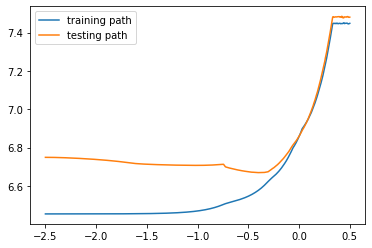

In [11]:
# Change the y-axis to show the actual log10s of the lambdas

plt.plot([x for x in np.linspace(interval_start, interval_end, num=l1_intervals)],train_path,label='training path')
plt.plot([x for x in np.linspace(interval_start, interval_end, num=l1_intervals)],test_path,label='testing path')
plt.legend()



In [12]:
min(test_path)

[6.668736878616998]

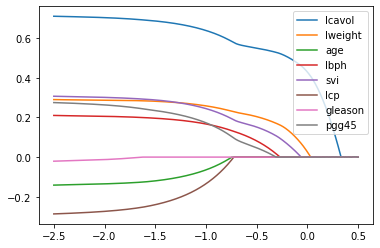

In [13]:
data_labels = ['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']

weight_path = np.array(weight_path)
for w in range(weight_path.shape[1]):
    plt.plot([x for x in np.linspace(interval_start, interval_end, num=l1_intervals)],weight_path[:,w],label = data_labels[w])
plt.legend()

